In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Setup folders and move images except first one
import os
import shutil
from glob import glob

# Define folders
train_images_folder = '/content/drive/MyDrive/AL Data/train/images'
train_labels_folder = '/content/drive/MyDrive/AL Data/train/labels'
unlabeled_images_folder = '/content/Laudare_AL/images/unlabeled'
unlabeled_labels_folder = '/content/Laudare_AL/labels/unlabeled'

# Create unlabeled folders
os.makedirs(unlabeled_images_folder, exist_ok=True)
os.makedirs(unlabeled_labels_folder, exist_ok=True)

# Get all images
all_images = sorted(glob(f'{train_images_folder}/*.png')) + sorted(glob(f'{train_images_folder}/*.jpg'))

if len(all_images) <= 1:
    print("Dataset already prepared.")
else:
    print(f"Found {len(all_images)} images in train folder. Preparing...")
    keep_image = all_images[0]
    keep_name = os.path.basename(keep_image)
    print(f"Keeping: {keep_name}")

    for img_path in all_images[1:]:
        shutil.move(img_path, os.path.join(unlabeled_images_folder, os.path.basename(img_path)))

    # Move labels except the one matching `keep_image`
    all_labels = sorted(glob(f'{train_labels_folder}/*.txt'))
    keep_label_name = keep_name.replace('.png', '.txt').replace('.jpg', '.txt')

    for lbl_path in all_labels:
        lbl_name = os.path.basename(lbl_path)
        if lbl_name != keep_label_name:
            shutil.move(lbl_path, os.path.join(unlabeled_labels_folder, lbl_name))

    print(f"Moved {len(all_images)-1} images and corresponding labels to unlabeled folder.")

# Final Check
print("\nFinal Check:")
print(f"Train Images: {len(os.listdir(train_images_folder))}")
print(f"Train Labels: {len(os.listdir(train_labels_folder))}")
print(f"Unlabeled Images: {len(os.listdir(unlabeled_images_folder))}")
print(f"Unlabeled Labels: {len(os.listdir(unlabeled_labels_folder))}")

# 3. Create data.yaml file
data_yaml_content = """\
train: /content/drive/MyDrive/AL Data/train/images
val: /content/drive/MyDrive/AL Data/valid/images # Added validation path

nc: 9
names: ['clef', 'custos', 'discard', 'line', 'musicDelimiter', 'musicText', 'neume', 'staff', 'text']
"""

os.makedirs('/content/Laudare_AL', exist_ok=True)
with open('/content/Laudare_AL/data.yaml', 'w') as f:
    f.write(data_yaml_content)
print("✅ data.yaml created successfully.")

Found 272 images in train folder. Preparing...
Keeping: c001v_png.rf.6341403335c595c24529caf58f3ef483.jpg
Moved 271 images and corresponding labels to unlabeled folder.

Final Check:
Train Images: 1
Train Labels: 1
Unlabeled Images: 271
Unlabeled Labels: 271
✅ data.yaml created successfully.


In [3]:
# 4. Install Ultralytics and import modules
!pip install -q ultralytics

from ultralytics import YOLO
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random

# 5. Define helper functions

def select_uncertain_images(model, unlabeled_folder, k=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.model.to(device)
    model.model.eval()

    image_scores = []

    for img_name in os.listdir(unlabeled_folder):
        img_path = os.path.join(unlabeled_folder, img_name)
        results = model.predict(img_path, conf=0.001, verbose=False)

        try:
            if len(results[0].boxes) > 0:
                confidences = results[0].boxes.conf.cpu().numpy()
                uncertainty = 1 - confidences.max()
            else:
                uncertainty = 1.0
        except:
            uncertainty = 1.0

        image_scores.append((img_name, uncertainty))

    image_scores.sort(key=lambda x: x[1], reverse=True)
    return [img for img, _ in image_scores[:min(k, len(image_scores))]]

def move_selected_images(selected_images, src_folder, dst_folder, src_label_folder, dst_label_folder):
    for img_name in selected_images:
        shutil.move(os.path.join(src_folder, img_name), os.path.join(dst_folder, img_name))

        label_name = img_name.replace('.png', '.txt').replace('.jpg', '.txt')
        src_lbl = os.path.join(src_label_folder, label_name)
        dst_lbl = os.path.join(dst_label_folder, label_name)

        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)
        else:
            print(f"[Warning] No label for: {img_name}")

def evaluate_model(model, val_yaml):
    metrics = model.val(data=val_yaml, verbose=False)
    return {
        'mAP50': metrics.box.map50,
        'mAP50-95': metrics.box.map,
        'Precision': metrics.box.p[0],
        'Recall': metrics.box.r[0],
        'F1': 2 * (metrics.box.p[0] * metrics.box.r[0]) / (metrics.box.p[0] + metrics.box.r[0] + 1e-6)
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra


🚀 Round 0
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=round_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 90.4MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,012,603 parameters, 3,012,587 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 394MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.0 ms, read: 47.7±0.0 MB/s, size: 85.9 KB)


train: Scanning /content/drive/MyDrive/AL Data/train/labels... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.1±0.0 MB/s, size: 71.6 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:13<00:00,  4.94it/s]

val: New cache created: /content/drive/MyDrive/AL Data/valid/labels.cache


Plotting labels to /content/Laudare_AL/yolo_runs/round_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_0
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150     0.207G      4.961      4.506      4.226         72        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


                   all         68       2461    0.00251      0.158    0.00306   0.000871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150     0.785G      5.092       4.54      4.242         49        640: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461   0.000719     0.0978   0.000962   0.000351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150     0.805G      4.734      4.642      4.497         20        640: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461   0.000642     0.0978   0.000714   0.000272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      0.82G      5.225      4.484      4.206         58        640: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461   0.000479     0.0978    0.00053   0.000203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150     0.838G      4.377      4.504      4.184         39        640: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461   0.000444     0.0978   0.000665   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150     0.854G      5.144      4.507      4.189        106        640: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461   0.000438     0.0978   0.000483   0.000189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150     0.873G      4.782      4.695      4.312         18        640: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461   0.000438     0.0978    0.00046   0.000178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150     0.891G      4.592      4.469      4.427         20        640: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461   0.000444     0.0978   0.000446    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150     0.906G       5.07      4.507      4.429         62        640: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461   0.000444     0.0978   0.000446    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150     0.932G      4.843      4.572      4.326         94        640: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461   0.000449     0.0978    0.00235   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150     0.939G      4.791      4.499      4.174         34        640: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461   0.000449     0.0978    0.00235   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150     0.971G      4.259      4.431      4.146         22        640: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461   0.000461     0.0978   0.000487   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150     0.979G      5.196      4.316      4.345         25        640: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461   0.000461     0.0978   0.000487   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150         1G      5.193      4.495      4.249         71        640: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461   0.000461     0.0978   0.000497   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.01G      4.653      4.419      4.185         39        640: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461   0.000461     0.0978   0.000497   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.04G      5.156      4.213      4.432         24        640: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461   0.000461     0.0978   0.000537   0.000228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.04G      5.106      4.412      4.236         64        640: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461   0.000461     0.0978   0.000537   0.000228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.07G      4.662        4.4      4.221         19        640: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461    0.00184      0.143    0.00236   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.08G      4.937       4.37      4.237         29        640: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461    0.00184      0.143    0.00236   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.1G       4.89       4.53      4.285         74        640: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461    0.00185      0.143    0.00225   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.11G      5.083      4.461      4.176         80        640: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461    0.00185      0.143    0.00225   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.14G      5.366      4.363      4.311         26        640: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.15G      4.878      4.324      4.516         27        640: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.17G      5.105      4.479      4.121         18        640: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.19G      5.138      4.423      4.228         44        640: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.2G      4.373      4.348      4.162         41        640: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.23G      4.269      4.404      4.234         23        640: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.24G      4.055      4.009      4.344         21        640: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.25G       4.84      4.322      4.149         73        640: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.28G      4.896      4.132      4.094         26        640: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.29G      4.788      4.171      4.204         12        640: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.3G       4.84      4.206      4.079         26        640: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.33G      4.951      4.224      4.081         66        640: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.34G      4.591      4.244      4.157         18        640: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.36G      4.924      4.011       4.19         28        640: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.38G      4.855      4.334      4.126         68        640: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       1.4G      4.849      4.202       4.16         21        640: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.41G      5.072      3.999      4.074         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.42G      5.174      4.315      4.062         39        640: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.45G      4.801      3.828      4.013         20        640: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.47G       4.46      4.454      4.081         29        640: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.48G      4.707      4.343       4.14         48        640: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.49G      5.014      4.477      4.132        104        640: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.52G      5.071      3.701      3.914         19        640: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.54G       4.93      3.585      4.089         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.55G      4.717      3.974      4.081         39        640: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.55G      4.788      4.028      3.941         55        640: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.59G      4.073      4.066      4.015         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       1.6G      4.999       3.67      3.808         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.62G      5.186      3.994      4.073         43        640: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.62G      5.293      4.068      4.035         67        640: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.65G      5.092        4.5      3.965         28        640: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.67G      4.734      3.278      3.787         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.69G      5.042      4.062      4.017         54        640: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       1.7G      4.501      3.841      3.922         19        640: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.71G      4.429      3.991      4.028         66        640: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.74G      4.898      4.166      4.051         53        640: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.75G      4.849      4.264       4.05         55        640: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.78G      4.993      4.016      4.017         27        640: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.79G      5.044      4.244      4.056         38        640: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.79G      5.072      3.507      3.796         33        640: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.83G      4.956      3.523      3.687         28        640: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.84G        4.7        3.7      3.798         31        640: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.86G       3.59      4.259      4.082         29        640: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.88G      4.988      3.719      3.841         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.88G      5.183      3.318      3.528         25        640: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.91G      4.507      3.999      3.993         46        640: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.93G      4.796      3.274       3.58         11        640: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.94G      5.117      3.388      3.544         11        640: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.96G      4.902      3.952      3.923         48        640: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.98G      4.848       3.78      4.007         60        640: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.98G      4.661      3.993      3.917         94        640: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.01G      4.888      3.493      3.512         28        640: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.03G      4.739      3.886      4.051         92        640: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.05G      4.736      3.153      3.665         31        640: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.06G      5.114      3.966      4.022         79        640: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.08G      4.804      3.077       3.81         32        640: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.08G      4.704      3.933      4.012        106        640: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.11G        4.5      3.592       3.72         19        640: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.13G      4.805      3.099      3.453         26        640: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.15G      4.314      3.314      3.573         22        640: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.16G      4.481      3.311      3.555         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.18G      4.112      3.752      3.881         23        640: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.2G      4.432      3.777      3.815         38        640: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.57it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.21G      3.896      3.343      3.863         25        640: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.23G      5.186      3.724      3.866         61        640: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.25G      4.576      3.674      3.772         43        640: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.27G      3.958      3.758      3.557         17        640: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.28G      4.636      3.362      3.767         46        640: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.00it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       2.3G        4.4       2.93      3.266         17        640: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.32G      4.611       3.68      3.971         58        640: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.60it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.32G      4.612      3.268      3.769         37        640: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.37it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.35G      4.301      3.275      3.524         18        640: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.37G      4.634      3.695      3.857         70        640: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.39G      4.258      3.546      3.601         20        640: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.55it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       2.4G      4.602      3.462      3.873         47        640: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.42G      4.484      3.231      3.919         36        640: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.44G      4.614      3.693      3.789         37        640: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.45G      4.795      3.211      3.716         42        640: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.46G      4.582      3.558      3.856         60        640: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.50it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.49G      4.809      3.813      4.064         66        640: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]


                   all         68       2461          0          0          0          0
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

101 epochs completed in 0.021 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_0/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_0/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_0/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


                   all         68       2461    0.00251      0.158    0.00306   0.000871
                  clef         47        134          0          0          0          0
                custos         48         93          0          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320          0          0          0          0
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52     0.0125      0.538      0.012    0.00181
                 neume         50       1491          0          0          0          0
                 staff         52        158          0          0          0          0
                  text         25         25     0.0101       0.88     0.0155    0.00604
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


                   all         68       2461   0.000472     0.0933    0.00229   0.000651
Speed: 2.7ms preprocess, 3.6ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/val
✅ Improved mAP50: 0.0023

🚀 Round 1
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_d

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 16 images, 4 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 341.38it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 19.2±9.3 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_1
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.78G      4.838       4.71      4.332        470        640: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all         68       2461   0.000654     0.0978   0.000729   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.78G      4.834      4.728       4.34        158        640: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461   0.000444     0.0978   0.000467   0.000182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.14G      4.886      4.527      4.397        441        640: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461   0.000438     0.0978   0.000483   0.000189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.14G       4.47      4.585      4.414        232        640: 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

                   all         68       2461   0.000444     0.0978   0.000469    0.00018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.14G      4.739      4.623      4.285        273        640: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461   0.000467     0.0978   0.000502   0.000187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.14G      4.779      4.584      4.367        168        640: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461   0.000356     0.0756   0.000803   0.000375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.14G      4.929      4.515      4.335        355        640: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461   0.000473     0.0978   0.000474   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.14G      4.787      4.479      4.306        192        640: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

                   all         68       2461    0.00206      0.135    0.00198   0.000557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.14G       4.93      4.461       4.28        251        640: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461    0.00174      0.187    0.00238   0.000964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.14G      4.888      4.422      4.287        296        640: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461    0.00169      0.187    0.00197   0.000833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.14G      4.738       4.44      4.312        197        640: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461     0.0015      0.187    0.00212   0.000875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.14G      4.715      4.369      4.258        189        640: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461     0.0015      0.187    0.00212   0.000875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.14G      4.689      4.405      4.238        275        640: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461    0.00157      0.209     0.0028   0.000966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.14G      4.846       4.33      4.233        351        640: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461    0.00158      0.209    0.00209   0.000865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.14G      4.728       4.15      4.245        361        640: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461    0.00158      0.209    0.00209   0.000865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.14G      4.776      4.268      4.192        226        640: 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461    0.00157      0.209    0.00242    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.14G      4.679      4.058       4.25        119        640: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461    0.00157      0.209    0.00215   0.000891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.14G      4.765      3.952      4.171        227        640: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461    0.00157      0.209    0.00215   0.000891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.14G      4.645      4.059      4.185        318        640: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461     0.0016      0.209    0.00445    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.14G      4.677      4.069      4.135        169        640: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461     0.0016      0.209    0.00445    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.14G       4.71      4.199      4.131        336        640: 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461     0.0016      0.209    0.00271    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.14G      4.742      4.194      4.084        360        640: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

                   all         68       2461     0.0016      0.209    0.00271    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.14G      4.455      4.245      4.119        203        640: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461    0.00168      0.209    0.00307    0.00121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.14G      4.752      3.759      3.976        198        640: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

                   all         68       2461    0.00168      0.209    0.00307    0.00121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.14G      4.744      3.906      4.107        175        640: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461    0.00163      0.209    0.00476    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.14G      4.515        3.8      4.003        608        640: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461    0.00163      0.209    0.00476    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.14G      4.408      3.612          4        226        640: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461    0.00163      0.209    0.00476    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.14G      4.402      3.635      3.915        264        640: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461     0.0016      0.209    0.00371    0.00133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.14G      4.565      3.811      3.953        265        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461     0.0016      0.209    0.00371    0.00133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.14G      4.385      3.993      4.002        318        640: 100%|██████████| 2/2 [00:00<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461    0.00154      0.187    0.00271    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.14G      4.421      3.648      3.866        250        640: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461    0.00154      0.187    0.00271    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.14G      4.282       3.62      3.908        302        640: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461    0.00154      0.187    0.00271    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.14G      4.374      3.605      3.855        276        640: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461    0.00237      0.182    0.00327    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.14G      4.276      3.353      3.823        248        640: 100%|██████████| 2/2 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461    0.00237      0.182    0.00327    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.14G       4.21      3.502      3.834        123        640: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461    0.00237      0.182    0.00327    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.14G      4.348      3.473      3.836        255        640: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461    0.00114      0.111    0.00207   0.000841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.14G      4.162      3.318      3.802        225        640: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461    0.00114      0.111    0.00207   0.000841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.14G      4.178      3.556      3.871        177        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

                   all         68       2461    0.00114      0.111    0.00207   0.000841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.14G      4.365      3.408      3.755        305        640: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461    0.00114      0.111    0.00327   0.000935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.14G      4.373      3.452      3.715        218        640: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461    0.00114      0.111    0.00327   0.000935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.14G       4.19      3.278      3.819        150        640: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461    0.00114      0.111    0.00327   0.000935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.14G      4.274      3.327      3.737        262        640: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461    0.00111      0.111    0.00195   0.000774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.14G      4.336      3.372      3.721        295        640: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461    0.00111      0.111    0.00195   0.000774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.14G      4.198       3.23      3.565        142        640: 100%|██████████| 2/2 [00:00<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461    0.00111      0.111    0.00195   0.000774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.14G       4.45      3.162      3.557         98        640: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461    0.00111      0.111    0.00195   0.000774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.14G      4.122       3.28      3.706        207        640: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461     0.0012      0.111    0.00167   0.000688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.14G      4.078      3.139      3.635        330        640: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461     0.0012      0.111    0.00167   0.000688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.14G      4.191      3.059      3.519        122        640: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461     0.0012      0.111    0.00167   0.000688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.14G      4.065      3.099      3.583        156        640: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461     0.0012      0.111    0.00167   0.000688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.14G       3.93      3.308      3.666        281        640: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461    0.00119      0.111    0.00162   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.14G      4.356      3.288      3.567        233        640: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

                   all         68       2461    0.00119      0.111    0.00162   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.14G      4.103      3.075      3.625        193        640: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461    0.00119      0.111    0.00162   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.14G      4.198      3.127      3.652        278        640: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461    0.00119      0.111    0.00162   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.14G      4.108      3.198      3.581        280        640: 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.14G      4.243      3.051      3.474        254        640: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.14G      4.092      3.013      3.547        219        640: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.14G      4.186      3.123      3.685        373        640: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.14G      4.292      3.101      3.444        152        640: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.14G      3.876      2.914      3.574        226        640: 100%|██████████| 2/2 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.14G      4.129      3.166      3.554        248        640: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.14G       4.15      2.866      3.469        204        640: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.14G      4.034      2.984      3.609        260        640: 100%|██████████| 2/2 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461    0.00116     0.0534   0.000862   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.14G      3.715      3.063      3.515        192        640: 100%|██████████| 2/2 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461    0.00116     0.0534   0.000862   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.14G       4.02      2.938      3.496        348        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

                   all         68       2461    0.00116     0.0534   0.000862   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.14G      3.934      2.798      3.456        160        640: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

                   all         68       2461    0.00116     0.0534   0.000862   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.14G      4.039      2.962      3.515        404        640: 100%|██████████| 2/2 [00:00<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.57it/s]

                   all         68       2461    0.00116      0.109    0.00188   0.000635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.14G      3.802      2.855      3.336        201        640: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]

                   all         68       2461    0.00116      0.109    0.00188   0.000635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.14G      3.803       2.92      3.365        241        640: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]

                   all         68       2461    0.00116      0.109    0.00188   0.000635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.14G      3.892        2.8      3.432        211        640: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

                   all         68       2461    0.00116      0.109    0.00188   0.000635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.14G      4.084      2.845      3.383        177        640: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

                   all         68       2461    0.00529      0.131     0.0115    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.14G      3.877       3.26      3.396        110        640: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

                   all         68       2461    0.00529      0.131     0.0115    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.14G      3.739      2.899      3.315        182        640: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

                   all         68       2461    0.00529      0.131     0.0115    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.14G      3.858      2.933      3.538        264        640: 100%|██████████| 2/2 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

                   all         68       2461    0.00529      0.131     0.0115    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.14G      3.808      2.699      3.486        279        640: 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461    0.00569      0.158     0.0163    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.14G      3.837        2.9      3.475        202        640: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461    0.00569      0.158     0.0163    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.14G      3.845      2.603      3.237        182        640: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461    0.00569      0.158     0.0163    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.14G      3.896       2.68      3.337        243        640: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461    0.00569      0.158     0.0163    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.14G      3.844      2.754       3.27        273        640: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461    0.00492      0.158     0.0205    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.14G      4.008      2.785      3.266        211        640: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461    0.00492      0.158     0.0205    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.14G      3.951      2.715      3.237        339        640: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461    0.00492      0.158     0.0205    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.14G      3.964      2.659      3.252        356        640: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

                   all         68       2461    0.00492      0.158     0.0205    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.14G      3.782      3.308      3.307        348        640: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461    0.00412       0.16     0.0223    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.14G      3.612      2.648      3.242        177        640: 100%|██████████| 2/2 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

                   all         68       2461    0.00412       0.16     0.0223    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.14G      3.756      2.609      3.242        242        640: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461    0.00412       0.16     0.0223    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.14G      3.879      2.781      3.249        334        640: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461    0.00412       0.16     0.0223    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.14G      3.857      2.704      3.166        356        640: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.841     0.0183     0.0278    0.00589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.14G      3.679      2.578      3.255        227        640: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.841     0.0183     0.0278    0.00589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.14G      3.803      2.466      3.211        221        640: 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.841     0.0183     0.0278    0.00589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.14G      3.745      2.715      3.283        210        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.841     0.0183     0.0278    0.00589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.14G       3.63      2.547       3.25        286        640: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.809     0.0402     0.0248    0.00633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.14G      3.645      2.515      3.225        179        640: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.809     0.0402     0.0248    0.00633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.14G      3.805       2.72      3.119        239        640: 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461      0.809     0.0402     0.0248    0.00633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.14G      3.578      2.482      3.321        271        640: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

                   all         68       2461      0.809     0.0402     0.0248    0.00633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.14G      3.843      2.761      3.182        232        640: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461      0.693     0.0601     0.0346    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.14G      3.354      2.455      3.184        179        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]

                   all         68       2461      0.693     0.0601     0.0346    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.14G      3.752      2.635      3.269        187        640: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.693     0.0601     0.0346    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.14G      3.944      2.833       3.04        109        640: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.693     0.0601     0.0346    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.14G      3.702      2.685      3.118        179        640: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.706     0.0814      0.037    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.14G      3.746      2.627      3.038        195        640: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

                   all         68       2461      0.706     0.0814      0.037    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.14G      3.694      2.596      3.177        145        640: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

                   all         68       2461      0.706     0.0814      0.037    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.14G      3.601      2.924      3.235        424        640: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.706     0.0814      0.037    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.14G      3.778      2.643       3.08        201        640: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

                   all         68       2461      0.704     0.0977     0.0295    0.00625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.14G       3.51      2.483      3.039        192        640: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

                   all         68       2461      0.704     0.0977     0.0295    0.00625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.14G      3.408      2.455      3.299        211        640: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.704     0.0977     0.0295    0.00625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.14G      3.545        2.6      2.972        307        640: 100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

                   all         68       2461      0.704     0.0977     0.0295    0.00625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.14G      3.729      2.646      3.112        232        640: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]

                   all         68       2461      0.371      0.123     0.0278    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.14G      3.565      2.376      3.068        190        640: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

                   all         68       2461      0.371      0.123     0.0278    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.14G      3.346      2.512        3.1        297        640: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]

                   all         68       2461      0.371      0.123     0.0278    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.14G      3.888      2.946      3.203        194        640: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.16it/s]

                   all         68       2461      0.371      0.123     0.0278    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.14G      3.607      2.622      3.032        206        640: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.613       0.12      0.033    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.14G       3.36      2.414      3.148        261        640: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

                   all         68       2461      0.613       0.12      0.033    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.14G      3.481      2.469      3.175        343        640: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.613       0.12      0.033    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.14G      3.606      2.559       3.21        243        640: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

                   all         68       2461      0.613       0.12      0.033    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.14G      3.659      2.646      2.993        247        640: 100%|██████████| 2/2 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

                   all         68       2461      0.625      0.103     0.0496    0.00915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.14G      3.544      2.464      3.001        172        640: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.625      0.103     0.0496    0.00915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.14G      3.668      2.762      3.105        173        640: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461      0.625      0.103     0.0496    0.00915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.14G      3.341      2.586      3.064        182        640: 100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

                   all         68       2461      0.625      0.103     0.0496    0.00915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.14G        3.3      2.247      2.994        271        640: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

                   all         68       2461      0.614      0.122     0.0499    0.00944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.14G      3.582       2.48      3.049        251        640: 100%|██████████| 2/2 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.614      0.122     0.0499    0.00944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.14G      3.495        2.4      3.208        192        640: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461      0.614      0.122     0.0499    0.00944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.14G      3.626      2.352      2.954        183        640: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

                   all         68       2461      0.614      0.122     0.0499    0.00944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.14G      3.357      2.458      2.763        156        640: 100%|██████████| 2/2 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

                   all         68       2461      0.502      0.125     0.0446    0.00861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.14G      3.379       2.33      3.049        272        640: 100%|██████████| 2/2 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.502      0.125     0.0446    0.00861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.14G      3.241      2.386      3.138        218        640: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.30it/s]

                   all         68       2461      0.502      0.125     0.0446    0.00861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.14G      3.397      2.285      3.072        185        640: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.502      0.125     0.0446    0.00861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.14G      3.474      2.411      2.878        222        640: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

                   all         68       2461      0.507      0.121     0.0498    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.14G      3.471      2.196      2.869        125        640: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.507      0.121     0.0498    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.14G      3.589      2.291      2.864        178        640: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

                   all         68       2461      0.507      0.121     0.0498    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.14G      3.566      2.438      3.107        220        640: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.507      0.121     0.0498    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.14G      3.526      2.327      2.988        245        640: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

                   all         68       2461      0.509      0.106     0.0512    0.00966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.14G      3.582      2.529      2.825        225        640: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.509      0.106     0.0512    0.00966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.14G      3.541      2.306      2.967        356        640: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]

                   all         68       2461      0.509      0.106     0.0512    0.00966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.14G      3.549      2.485      2.945        202        640: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]

                   all         68       2461      0.509      0.106     0.0512    0.00966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.14G      3.289       2.35      3.013        164        640: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.40it/s]

                   all         68       2461      0.508      0.114     0.0501    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.14G      3.527      2.557      3.091        261        640: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

                   all         68       2461      0.508      0.114     0.0501    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.14G      3.508      2.444      2.927        202        640: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.78it/s]

                   all         68       2461      0.508      0.114     0.0501    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.14G      3.622      2.418      2.855        164        640: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.508      0.114     0.0501    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.14G      3.284      2.195      2.786        143        640: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.506      0.134     0.0471    0.00914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.14G      3.246      2.105      2.955        263        640: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

                   all         68       2461      0.506      0.134     0.0471    0.00914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.14G      3.343      2.158      3.008        267        640: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.506      0.134     0.0471    0.00914


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.14G      4.039      2.616       2.32         67        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.44it/s]

                   all         68       2461      0.506      0.134     0.0471    0.00914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.14G      3.948      2.597      2.323        145        640: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

                   all         68       2461      0.515      0.104     0.0512     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.14G      3.772      2.664      2.344        129        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.515      0.104     0.0512     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.14G      3.772      2.543      2.379        129        640: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.515      0.104     0.0512     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.14G      3.888       2.38      2.278        153        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

                   all         68       2461      0.515      0.104     0.0512     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.14G      4.216      2.749      2.365        163        640: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.516      0.108     0.0563      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.14G      3.906      2.453      2.302        122        640: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461      0.516      0.108     0.0563      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.14G      4.311      2.704      2.417        119        640: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

                   all         68       2461      0.516      0.108     0.0563      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.14G      3.984      2.578      2.333        121        640: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.29it/s]

                   all         68       2461      0.516      0.108     0.0563      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.14G       3.91      2.525      2.364        105        640: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

                   all         68       2461      0.399     0.0964     0.0547     0.0105



150 epochs completed in 0.038 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_1/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_1/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_1/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


                   all         68       2461      0.516      0.104     0.0589     0.0113
                  clef         47        134          1          0          0          0
                custos         48         93          1          0          0          0
               discard          8         17          1          0          0          0
                  line         53        320       0.07      0.188     0.0303    0.00444
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52      0.164      0.173      0.172     0.0414
                 neume         50       1491          1          0          0          0
                 staff         52        158        0.3      0.304      0.199      0.036
                  text         25         25      0.112      0.272      0.129       0.02
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 15.8ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all         68       2461      0.515     0.0994     0.0594     0.0114
Speed: 2.9ms preprocess, 1.1ms inference, 0.0ms loss, 18.8ms postprocess per image
Results saved to runs/detect/val2
✅ Improved mAP50: 0.0594

🚀 Round 2
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 31 images, 17 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 338.24it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 25.7±9.1 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.37G      3.277      2.464      2.839         47        640: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

                   all         68       2461      0.518      0.104     0.0589     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.53G      3.449      3.387      2.755         62        640: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

                   all         68       2461      0.531     0.0983     0.0625      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.53G      3.049       2.63      3.012        129        640: 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

                   all         68       2461      0.404     0.0946     0.0586     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.53G      3.366      2.633      2.834         87        640: 100%|██████████| 4/4 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

                   all         68       2461      0.381      0.114     0.0477     0.0114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.53G      3.484      2.598      2.883        188        640: 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

                   all         68       2461       0.49     0.0981     0.0465     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.53G      3.372      2.818      2.996        204        640: 100%|██████████| 4/4 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

                   all         68       2461      0.495     0.0893     0.0475      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.53G      3.281      2.471      2.848        111        640: 100%|██████████| 4/4 [00:00<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]

                   all         68       2461      0.601     0.0967     0.0499     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.53G      3.535      2.795      2.555        160        640: 100%|██████████| 4/4 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]

                   all         68       2461      0.585      0.104     0.0508     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.53G      3.365      2.431      2.736         69        640: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.38it/s]

                   all         68       2461      0.559      0.111     0.0489     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.53G      3.218      2.497      2.758        158        640: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]

                   all         68       2461      0.524      0.117     0.0573     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.53G      3.369      2.906      2.615         95        640: 100%|██████████| 4/4 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]

                   all         68       2461      0.529      0.126     0.0682     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.53G      3.174      2.692      2.994         85        640: 100%|██████████| 4/4 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]

                   all         68       2461      0.528      0.127      0.067      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.53G      3.253      2.299      2.554        203        640: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]

                   all         68       2461      0.628     0.0966     0.0588     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.53G      3.196      2.592      2.894         80        640: 100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.634      0.116     0.0651     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.53G      3.099      2.478      2.639        224        640: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

                   all         68       2461      0.727      0.108     0.0595     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.53G       3.06      2.472      2.586         41        640: 100%|██████████| 4/4 [00:00<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]

                   all         68       2461      0.727      0.108     0.0595     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.53G      2.991      2.154      2.617         85        640: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.618      0.118     0.0673     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.53G      3.064      2.593      2.563         80        640: 100%|██████████| 4/4 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

                   all         68       2461      0.343      0.122     0.0755     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.53G      2.894      2.044      2.575        142        640: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]

                   all         68       2461      0.343      0.122     0.0755     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.53G      3.097       2.27      2.401        120        640: 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

                   all         68       2461       0.39       0.13     0.0714     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.53G       3.04      2.615      2.529        169        640: 100%|██████████| 4/4 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]

                   all         68       2461      0.525      0.125     0.0523     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.53G      3.148      2.319       2.52        142        640: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.36it/s]

                   all         68       2461      0.525      0.125     0.0523     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.53G       3.25      2.158      2.339        129        640: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]

                   all         68       2461       0.61     0.0902     0.0424     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.53G      3.017      2.206      2.428        119        640: 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]

                   all         68       2461       0.61     0.0902     0.0424     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.53G      3.193      2.498      2.462        147        640: 100%|██████████| 4/4 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

                   all         68       2461      0.609      0.103     0.0422     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.53G       3.15      2.205      2.218         99        640: 100%|██████████| 4/4 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]

                   all         68       2461      0.609      0.103     0.0422     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.53G      3.087      2.357      2.238         41        640: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

                   all         68       2461      0.626      0.105     0.0501     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.53G      3.118      2.238      2.212        255        640: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

                   all         68       2461      0.626      0.105     0.0501     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.53G      2.833      1.942      2.265        108        640: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

                   all         68       2461      0.657      0.108      0.084     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.53G      2.731      2.144      2.461         81        640: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.657      0.108      0.084     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.53G      2.989      2.312      2.453        270        640: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.633     0.0841     0.0532     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.53G      2.709      2.357      2.542        190        640: 100%|██████████| 4/4 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.633     0.0841     0.0532     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.53G        3.1      2.221       2.18        144        640: 100%|██████████| 4/4 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.626     0.0991     0.0542     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.53G       2.77      2.035       2.24        125        640: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

                   all         68       2461      0.626     0.0991     0.0542     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.53G       2.75      2.272      2.527        124        640: 100%|██████████| 4/4 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.639     0.0777       0.06     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.53G      2.823      2.017      2.379        277        640: 100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.639     0.0777       0.06     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.53G      2.847      1.974      1.925        184        640: 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461       0.62     0.0729     0.0386    0.00981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.53G      2.707      1.906      2.265        201        640: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461       0.62     0.0729     0.0386    0.00981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.53G      2.747      2.173      2.439         82        640: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.645     0.0432     0.0327    0.00792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.53G      2.885      2.005      2.162        176        640: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.645     0.0432     0.0327    0.00792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.53G      2.767      1.929      1.995        145        640: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.626     0.0194     0.0197    0.00501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.53G      2.937      2.464      2.448         52        640: 100%|██████████| 4/4 [00:00<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.626     0.0194     0.0197    0.00501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.53G       2.83      1.921      2.222         77        640: 100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.676     0.0996     0.0695     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.53G      2.578      2.021      2.258         83        640: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.676     0.0996     0.0695     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.53G      2.821      2.161      2.189         54        640: 100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461       0.67      0.202      0.127     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.53G      2.593      2.045      2.389        192        640: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461       0.67      0.202      0.127     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.53G       2.66      2.033       2.36        178        640: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461       0.67      0.247      0.133     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.53G      2.581       1.88      2.295        119        640: 100%|██████████| 4/4 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461       0.67      0.247      0.133     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.53G      2.779      1.928      2.067        145        640: 100%|██████████| 4/4 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.672      0.263      0.122     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.53G      2.724      2.239      2.257        137        640: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.672      0.263      0.122     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.53G      2.547      1.959      2.229        121        640: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.675      0.268      0.128     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.53G      2.724      1.935      2.108         80        640: 100%|██████████| 4/4 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.675      0.268      0.128     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.53G      2.563      1.829      2.277         83        640: 100%|██████████| 4/4 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461       0.68      0.266      0.138     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.53G      2.702       1.92      2.193        118        640: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461       0.68      0.266      0.138     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.53G      2.697      1.912      2.271        116        640: 100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.715      0.181      0.166     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.53G      2.487      1.934      2.251        101        640: 100%|██████████| 4/4 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.715      0.181      0.166     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.53G      2.641      2.052       2.24         54        640: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461       0.73      0.166       0.18     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.53G       2.68      2.412      2.254        127        640: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461       0.73      0.166       0.18     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.53G      2.475      1.848      2.267         98        640: 100%|██████████| 4/4 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

                   all         68       2461       0.72      0.198      0.183     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.53G      2.406      1.856      2.198        110        640: 100%|██████████| 4/4 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461       0.72      0.198      0.183     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.53G      2.771      2.164      1.961         39        640: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]

                   all         68       2461      0.726      0.197      0.178     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.53G      2.383      1.766      2.201        228        640: 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461      0.726      0.197      0.178     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.53G      2.704      2.117      2.163         38        640: 100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.747       0.19      0.192     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.53G      2.407      1.729      2.176        113        640: 100%|██████████| 4/4 [00:00<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461      0.747       0.19      0.192     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.53G      2.269      1.692      2.204        108        640: 100%|██████████| 4/4 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.728       0.19      0.191     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.53G      2.512      1.948      2.188        190        640: 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.728       0.19      0.191     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.53G      2.601      2.044      2.313        119        640: 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.713      0.224       0.19     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.53G      2.435      1.963      2.219         84        640: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.713      0.224       0.19     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.53G      2.561      1.886      2.223         61        640: 100%|██████████| 4/4 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.748      0.206       0.19     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.53G      2.517      1.842      2.243         50        640: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.748      0.206       0.19     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.53G      2.308      1.746      2.104         91        640: 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.757      0.229      0.199      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.53G      2.482      2.086      2.375        183        640: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.757      0.229      0.199      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.53G      2.296      1.696      1.951        105        640: 100%|██████████| 4/4 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.759      0.223      0.209     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.53G      2.337      1.675      2.036         60        640: 100%|██████████| 4/4 [00:00<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

                   all         68       2461      0.759      0.223      0.209     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.53G      2.459      2.054      2.498         83        640: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.762      0.269      0.218     0.0668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.53G      2.663      1.907       2.02         30        640: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.762      0.269      0.218     0.0668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.53G      2.306      1.858      2.141         58        640: 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.734      0.284      0.218     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.53G       2.37      1.646      1.987         69        640: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.734      0.284      0.218     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.53G      2.296       1.82       1.99         73        640: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.735      0.254      0.218     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.53G      2.378      1.663      2.303        139        640: 100%|██████████| 4/4 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.735      0.254      0.218     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.53G      2.229      1.591      2.133        135        640: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.725      0.249      0.215     0.0808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.53G      2.415      1.639      2.155        168        640: 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.725      0.249      0.215     0.0808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.53G      2.608      2.054      2.204         76        640: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461      0.725      0.225      0.205     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.53G      2.422      1.808      2.108         81        640: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.725      0.225      0.205     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.53G      2.442      1.853       2.11        115        640: 100%|██████████| 4/4 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.736      0.236      0.209     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.53G      2.294       1.68      1.993        101        640: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.736      0.236      0.209     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.53G      2.315      1.908      2.297        124        640: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.739      0.231      0.214     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.53G      2.281      1.664      2.347        158        640: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.739      0.231      0.214     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.53G      2.354      1.736      2.174        146        640: 100%|██████████| 4/4 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.738      0.216       0.21     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.53G      2.229      1.737      2.152         39        640: 100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.738      0.216       0.21     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.53G      2.259      1.644      2.168        144        640: 100%|██████████| 4/4 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.724      0.223      0.205     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.53G      2.208      1.584      2.273        119        640: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.724      0.223      0.205     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.53G      2.296      1.697      2.133        105        640: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.719      0.252      0.204     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.53G      2.193      1.702       1.99        169        640: 100%|██████████| 4/4 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.719      0.252      0.204     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.53G       2.19      1.701      2.065        116        640: 100%|██████████| 4/4 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.712      0.265       0.21     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.53G       2.14      1.791      2.286         94        640: 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.712      0.265       0.21     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.53G      2.147      1.781      1.943         93        640: 100%|██████████| 4/4 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.738      0.277      0.225     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.53G      2.135      1.557       2.16        219        640: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.738      0.277      0.225     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.53G      2.121      1.545      2.195        105        640: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461       0.76      0.264      0.236     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.53G      2.138      1.663      1.952         47        640: 100%|██████████| 4/4 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461       0.76      0.264      0.236     0.0898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.53G      2.167      1.698      2.191         90        640: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.763      0.283      0.242     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.53G      2.433      1.998      2.355         71        640: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.763      0.283      0.242     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.53G      2.121      1.548      2.072         74        640: 100%|██████████| 4/4 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.766      0.274      0.243     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.53G       2.18      1.707      2.045        147        640: 100%|██████████| 4/4 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.766      0.274      0.243     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.53G       2.25      1.714      2.181        113        640: 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.78      0.269      0.241     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.53G      2.183        1.6      2.048        155        640: 100%|██████████| 4/4 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461       0.78      0.269      0.241     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.53G      2.127      1.482      2.092        119        640: 100%|██████████| 4/4 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.785      0.289      0.247      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.53G      2.128      1.704        2.3         72        640: 100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.785      0.289      0.247      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.53G      2.281       1.77       1.92         76        640: 100%|██████████| 4/4 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.785      0.265      0.252      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.53G      2.253       1.74      2.188         86        640: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.785      0.265      0.252      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.53G      2.329        2.6      2.224         14        640: 100%|██████████| 4/4 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.772       0.26      0.259      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.53G      2.335      1.618      1.963         74        640: 100%|██████████| 4/4 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.772       0.26      0.259      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.53G      2.153       1.71      2.149        128        640: 100%|██████████| 4/4 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.777      0.259      0.262      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.53G      2.283       1.66      2.034         62        640: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.777      0.259      0.262      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.53G      2.177      1.518      2.199        165        640: 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.761      0.264      0.254      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.53G      2.099      1.605      2.119        135        640: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.761      0.264      0.254      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.53G       2.06      1.464      2.084        170        640: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.764       0.26      0.252      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.53G      2.088      1.585      2.115         85        640: 100%|██████████| 4/4 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.764       0.26      0.252      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.53G      2.202      1.586      1.942        221        640: 100%|██████████| 4/4 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461       0.76       0.25      0.251      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.53G      2.125      1.779      2.084         70        640: 100%|██████████| 4/4 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461       0.76       0.25      0.251      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.53G      2.136      1.651      2.137         53        640: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.775      0.245      0.254      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.53G      2.112      1.629      2.169        148        640: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]

                   all         68       2461      0.775      0.245      0.254      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.53G      1.935       1.43      1.946        129        640: 100%|██████████| 4/4 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.776      0.261      0.258      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.53G      2.068      1.496      2.059         58        640: 100%|██████████| 4/4 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.776      0.261      0.258      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.53G      2.027      1.506      1.963        117        640: 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.667      0.271       0.26      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.53G      2.042      1.471      1.933        164        640: 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.667      0.271       0.26      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.53G      2.122      1.751      2.125        112        640: 100%|██████████| 4/4 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


                   all         68       2461      0.675      0.272      0.259      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.53G      2.233      1.625      2.149        107        640: 100%|██████████| 4/4 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.675      0.272      0.259      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.53G      2.139      1.521      2.012        150        640: 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.675      0.285      0.256       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.53G      2.038      1.511      2.002        146        640: 100%|██████████| 4/4 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.675      0.285      0.256       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.53G       2.12      1.589      1.911        150        640: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


                   all         68       2461      0.675      0.298      0.256       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.53G      1.949      1.466      2.051        239        640: 100%|██████████| 4/4 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.675      0.298      0.256       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.53G      2.006      1.445      2.144        220        640: 100%|██████████| 4/4 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.671      0.284      0.258      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.53G      2.118      1.636      1.966        161        640: 100%|██████████| 4/4 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.671      0.284      0.258      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.53G      2.022      1.373      2.057        196        640: 100%|██████████| 4/4 [00:00<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.676      0.287      0.262      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.53G      2.043      1.551      2.121         94        640: 100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.676      0.287      0.262      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.53G      2.089      1.483      1.973        109        640: 100%|██████████| 4/4 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.682      0.289      0.267      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.53G      2.079      1.494      2.069        115        640: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.682      0.289      0.267      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.53G      1.999      1.502      2.141        104        640: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


                   all         68       2461      0.685      0.291      0.266      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.53G      2.044      1.454      1.957         93        640: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.685      0.291      0.266      0.118


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.53G      2.367      1.897      1.561         12        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.688      0.286      0.265      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.53G       2.38      1.843      1.629         74        640: 100%|██████████| 4/4 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.688      0.286      0.265      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.53G      2.077      1.773      1.673         96        640: 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.675      0.297      0.261      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.53G      2.123      1.745      1.657         80        640: 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.675      0.297      0.261      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.53G      2.195      1.798      1.722         65        640: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.679      0.294      0.264      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.53G      2.145      1.683      1.841        130        640: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.679      0.294      0.264      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.53G      2.106      2.008      1.689         65        640: 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.683      0.296      0.261      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.53G      2.055      1.597       1.65         92        640: 100%|██████████| 4/4 [00:00<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.683      0.296      0.261      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.53G      2.277      1.933      1.664        127        640: 100%|██████████| 4/4 [00:00<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.671      0.296      0.258      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.53G      2.309      1.812      1.741         35        640: 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.671      0.296      0.258      0.116



150 epochs completed in 0.043 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_2/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_2/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_2/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


                   all         68       2461       0.68      0.289      0.266      0.118
                  clef         47        134          1          0          0          0
                custos         48         93          1          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320      0.834      0.869      0.893      0.417
        musicDelimiter         49        171          1          0          0          0
             musicText         52         52        0.3      0.423      0.291      0.107
                 neume         50       1491          1          0          0          0
                 staff         52        158      0.513      0.867      0.775      0.365
                  text         25         25      0.471       0.44      0.433      0.176
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 15.2ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


                   all         68       2461       0.68      0.289      0.267      0.119
Speed: 2.8ms preprocess, 1.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/val3
✅ Improved mAP50: 0.2668

🚀 Round 3
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 46 images, 32 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 325.36it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 21.3±4.3 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.13G      1.922      2.379      2.262         62        640: 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.687      0.316      0.264      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.29G      2.112      4.399      2.331         70        640: 100%|██████████| 6/6 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.599      0.282      0.268      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.29G      2.071      1.947      2.049         31        640: 100%|██████████| 6/6 [00:00<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.696      0.271      0.272      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.29G      2.256      1.949      2.185         98        640: 100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.697      0.288      0.273      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.29G      2.147      1.904          2         68        640: 100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.692      0.309      0.271      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.29G      1.917      1.601      2.141         46        640: 100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.687      0.282      0.273      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.29G      1.982      1.598      2.033         32        640: 100%|██████████| 6/6 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.637      0.244      0.257      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.29G      2.267      1.912        2.3         44        640: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461       0.65      0.214      0.225      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.46G      2.088      1.697      2.005        113        640: 100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.654      0.191      0.207     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.46G      2.048      1.772      2.041        155        640: 100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.626      0.269      0.233     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.46G      2.081       1.73      2.054        109        640: 100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.639      0.212      0.219     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.46G      2.079      1.788      1.917         30        640: 100%|██████████| 6/6 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.772      0.178      0.209     0.0805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.46G      2.193      1.925      2.073         12        640: 100%|██████████| 6/6 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.627      0.229      0.197     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.46G       2.18      1.635      2.076         41        640: 100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.624       0.22      0.192     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.46G      2.049      2.142      2.081          6        640: 100%|██████████| 6/6 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.624       0.22      0.192     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.46G      2.065      1.773      2.078         48        640: 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.598      0.213      0.152     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.46G      2.308       1.84      1.975        257        640: 100%|██████████| 6/6 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.612      0.218      0.164      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.46G      2.132      2.126      2.314         56        640: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.649      0.241       0.21       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.46G      2.103      1.751      2.088        136        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461      0.649      0.241       0.21       0.09

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.46G      2.133       1.68      1.998        181        640: 100%|██████████| 6/6 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461       0.63      0.271       0.23      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.47G      2.152      1.756      2.123         24        640: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.626      0.276       0.22     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.47G      2.086      1.784       2.13        125        640: 100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.521      0.229      0.207     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.47G       2.08      1.768      2.179         61        640: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.521      0.229      0.207     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.47G      2.081      1.802      2.183        146        640: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]

                   all         68       2461      0.412      0.236      0.207     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.47G      1.997      1.616      2.205        105        640: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.447      0.218      0.218     0.0888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.47G      1.946      1.649      2.056        106        640: 100%|██████████| 6/6 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.232      0.258      0.245      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.47G      2.138      2.041      2.056         20        640: 100%|██████████| 6/6 [00:00<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.232      0.258      0.245      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.47G      2.037        1.6      2.111         54        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.254      0.269       0.27      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.47G      1.939      1.652      2.177         66        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.267      0.276      0.277      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.47G      1.919      1.493      1.889         54        640: 100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


                   all         68       2461      0.261      0.262      0.277      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.47G      2.008      1.671      1.995         72        640: 100%|██████████| 6/6 [00:00<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.261      0.262      0.277      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.47G       1.95      1.493      1.977         86        640: 100%|██████████| 6/6 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.252      0.288      0.273      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.47G      1.879       1.94      2.042         10        640: 100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


                   all         68       2461      0.246      0.283      0.273      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.47G      1.851      1.579      1.874         37        640: 100%|██████████| 6/6 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.254      0.276      0.266      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.47G      2.079      1.665      2.123         19        640: 100%|██████████| 6/6 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.254      0.276      0.266      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.47G      1.851      1.525      1.963         80        640: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.335      0.288      0.256       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.47G       2.09      1.707      2.104        146        640: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461       0.24      0.317      0.274      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.47G        2.1      1.849      1.964         33        640: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.247       0.33      0.298      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.47G      2.113      3.633      2.233         10        640: 100%|██████████| 6/6 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.247       0.33      0.298      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.49G      1.956      1.647      2.148        136        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.254       0.33      0.299      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.49G       1.92      1.642      1.923         49        640: 100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.272      0.323      0.302      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.49G      1.842      1.531      1.862         39        640: 100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.506      0.294      0.305       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.49G      1.888      1.493       1.89         57        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.506      0.294      0.305       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.49G      1.901      1.669      1.833         56        640: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.376      0.316      0.311      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.49G      1.869      1.467      1.943        134        640: 100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.376       0.28      0.295      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.49G        1.9      1.448      1.902         76        640: 100%|██████████| 6/6 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.455      0.281      0.287      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.49G      1.886      1.455      1.957        132        640: 100%|██████████| 6/6 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.455      0.281      0.287      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.49G      1.825      1.402      1.902         43        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.475      0.287      0.289       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.49G      1.852        1.6      1.915         33        640: 100%|██████████| 6/6 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461       0.47      0.296      0.286      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.49G      1.912      2.028      2.006         23        640: 100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.369       0.31      0.294      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.49G      1.874      1.376      2.012         52        640: 100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.369       0.31      0.294      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.49G      1.823      1.419      1.946        128        640: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.486      0.331      0.305      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.49G      1.896      1.449      1.909        138        640: 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.252      0.326      0.298      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.49G      1.839      1.353      1.839        161        640: 100%|██████████| 6/6 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.248      0.313      0.294      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.49G      1.976      1.694      1.936         14        640: 100%|██████████| 6/6 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.248      0.313      0.294      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.49G      1.843      1.496      1.821         28        640: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.253      0.324      0.297      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.49G      1.908      1.576      1.937         26        640: 100%|██████████| 6/6 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.268      0.321      0.304      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.49G      1.905      1.475       1.87         82        640: 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.318       0.32      0.315      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.49G      2.009      1.565      1.959         83        640: 100%|██████████| 6/6 [00:00<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.318       0.32      0.315      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.49G      1.797      1.471      1.931         86        640: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.421      0.317      0.314      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.49G      1.809      1.527      1.917         30        640: 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.532      0.324      0.318      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.49G      1.802      1.322      1.889        139        640: 100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.634      0.347      0.316      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.49G      1.904      1.521       1.95         80        640: 100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.634      0.347      0.316      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.49G      1.792       1.36      1.922         45        640: 100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.745      0.338      0.313      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.49G      1.885      1.542      1.928        140        640: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.384      0.342      0.311      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.49G      1.801      1.466      1.946         83        640: 100%|██████████| 6/6 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


                   all         68       2461      0.367      0.349      0.305      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.49G      1.812      1.691      1.938         38        640: 100%|██████████| 6/6 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.367      0.349      0.305      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.49G      1.807      1.349      1.918         55        640: 100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.242      0.341      0.299      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.49G      1.779       1.47      1.943         40        640: 100%|██████████| 6/6 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461       0.23      0.329      0.293      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.49G      1.892      1.692      1.926        152        640: 100%|██████████| 6/6 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


                   all         68       2461      0.244      0.331      0.303      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.49G      1.789      1.499      2.012         35        640: 100%|██████████| 6/6 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.244      0.331      0.303      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.49G      1.744      1.337      1.836         83        640: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.286      0.325      0.321      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.49G      1.769      1.499      1.991        103        640: 100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.292       0.34      0.329      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.49G      1.997      1.731      2.015         19        640: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.272      0.331      0.324      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.49G      1.764      1.432      1.899        113        640: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.272      0.331      0.324      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.49G      1.776      1.415      1.846         25        640: 100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.281      0.323      0.329      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.49G       1.73      1.285      1.814         53        640: 100%|██████████| 6/6 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.301      0.317      0.342      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.49G      1.761      1.322       1.87         76        640: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.339      0.329       0.35      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.49G      1.695      1.433      1.836         34        640: 100%|██████████| 6/6 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


                   all         68       2461      0.339      0.329       0.35      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.49G      1.806      1.352      1.859         62        640: 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.346      0.325      0.354       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.49G      1.724      1.424      1.829         78        640: 100%|██████████| 6/6 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.296      0.335      0.338      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.49G      1.733      1.354       1.86         59        640: 100%|██████████| 6/6 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.404      0.332      0.319      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.49G      1.816      1.652      1.913          8        640: 100%|██████████| 6/6 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.404      0.332      0.319      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.49G       1.81      1.629      1.897        151        640: 100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.394      0.331      0.313      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.49G      1.856      1.545      1.897        134        640: 100%|██████████| 6/6 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]


                   all         68       2461      0.416      0.321      0.315      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.49G       1.78      1.392      1.846         95        640: 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


                   all         68       2461      0.415      0.332      0.323      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.49G      1.779       1.49      1.895         31        640: 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.415      0.332      0.323      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.49G      1.766      1.354      1.895         56        640: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


                   all         68       2461      0.413      0.344      0.327      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.49G      1.697      1.343      1.893         81        640: 100%|██████████| 6/6 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.41      0.352      0.324       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.49G      1.663      1.209      1.836         68        640: 100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.421       0.34      0.331      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.49G      1.847      2.332       1.76         36        640: 100%|██████████| 6/6 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.421       0.34      0.331      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.49G      1.805      1.402       1.85         49        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.416      0.339      0.326      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.49G       1.86      1.635      1.911         34        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


                   all         68       2461      0.386      0.344       0.33      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.49G      1.704       1.39      1.744         80        640: 100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.387      0.356      0.335      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.49G       1.73      1.384      1.801         33        640: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.387      0.356      0.335      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.49G      1.742      1.357       1.76         45        640: 100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.412      0.335       0.34      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.49G      1.854      1.495      1.809         37        640: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.409      0.329      0.335      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.49G      1.741      1.377      1.778         79        640: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.423      0.312       0.33      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.49G      1.804      1.369      1.905        172        640: 100%|██████████| 6/6 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.423      0.312       0.33      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.49G      1.839      1.582      2.004         21        640: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.415        0.3      0.329       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.49G      1.801      1.529      1.903         59        640: 100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.396      0.318      0.317       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.49G      1.746      1.433      1.896         18        640: 100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.389      0.329      0.311      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.49G      1.702      1.358      1.789         50        640: 100%|██████████| 6/6 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.389      0.329      0.311      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.49G      1.724      1.288      1.882         48        640: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.389      0.327      0.311      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.49G      1.695      1.291      1.853         54        640: 100%|██████████| 6/6 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.399      0.342      0.321       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.49G      1.702      1.384      1.687         89        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461       0.39      0.346      0.324       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.49G      1.732      1.302      1.798         39        640: 100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.39      0.346      0.324       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.49G      1.724      1.286      1.767         40        640: 100%|██████████| 6/6 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.389      0.355      0.328      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.49G      1.694      1.331      1.856        133        640: 100%|██████████| 6/6 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.378      0.363      0.333      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.49G      1.785      1.475      1.851         11        640: 100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.374      0.356      0.339      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.49G       1.62      1.599      1.886         54        640: 100%|██████████| 6/6 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.374      0.356      0.339      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.49G      1.705      1.255      1.811         46        640: 100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.375      0.348       0.34      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.49G      1.643      1.235      1.837         93        640: 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.366      0.353      0.341      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.49G      1.694      1.356      1.892        121        640: 100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.36      0.351      0.339      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.49G      1.714      1.312      1.836         65        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461       0.36      0.351      0.339      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.49G      1.891      1.655        2.1         59        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.354      0.345      0.329      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.49G      1.755      1.457       1.82         29        640: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.393      0.328      0.335      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.49G      1.891      1.561      1.925        126        640: 100%|██████████| 6/6 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.404      0.318      0.338      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.49G      1.608      1.477      1.754         13        640: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.404      0.318      0.338      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.49G      1.774      1.483      1.801        107        640: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


                   all         68       2461      0.412      0.309      0.334      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.49G      1.729      1.315      1.734         46        640: 100%|██████████| 6/6 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.416      0.307      0.328      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.49G       1.68      1.216      1.847        143        640: 100%|██████████| 6/6 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


                   all         68       2461      0.417       0.31       0.33      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.49G      1.863      1.434      1.943        100        640: 100%|██████████| 6/6 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


                   all         68       2461      0.417       0.31       0.33      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.49G      1.682      1.364       1.73         85        640: 100%|██████████| 6/6 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461       0.39      0.343      0.333      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.49G      1.745      1.303      1.781         81        640: 100%|██████████| 6/6 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.393      0.343      0.332      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.49G      1.747      1.276       1.78         67        640: 100%|██████████| 6/6 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.388      0.335      0.332      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.49G      1.582      1.168      1.784         43        640: 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.388      0.335      0.332      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.49G      1.614      1.207      1.776         54        640: 100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.383      0.343      0.334      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.49G      1.753      1.396      1.888         35        640: 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.401       0.33      0.335      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.49G      1.618       1.22      1.754         46        640: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.402      0.343      0.333      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.49G       1.69      1.344      1.834         94        640: 100%|██████████| 6/6 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.402      0.343      0.333      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.49G      1.558      1.229       1.66         33        640: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.403      0.338      0.335      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.49G      1.571      1.309      1.682         43        640: 100%|██████████| 6/6 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.407      0.331      0.336      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.49G      1.644      1.223      1.683        102        640: 100%|██████████| 6/6 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.426      0.328       0.34      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.49G      1.799       1.49       1.75         72        640: 100%|██████████| 6/6 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.426      0.328       0.34      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.49G      1.696      1.261      1.722         40        640: 100%|██████████| 6/6 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.431      0.325      0.342      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.49G       1.58      1.251      1.748         27        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461      0.426      0.324       0.34      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.49G      1.769      1.741      1.832         70        640: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.416      0.343      0.339      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.49G      1.722      1.301      1.896         89        640: 100%|██████████| 6/6 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.416      0.343      0.339      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.49G      1.655      1.326      1.699         20        640: 100%|██████████| 6/6 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.413      0.335      0.338      0.169
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.49G      1.892      1.462      1.602         41        640: 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.425      0.325      0.336      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.49G      1.986      1.442      1.664         25        640: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.423      0.315      0.334      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.49G      1.553      8.733      1.315         26        640: 100%|██████████| 6/6 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.423      0.315      0.334      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.49G      1.785      1.387       1.65         38        640: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.424      0.316       0.33      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.49G      1.777      1.405        1.7         94        640: 100%|██████████| 6/6 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.431      0.301      0.331      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.49G      1.415      8.599      1.326         25        640: 100%|██████████| 6/6 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.432      0.297      0.331       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.49G      2.038      1.478      1.535         25        640: 100%|██████████| 6/6 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.432      0.297      0.331       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.49G      1.912      1.399      1.601         66        640: 100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.429      0.298      0.329      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.49G      1.769      1.364      1.659         89        640: 100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.424      0.302      0.329       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.49G       1.69      1.407      1.609         81        640: 100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.431        0.3       0.33      0.159



150 epochs completed in 0.048 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_3/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_3/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_3/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


                   all         68       2461      0.342      0.331      0.351      0.175
                  clef         47        134          0          0          0          0
                custos         48         93          0          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320      0.864      0.787      0.847      0.434
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52      0.808      0.646      0.763      0.374
                 neume         50       1491          0          0          0          0
                 staff         52        158      0.796      0.864      0.921      0.529
                  text         25         25      0.606       0.68       0.63      0.234
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 18.3ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


                   all         68       2461      0.342      0.327      0.351      0.174
Speed: 2.8ms preprocess, 1.0ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/val4
✅ Improved mAP50: 0.3508

🚀 Round 4
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 61 images, 47 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 309.83it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 23.4±7.9 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_4
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.33G      1.595      15.27      1.541         91        640: 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.327      0.313      0.335      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150       1.5G       1.82       1.92      1.942         78        640: 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.331      0.323      0.339      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150       1.5G      1.685      1.542      1.766         41        640: 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.409      0.358       0.34      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       1.5G      1.775      1.722      1.824         25        640: 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.507      0.329      0.328      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       1.5G      1.852      1.524       1.93         36        640: 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]

                   all         68       2461      0.412      0.338      0.329      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.51G      1.781      1.666      1.904         79        640: 100%|██████████| 8/8 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.407      0.302       0.32      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.51G      1.801      1.586      1.898         15        640: 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.418      0.266      0.314       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.51G      1.828      1.539      2.003         44        640: 100%|██████████| 8/8 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.413      0.298      0.305      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.52G       2.23      5.516       2.36         77        640: 100%|██████████| 8/8 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.394      0.316      0.293       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.53G      1.932      3.774      2.142         61        640: 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.392      0.314      0.293      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.53G       1.95      1.903       1.94         24        640: 100%|██████████| 8/8 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.348      0.343      0.284      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.53G      1.869      1.902      1.882         33        640: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.32      0.324      0.284       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.54G      1.979      1.713      1.928        140        640: 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461       0.36      0.324      0.298      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.54G      1.978       2.74      2.015         60        640: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.372      0.321      0.312      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.54G      1.883      2.319      2.037         29        640: 100%|██████████| 8/8 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.359      0.334      0.319      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.54G      1.868      1.635      1.851         21        640: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.449       0.24      0.313      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.56G      1.818        1.5      1.874         48        640: 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.443      0.223      0.293       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.56G      1.956      2.011      2.006         12        640: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


                   all         68       2461      0.417      0.209      0.268      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.56G      1.897      1.679      1.988         40        640: 100%|██████████| 8/8 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.305      0.273      0.251      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.56G      1.913       1.66      1.874         37        640: 100%|██████████| 8/8 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.318      0.255      0.245      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.58G      1.792      1.699      1.838         27        640: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.343      0.275      0.243      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.58G        1.9      1.543      1.807         39        640: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.338      0.297      0.238      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.58G       1.75      1.515       1.72         31        640: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.329      0.305      0.238     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.58G      1.875      1.516      1.793         70        640: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.323      0.298      0.229     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.58G      1.831      1.602       1.92         53        640: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.337      0.309      0.248      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.58G      1.813      1.431      1.795         34        640: 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.368      0.314      0.287      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.58G      1.816      1.492       1.85         79        640: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461       0.37      0.305      0.296      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.58G      1.857      1.719      1.903        109        640: 100%|██████████| 8/8 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.393      0.281      0.282      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.58G      1.929      1.672      1.855         31        640: 100%|██████████| 8/8 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.384      0.296      0.283       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.58G      1.697      1.542      1.881         73        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461       0.39      0.313      0.295      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.58G      1.766      1.529      1.946         45        640: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.353      0.331      0.298      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.58G      1.741       1.57      1.778         86        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.336      0.333      0.293      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.58G       1.78      1.391      1.774         87        640: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.313      0.338      0.277      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.58G      1.725      1.566      1.757         13        640: 100%|██████████| 8/8 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.275        0.3      0.245      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.58G      1.779      1.355      1.743        111        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.305      0.276      0.243     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.58G       1.71      1.476       1.78          8        640: 100%|██████████| 8/8 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.408      0.272      0.269     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.58G      1.686      1.354      1.735         87        640: 100%|██████████| 8/8 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.397        0.3      0.276      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.58G      1.763      1.554      1.917         53        640: 100%|██████████| 8/8 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.387      0.299      0.294      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.58G      1.647       1.31      1.811         68        640: 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.374      0.294      0.292      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.58G      1.639      13.56      1.651         34        640: 100%|██████████| 8/8 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.379      0.303        0.3      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.58G      1.728      1.241      1.745         41        640: 100%|██████████| 8/8 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.381      0.309      0.301      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.58G      1.882      1.645      1.871         31        640: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.392      0.318      0.305      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.58G      1.792      1.397      1.848        204        640: 100%|██████████| 8/8 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.404      0.291       0.31       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.58G      1.713      1.569      1.952         19        640: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.405      0.296      0.319      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.58G      1.934       1.83      1.852         41        640: 100%|██████████| 8/8 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.416      0.304      0.324      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.58G      1.699       1.37      1.904         30        640: 100%|██████████| 8/8 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.387       0.33      0.332      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.58G      1.773      1.546      1.817         79        640: 100%|██████████| 8/8 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.378      0.338      0.338      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.58G      1.708       1.41      1.843         32        640: 100%|██████████| 8/8 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.393       0.32      0.343      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.58G      1.847      1.675      1.867         72        640: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.406      0.335      0.344       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.58G      1.778      1.451      1.798         43        640: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.433      0.306      0.341      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.58G      1.746      1.347      1.823         80        640: 100%|██████████| 8/8 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.449      0.299      0.337      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.58G      1.781      1.459      1.779        137        640: 100%|██████████| 8/8 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.421       0.31      0.327      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.58G      1.757      1.399       1.98         55        640: 100%|██████████| 8/8 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.329      0.312      0.313      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.58G      1.658      1.246      1.832         52        640: 100%|██████████| 8/8 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.273      0.311      0.302      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.58G      1.579      1.228      1.644         13        640: 100%|██████████| 8/8 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.293      0.287      0.296      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.58G      1.619      1.255      1.769         48        640: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.258      0.328      0.302      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.58G      1.726      1.301      1.663         56        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.289      0.323      0.315      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.58G      1.694      1.338      1.693         12        640: 100%|██████████| 8/8 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.398      0.324      0.319      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.58G      1.703      1.466      1.858         18        640: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.387      0.336      0.319      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.58G        1.8      1.908      1.947         33        640: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.371      0.353      0.323      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.58G      1.524      5.595      1.629         69        640: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.358      0.359       0.32      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.58G      1.896      1.682      1.843         70        640: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.353      0.349      0.316      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.58G      1.855      1.929      1.706          3        640: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461       0.24       0.35      0.319      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.58G      1.891      1.983      1.943        115        640: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.244      0.355      0.325      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.58G      1.736      1.456      1.742         26        640: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.262      0.342      0.322      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.58G      1.897      1.435      1.779          8        640: 100%|██████████| 8/8 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.279      0.325      0.313      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.58G      1.641      1.267      1.757         81        640: 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.267       0.31      0.303      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.58G      1.635      1.246      1.774         63        640: 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.288      0.307      0.303      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.58G      1.667      1.283      1.695        125        640: 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461       0.32      0.295      0.311      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.58G      1.738      1.425      1.704         75        640: 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.391      0.347      0.317      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.58G       1.66      1.397      1.817         10        640: 100%|██████████| 8/8 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.428      0.315      0.321      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.58G      1.677      1.401       1.79         52        640: 100%|██████████| 8/8 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.441      0.316      0.324      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.58G      1.786      1.422      1.832         13        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.437      0.318      0.324       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.58G      1.638      1.285      1.642         12        640: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.419      0.318      0.325      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.58G      1.695      1.412       1.82         38        640: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461       0.42      0.346      0.333      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.58G      1.562      1.951       1.69          2        640: 100%|██████████| 8/8 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.424       0.32       0.34      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.58G       1.69      1.404      1.784        121        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.413      0.345      0.346      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.58G      1.736      1.333      1.805         36        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.434      0.342      0.354      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.58G      1.682      1.461      1.716         31        640: 100%|██████████| 8/8 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461       0.44      0.339      0.361      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.58G      1.711       1.28      1.725         69        640: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.451      0.341      0.363      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.58G      1.719       1.38      1.727         51        640: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.451      0.346      0.362      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.58G      1.619      1.361      1.725         24        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.448      0.352       0.36      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.58G      1.648      2.005      1.613          1        640: 100%|██████████| 8/8 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.452      0.349       0.36      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.58G      1.706      1.301      1.762         20        640: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.443      0.364      0.356      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.58G       1.68      1.287      1.667        100        640: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.448       0.37      0.357      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.58G      1.735      1.246      1.681         53        640: 100%|██████████| 8/8 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.442       0.37       0.36      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.58G      1.596      1.309      1.769         65        640: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461       0.45      0.347      0.357      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.58G      1.796       2.43      1.911          2        640: 100%|██████████| 8/8 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.458      0.331      0.354      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.58G      1.646      1.238      1.663         21        640: 100%|██████████| 8/8 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.469      0.323       0.35      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.58G      1.756       1.49       1.79         50        640: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.468      0.325      0.348      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.58G      1.669      1.306      1.751         75        640: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


                   all         68       2461      0.447      0.325      0.346      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.58G      1.717      1.236      1.671         88        640: 100%|██████████| 8/8 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.431      0.353      0.348      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.58G      1.644      1.174      1.724         25        640: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.419      0.378      0.348       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.58G      1.495      1.093      1.613         12        640: 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461      0.409      0.393      0.348      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.58G      1.675      1.301      1.687         20        640: 100%|██████████| 8/8 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.406      0.391      0.345      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.58G      1.571      1.167      1.682         31        640: 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.426      0.376      0.349      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.58G      1.745      1.353      1.797        143        640: 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.465      0.361      0.355      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.58G      1.723      1.297      1.689         21        640: 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.462      0.375       0.36      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.58G       1.62      1.229      1.666         34        640: 100%|██████████| 8/8 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461       0.48      0.353      0.364      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.58G      1.608      1.208      1.673         18        640: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.481      0.344      0.366      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.58G      1.514      1.201      1.708         11        640: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.476      0.355      0.367      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.58G      1.614      1.244      1.689         57        640: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.479      0.331      0.364      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.58G      1.524      1.099       1.55         98        640: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.468      0.339      0.366      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.58G      1.592      1.326      1.723         12        640: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.464      0.356       0.37      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.58G      1.626      1.119       1.62         83        640: 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.461      0.359      0.374        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.58G      1.639      1.359      1.733         44        640: 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.483      0.353      0.373      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.58G      1.658      1.522      1.741         64        640: 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.462      0.374      0.375      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.58G      1.683      1.193      1.739         24        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.453      0.385       0.37      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.58G      1.668      1.777      1.827         51        640: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461       0.44      0.385      0.364      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.58G      1.636      1.164      1.669         69        640: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.439      0.395      0.362      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.58G      1.708       1.36      1.623         17        640: 100%|██████████| 8/8 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.445      0.378      0.357      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.58G      1.582      1.158      1.592         66        640: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.441      0.383      0.353      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.58G      1.675      1.326      1.708         32        640: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.445      0.375      0.351      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.58G      1.594      1.173      1.629        128        640: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.436      0.383       0.35      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.58G      1.633      1.298      1.761         83        640: 100%|██████████| 8/8 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.436      0.381      0.354      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.58G      1.586      1.137      1.637         89        640: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.459      0.366      0.362      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.58G      1.652      1.259      1.621         38        640: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.471       0.36      0.368      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.58G      1.526      1.275      1.667         78        640: 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.444      0.386      0.372      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.58G      1.621      1.149      1.611         35        640: 100%|██████████| 8/8 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.433      0.393      0.373        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.58G      1.668      1.214      1.613        125        640: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.438      0.396      0.378      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.58G       1.54      1.205      1.591         32        640: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461       0.44      0.395      0.377      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.58G      1.689      1.283      1.651         32        640: 100%|██████████| 8/8 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.442      0.411       0.38      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.58G      1.594      1.206      1.617        103        640: 100%|██████████| 8/8 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


                   all         68       2461       0.44      0.411      0.378      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.58G      1.606      1.177      1.647         93        640: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.448      0.405      0.378      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.58G      1.555       1.12      1.548         36        640: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.448      0.403      0.375      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.58G      1.619      1.153      1.614         11        640: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


                   all         68       2461      0.446      0.402      0.375      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.58G      1.629      1.188      1.675         50        640: 100%|██████████| 8/8 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.441      0.401      0.375      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.58G      1.512      1.179      1.559         13        640: 100%|██████████| 8/8 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.443      0.401      0.374      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.58G      1.619      1.188      1.574         28        640: 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.449       0.39      0.375      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.58G      1.558      1.085      1.531         25        640: 100%|██████████| 8/8 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.449      0.384      0.374      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.58G      1.559      1.059      1.614         37        640: 100%|██████████| 8/8 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.452      0.382      0.376      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.58G      1.615      1.144      1.682         96        640: 100%|██████████| 8/8 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.451      0.386      0.376      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.58G      1.431      1.001      1.527        127        640: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461       0.44      0.394      0.376      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.58G      1.409      1.161      1.625         13        640: 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461       0.44      0.394      0.374      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.58G      1.479      1.143      1.657         43        640: 100%|██████████| 8/8 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.441      0.394      0.375        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.58G      1.577      1.316       1.71         15        640: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.447      0.396      0.377      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.58G      1.584      1.178      1.634         39        640: 100%|██████████| 8/8 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.449      0.393      0.378        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.58G      1.517      1.126      1.581         77        640: 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.442       0.39      0.373      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.58G      1.434      1.126      1.663          5        640: 100%|██████████| 8/8 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.432      0.395      0.372      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.58G       1.57      1.141      1.535         30        640: 100%|██████████| 8/8 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.435      0.395      0.372      0.197


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.58G      1.302      6.755       1.11         12        640: 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.468      0.371      0.373      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.58G      1.264      7.291      1.146         13        640: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.454       0.38      0.373      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.58G      1.767      1.212      1.506         26        640: 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.463      0.379      0.376      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.58G      1.813      1.276      1.476         13        640: 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.483      0.358       0.37      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.58G      1.392      4.995      1.074          0        640: 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.478      0.366      0.373      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.58G      1.571      3.504        1.2         58        640: 100%|██████████| 8/8 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.465      0.377      0.372      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.58G      1.226      5.778      1.152         13        640: 100%|██████████| 8/8 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.474      0.378      0.373      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.58G      1.687      1.192      1.392         13        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461      0.483      0.368      0.373      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.58G      1.576      3.511      1.329         26        640: 100%|██████████| 8/8 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.481      0.368      0.375      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.58G      1.477      3.407      1.196         81        640: 100%|██████████| 8/8 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.475      0.375      0.378      0.203

150 epochs completed in 0.054 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_4/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_4/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_4/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


                   all         68       2461      0.441      0.411       0.38      0.208
                  clef         47        134          0          0          0          0
                custos         48         93          1          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320      0.828      0.869      0.859      0.451
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52      0.357      0.962      0.725      0.409
                 neume         50       1491      0.262      0.254      0.171     0.0404
                 staff         52        158      0.733      0.975      0.962      0.571
                  text         25         25      0.789       0.64      0.699      0.397
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.441      0.411      0.379      0.207
Speed: 3.1ms preprocess, 1.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val5
✅ Improved mAP50: 0.3794

🚀 Round 5
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 76 images, 62 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 311.89it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 20.3±11.0 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_5
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.2G      1.517      6.843      1.521         31        640: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.446      0.395      0.382      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.36G      1.682      1.389      1.647         63        640: 100%|██████████| 10/10 [00:00<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.439      0.386      0.371      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.36G      1.552      1.214      1.527         13        640: 100%|██████████| 10/10 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461       0.45      0.392      0.365      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.36G      1.582      1.237      1.655         38        640: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.423      0.406      0.355      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.36G       1.71       1.49      1.831         18        640: 100%|██████████| 10/10 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.421      0.395      0.358      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.36G      1.687      1.174      1.644         17        640: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.457      0.378       0.38       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.37G      1.383      3.879      1.468          0        640: 100%|██████████| 10/10 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.463      0.362      0.374      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.38G       1.73      1.899      1.786         12        640: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.424       0.39      0.365      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.38G      1.721       1.36      1.695         13        640: 100%|██████████| 10/10 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.433      0.377      0.358      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.38G       1.67      1.276       1.61         14        640: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461       0.44      0.359       0.35      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.41G       1.58      4.726      1.516         19        640: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.451      0.368      0.365      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.41G      1.706      1.364      1.734         12        640: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.429      0.341      0.341      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.41G      1.775      1.558      1.691         16        640: 100%|██████████| 10/10 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.456      0.321      0.322      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.42G      1.725      1.308      1.736         16        640: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.436       0.34      0.321      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.43G      1.729      1.717      1.759         76        640: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.459      0.336      0.338      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.43G      1.682      1.371      1.708         17        640: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.436      0.357      0.347      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.44G      1.655      1.322      1.729         23        640: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.43      0.355      0.338      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.45G      1.707      1.702      1.648         21        640: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

                   all         68       2461      0.405      0.339       0.33      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.45G      1.696      1.338       1.69         27        640: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.399      0.353      0.334      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.45G      1.524      4.278      1.519          0        640: 100%|██████████| 10/10 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.516      0.381       0.34      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.45G      1.557      5.377       1.56         71        640: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.507      0.387      0.341      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.45G       1.91      1.515      1.691          9        640: 100%|██████████| 10/10 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.538      0.411      0.359      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.45G      1.595      1.385      1.653          5        640: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.562        0.4      0.376      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.45G       1.56      1.628      1.637         48        640: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.563      0.404      0.377      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.45G      1.657      1.367       1.63          5        640: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.576      0.398      0.376      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.45G      1.615      1.314       1.67         20        640: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.552      0.398      0.383      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.45G      1.481      5.268      1.504          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.547      0.409      0.392        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.45G      1.698      1.299      1.704         12        640: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.526      0.418      0.385      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.45G       1.63      1.436      1.658         36        640: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461       0.51      0.416      0.375      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.45G      1.588      3.728      1.567         35        640: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


                   all         68       2461      0.518      0.401       0.37      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.45G      1.847       1.52       1.73         36        640: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.514      0.407      0.368      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.45G      1.657       1.42      1.611          5        640: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.535      0.389      0.358      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.45G      1.739       1.52      1.713          3        640: 100%|██████████| 10/10 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.543      0.385      0.357      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.45G      1.813      1.313      1.708          9        640: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.554      0.402      0.389        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.45G      1.406      6.239      1.488          0        640: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]

                   all         68       2461      0.567      0.397      0.395      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.45G      1.623      1.532       1.72         17        640: 100%|██████████| 10/10 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.547       0.41      0.386      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.45G      1.744      1.599      1.796         22        640: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.542      0.398      0.379      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.45G      1.686      1.766      1.697          2        640: 100%|██████████| 10/10 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

                   all         68       2461      0.545      0.387      0.383      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.45G      1.704      1.627      1.754         16        640: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.556      0.384      0.373      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.45G      1.658      3.156      1.747         22        640: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.563      0.368      0.364      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.45G       1.68      1.304      1.704         21        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.553      0.378      0.365      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.45G      1.779      1.415      1.667         27        640: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.557      0.371      0.365      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.45G      1.688      2.562       1.76         84        640: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.576      0.373       0.37       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.45G      1.427       4.76      1.481         14        640: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.573      0.379      0.371      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.45G      1.631      1.387      1.676         56        640: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.588      0.393      0.378      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.45G      1.685      1.296      1.637         94        640: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.559      0.419      0.384      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.45G      1.571      1.191      1.522         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.568      0.416       0.39      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.45G      1.629      1.307      1.622         40        640: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.609      0.395      0.395      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.45G      1.611      1.263      1.654         34        640: 100%|██████████| 10/10 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.611      0.399      0.394      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.45G       1.65      1.116      1.629         59        640: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461      0.617      0.404      0.396      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.45G      1.671      1.163      1.613         39        640: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.615       0.41      0.407      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.45G      1.644      1.166      1.621         56        640: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

                   all         68       2461      0.572      0.435      0.404      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.45G      1.639      1.256      1.629          9        640: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.546      0.425      0.399      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.45G      1.616       1.12      1.474         13        640: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.602        0.4      0.399       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.45G      1.482      3.263      1.436         32        640: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.604      0.399      0.395      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.45G      1.615      1.275      1.656         24        640: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.586      0.408      0.393      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.45G      1.651      1.507      1.657         12        640: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461       0.61      0.406      0.405      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.45G      1.591      1.833       1.62          5        640: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.593      0.412      0.404      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.45G      1.557      1.087      1.574         24        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.602       0.39      0.401      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.45G      1.643      1.351      1.628         14        640: 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.581      0.384      0.403      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.45G      1.544      1.183      1.601         55        640: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


                   all         68       2461      0.559      0.403      0.395      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.45G      1.581      1.302      1.641         38        640: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.557      0.418      0.384      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.45G       1.71      1.154      1.575         36        640: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

                   all         68       2461      0.589      0.407      0.397      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.45G      1.598      1.145      1.593         18        640: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461        0.6      0.409      0.399      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.45G      1.722      1.277      1.762         47        640: 100%|██████████| 10/10 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.606      0.415      0.405      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.45G      1.601      1.103      1.501         29        640: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.607      0.419      0.408      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.45G      1.606      1.333      1.683         14        640: 100%|██████████| 10/10 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.585      0.413      0.394      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.45G      1.339      2.181      1.426          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.673      0.422      0.397      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.45G      1.481      1.204      1.598         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.679      0.402      0.393      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.45G      1.526      1.199      1.585         91        640: 100%|██████████| 10/10 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.722      0.389      0.401      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.45G      1.453      1.195      1.532          3        640: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.735       0.39      0.403      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.45G      1.674      1.264      1.579         34        640: 100%|██████████| 10/10 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.716      0.382      0.399      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.46G      1.464      1.253      1.516         25        640: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461      0.723      0.376      0.396      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.46G      1.594      1.118      1.482         12        640: 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.728      0.366      0.386       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.46G      1.541      1.252      1.608         13        640: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.754      0.345      0.386      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.46G      1.637      1.302      1.698         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.725      0.347      0.382      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.46G      1.491      1.158      1.488         39        640: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.716      0.347      0.371      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.46G      1.572      1.144      1.597         13        640: 100%|██████████| 10/10 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.664      0.357      0.369      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.46G      1.572      1.217      1.557         32        640: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.683      0.372      0.378       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.46G      1.379      4.609      1.459         33        640: 100%|██████████| 10/10 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.696      0.395       0.39      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.46G       1.55      1.058      1.458         31        640: 100%|██████████| 10/10 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.696      0.409      0.397      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.46G       1.48      1.073      1.443          5        640: 100%|██████████| 10/10 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.731      0.407      0.421      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.46G       1.34      2.748      1.365         56        640: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.753      0.393      0.424       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.46G      1.626      1.358      1.637         12        640: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.767      0.394      0.435      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.46G      1.383      2.143      1.363         49        640: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

                   all         68       2461       0.76      0.395      0.439      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.46G      1.558      1.166      1.554         14        640: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

                   all         68       2461      0.716      0.409       0.43      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.46G      1.547      1.077      1.515         18        640: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.712      0.396      0.421      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.46G      1.623      1.288      1.566          2        640: 100%|██████████| 10/10 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.713      0.402      0.416      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.46G       1.51      1.091        1.6         32        640: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.675      0.423      0.416      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.46G      1.451      1.113      1.488          8        640: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.747      0.353      0.407      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.46G      1.697       1.46       1.59          6        640: 100%|██████████| 10/10 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.743      0.374      0.411      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.46G      1.448      1.034       1.58         45        640: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.744      0.386      0.416      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.46G      1.473      1.055      1.507         46        640: 100%|██████████| 10/10 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.727      0.396      0.422      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.46G      1.435      1.069      1.508         20        640: 100%|██████████| 10/10 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.687      0.434      0.426      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.46G      1.608      1.211      1.558         10        640: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


                   all         68       2461      0.693      0.421      0.426      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.46G      1.431      1.167      1.519          4        640: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.699       0.44       0.43      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.46G       1.62      1.145      1.626         29        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.706      0.432      0.432      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.46G       1.55      1.051       1.54         39        640: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.697      0.439      0.439      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.46G      1.523       1.16      1.596         12        640: 100%|██████████| 10/10 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.708       0.44      0.444      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.46G      1.497       2.37      1.381         20        640: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.721      0.433      0.444      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.46G      1.522       1.21      1.593         17        640: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


                   all         68       2461      0.732      0.427      0.443      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.46G      1.473      1.056      1.489         34        640: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.749      0.411      0.436      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.46G      1.486      1.165      1.544         15        640: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.741      0.423       0.44      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.46G      1.588      1.144      1.423        108        640: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.744      0.427      0.439      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.46G      1.525      1.087      1.514         54        640: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.755      0.425      0.439      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.46G      1.405      2.186      1.409          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461       0.76      0.423       0.44      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.46G      1.515      1.371      1.464         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.733      0.434      0.432      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.46G       1.49      1.158      1.548         47        640: 100%|██████████| 10/10 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.746      0.426      0.429      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.46G      1.483      1.175      1.489         16        640: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.729      0.441      0.434      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.46G      1.522      1.298      1.566         55        640: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.726      0.438      0.438      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.46G      1.529      1.046      1.458         56        640: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.734      0.431       0.44      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.46G      1.494      1.012      1.537         87        640: 100%|██████████| 10/10 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.731      0.431      0.444       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.46G      1.396     0.9628      1.478         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.742      0.432       0.45      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.46G      1.533      1.088      1.411         30        640: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.706      0.449      0.445      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.46G      1.425       1.02      1.513         26        640: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.699      0.444      0.442      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.46G      1.222      2.594      1.291          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.711      0.439      0.441      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.46G      1.445      1.054      1.532         25        640: 100%|██████████| 10/10 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.712      0.438      0.445      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.46G      1.512      1.132      1.517         20        640: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.766       0.39      0.437      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.46G      1.331      2.367      1.328         15        640: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.753      0.384      0.435      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.46G      1.562       1.09       1.45         67        640: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.705      0.427      0.434      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.46G      1.506      1.604      1.557          9        640: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


                   all         68       2461      0.707      0.428      0.432      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.46G      1.424       1.14      1.529         18        640: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.717      0.416      0.437      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.46G      1.274      1.528      1.333          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.744      0.398      0.435      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.46G      1.512      1.241      1.495          6        640: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.731      0.421      0.437      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.46G      1.525      1.008       1.45         76        640: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.741      0.418      0.436      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.46G      1.488      1.046        1.5         63        640: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.755      0.412      0.438      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.46G      1.433     0.9593      1.432         33        640: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.754      0.417      0.438      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.46G      1.448      1.052      1.535         12        640: 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]


                   all         68       2461      0.761       0.41      0.439      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.46G      1.332      0.941       1.42         25        640: 100%|██████████| 10/10 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461       0.75      0.422      0.439      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.57G      1.292      2.872      1.312         54        640: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.738      0.434      0.445      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.57G      1.465      1.415       1.48         21        640: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.736      0.433      0.445      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.57G      1.433       1.92      1.432          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.732      0.429      0.449       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.57G      1.264      1.916      1.282         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.736       0.43      0.452       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.57G      1.521      1.082      1.536         31        640: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.728      0.417      0.448      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.57G      1.266      2.494      1.287         18        640: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461       0.72      0.423      0.449      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.57G      1.466      1.189      1.473         65        640: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461       0.71      0.425      0.451       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.57G      1.555      1.305      1.506         41        640: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.754      0.392      0.448      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.57G      1.474      1.055      1.412         30        640: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.759      0.394      0.449      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.57G      1.325      1.886      1.336          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.755      0.399      0.449      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.57G      1.077      2.731      1.159          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.748      0.403      0.449      0.235


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.57G      1.212      2.751     0.8725          0        640: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.747      0.405      0.447      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.57G      1.332      2.458      1.063         55        640: 100%|██████████| 10/10 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.751        0.4      0.451      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.57G      1.298      2.301      1.057         68        640: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.755      0.399      0.453      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.57G      1.426       1.59       1.12         13        640: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.763      0.402      0.454      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.57G      1.481      2.862      1.169          0        640: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.761      0.399      0.453      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.57G      1.276      1.872     0.9953          0        640: 100%|██████████| 10/10 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.779      0.392      0.453      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.57G      1.191      2.305      1.036         43        640: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.784      0.392      0.453      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.57G      1.456      1.294      1.164          0        640: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461       0.78      0.387      0.453      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.57G      1.298       2.49     0.7943          0        640: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


                   all         68       2461       0.78      0.389      0.454      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.57G      1.511      1.022      1.294         40        640: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.784      0.384      0.454      0.243



150 epochs completed in 0.061 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_5/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_5/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_5/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68       2461      0.742      0.432       0.45      0.246
                  clef         47        134          1          0     0.0182    0.00469
                custos         48         93          1          0     0.0852     0.0257
               discard          8         17          0          0          0          0
                  line         53        320      0.813      0.859      0.849      0.445
        musicDelimiter         49        171          1          0          0          0
             musicText         52         52      0.357      0.981      0.704      0.449
                 neume         50       1491      0.742       0.62      0.703      0.258
                 staff         52        158      0.847      0.943       0.97      0.579
                  text         25         25      0.924      0.484      0.717      0.455
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.743      0.432       0.45      0.246
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val6
✅ Improved mAP50: 0.4504

🚀 Round 6
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 91 images, 67 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 308.05it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 24.5±5.0 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_6
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.27G      1.536      1.196      1.633         67        640: 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.721      0.444       0.44      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.43G      1.588       1.32      1.577         21        640: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.731      0.432       0.44      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.43G      1.484      1.198       1.49          4        640: 100%|██████████| 12/12 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.764      0.416      0.449      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.43G      1.545      1.248      1.573          8        640: 100%|██████████| 12/12 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.737      0.415      0.437      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.43G      1.507      1.114      1.592        130        640: 100%|██████████| 12/12 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.711      0.427      0.431      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.43G      1.471       1.39      1.558          1        640: 100%|██████████| 12/12 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.702      0.419      0.426      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.43G      1.458      2.421      1.463          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.698      0.424      0.415      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.43G       1.52      1.064      1.555         26        640: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461       0.68      0.412      0.408      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.43G      1.694      1.216      1.539         25        640: 100%|██████████| 12/12 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


                   all         68       2461       0.64      0.397      0.398      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.43G      1.633      1.172      1.587         47        640: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.665      0.393      0.413      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.43G      1.573      1.139      1.564          8        640: 100%|██████████| 12/12 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.677      0.448       0.44       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.44G        1.6      1.163       1.52         11        640: 100%|██████████| 12/12 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.701      0.433      0.448      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.45G      1.677      1.175      1.541          7        640: 100%|██████████| 12/12 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.756      0.378      0.443       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.45G      1.569      1.564      1.512          1        640: 100%|██████████| 12/12 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.783      0.364      0.437      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.45G      1.522      1.022      1.487         16        640: 100%|██████████| 12/12 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.764      0.364      0.429      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.45G      1.553       1.11      1.513        119        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.803      0.357      0.436      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.46G      1.534      1.089       1.53         23        640: 100%|██████████| 12/12 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.741      0.398      0.447      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.47G      1.512      1.098      1.458         17        640: 100%|██████████| 12/12 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


                   all         68       2461      0.726      0.397       0.44      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.47G      1.653      1.214      1.538          9        640: 100%|██████████| 12/12 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.701       0.42      0.433      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.48G      1.425     0.9703      1.461         20        640: 100%|██████████| 12/12 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.722      0.424       0.43      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.48G      1.515      1.564       1.55          1        640: 100%|██████████| 12/12 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.715      0.435      0.431      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.48G       1.51      1.341      1.489          1        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.686      0.434      0.436       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.48G      1.408      1.994      1.355          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.691      0.427      0.443      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.48G        1.5      1.121      1.419         10        640: 100%|██████████| 12/12 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

                   all         68       2461      0.746      0.387      0.444      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.48G      1.492      1.332        1.4          1        640: 100%|██████████| 12/12 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.754      0.385      0.446      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.48G      1.493       1.09       1.54         20        640: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.754      0.386      0.455      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.48G      1.314      1.563      1.347          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.737      0.397       0.45      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.48G      1.305       1.27       1.39          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.725      0.404      0.443      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.48G      1.547      1.204      1.484         21        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.744      0.442      0.463      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.48G      1.482      1.244      1.529         12        640: 100%|██████████| 12/12 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.756       0.44      0.466      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.48G      1.512      1.069      1.515         86        640: 100%|██████████| 12/12 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.762      0.418      0.468      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.48G      1.527      1.022      1.491         70        640: 100%|██████████| 12/12 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.741      0.424      0.468      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.48G      1.423      1.043      1.484         39        640: 100%|██████████| 12/12 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.672      0.431      0.438      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.48G      1.472      1.111      1.464          8        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.704      0.362      0.432      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.48G      1.493      1.104       1.49         23        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.783      0.389      0.459       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.48G      1.552      1.165      1.505         40        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

                   all         68       2461      0.783      0.382      0.473      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.48G       1.45      1.079      1.498         22        640: 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.713      0.416      0.478      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.49G       1.52      1.088      1.476         34        640: 100%|██████████| 12/12 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.719      0.417      0.488      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.49G      1.518      1.047      1.523         96        640: 100%|██████████| 12/12 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.723      0.403      0.478      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.49G      1.494      1.023      1.444          8        640: 100%|██████████| 12/12 [00:01<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.702      0.446      0.482      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.49G      1.498       1.13      1.477         11        640: 100%|██████████| 12/12 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.748      0.427      0.489      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.49G      1.539      1.057      1.488         25        640: 100%|██████████| 12/12 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461       0.75      0.441      0.491      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.49G      1.508      1.192      1.528        137        640: 100%|██████████| 12/12 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.759      0.449      0.494       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.49G      1.429       1.01      1.442         61        640: 100%|██████████| 12/12 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.757      0.453      0.491      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.49G      1.426     0.9565      1.466         16        640: 100%|██████████| 12/12 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.766      0.432      0.497      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.49G      1.396       1.01      1.404         28        640: 100%|██████████| 12/12 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

                   all         68       2461      0.751      0.458      0.494      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.49G      1.409      1.015      1.457         17        640: 100%|██████████| 12/12 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

                   all         68       2461      0.777      0.432      0.496      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.49G      1.271       1.67      1.308          0        640: 100%|██████████| 12/12 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.769      0.443      0.499      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.49G      1.364      1.064       1.41         22        640: 100%|██████████| 12/12 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461       0.77      0.448      0.504      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.49G      1.484       1.02      1.456         37        640: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.767      0.449      0.506      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.49G      1.373     0.8929      1.413         21        640: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.753      0.456      0.512      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.49G      1.438     0.9809      1.486         47        640: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461       0.76      0.457      0.523      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.49G      1.285      1.705      1.301          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.761      0.459      0.525      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.49G      1.405     0.9795      1.419         14        640: 100%|██████████| 12/12 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.761       0.46      0.524      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.49G      1.426     0.9744      1.443         42        640: 100%|██████████| 12/12 [00:00<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.789      0.448      0.531      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.49G      1.371     0.9542      1.451         15        640: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.792      0.448      0.525      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.49G      1.506     0.9665      1.443         11        640: 100%|██████████| 12/12 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461        0.8      0.443      0.523      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.49G      1.388     0.9538      1.453         72        640: 100%|██████████| 12/12 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.799      0.441      0.515      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.49G      1.507     0.9637      1.396         36        640: 100%|██████████| 12/12 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.786      0.441      0.511      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.49G      1.499     0.9919      1.442         33        640: 100%|██████████| 12/12 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.775       0.46      0.516      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.49G      1.446     0.9994      1.422         31        640: 100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.761      0.484      0.526      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.49G      1.519      1.049      1.462         72        640: 100%|██████████| 12/12 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.757      0.471       0.52      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.49G      1.459      1.053      1.482         76        640: 100%|██████████| 12/12 [00:00<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.758      0.449      0.515      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.49G      1.513      1.037      1.481         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.736      0.455      0.511      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.49G      1.415     0.9621      1.367         47        640: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.756      0.434      0.509       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.49G      1.347     0.8516      1.396          7        640: 100%|██████████| 12/12 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.772      0.429      0.513      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.49G      1.383     0.9706      1.369         54        640: 100%|██████████| 12/12 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.791      0.431      0.522      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.49G      1.371     0.9466      1.387          6        640: 100%|██████████| 12/12 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.806       0.44      0.528      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.49G      1.318      1.351      1.279          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.792      0.456      0.539      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.49G      1.451     0.9602      1.379         54        640: 100%|██████████| 12/12 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.782      0.457      0.532      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.49G      1.473     0.9419      1.425         22        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.779      0.446      0.523      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.49G      1.382     0.9637      1.411         22        640: 100%|██████████| 12/12 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461       0.78      0.456      0.524      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.49G      1.477     0.9969      1.434         30        640: 100%|██████████| 12/12 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.792      0.452      0.523      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.49G      1.415     0.9567      1.428          7        640: 100%|██████████| 12/12 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.797      0.449      0.526      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.49G      1.378     0.9257      1.362         16        640: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.796      0.461       0.53      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.49G      1.314     0.9417      1.327         48        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.812      0.449       0.53      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.49G      1.419     0.9426      1.428         90        640: 100%|██████████| 12/12 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

                   all         68       2461      0.798      0.451      0.531      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.49G      1.378      0.916       1.39         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

                   all         68       2461      0.799      0.457      0.532      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.49G      1.421     0.9468       1.33         35        640: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


                   all         68       2461      0.802      0.459      0.537      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.49G      1.361      1.026      1.341          3        640: 100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.789      0.458      0.538      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.49G      1.406     0.8958      1.405         26        640: 100%|██████████| 12/12 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.788      0.462      0.534      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.49G      1.511      1.117      1.473          2        640: 100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.783       0.46      0.531      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.49G      1.343     0.8791      1.313         24        640: 100%|██████████| 12/12 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.783      0.471      0.522       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.49G      1.383     0.8981      1.373          7        640: 100%|██████████| 12/12 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.794       0.45      0.516      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.49G      1.412     0.8608      1.371         13        640: 100%|██████████| 12/12 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.786      0.437      0.517      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.49G       1.39     0.9378      1.419         82        640: 100%|██████████| 12/12 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.775      0.446      0.524        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.49G      1.346     0.9214      1.364         24        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461       0.55      0.545      0.546      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.49G      1.331     0.9113      1.381         20        640: 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461       0.55      0.546       0.55      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.49G      1.332     0.9014      1.379         27        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.548      0.538      0.545      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.49G      1.368     0.9019      1.349         39        640: 100%|██████████| 12/12 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.795      0.453      0.542      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.49G      1.282       1.23      1.278          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.779      0.456      0.536      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.49G      1.329     0.8358      1.341         37        640: 100%|██████████| 12/12 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.779      0.441      0.523      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.49G      1.374     0.8912      1.307         35        640: 100%|██████████| 12/12 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.748      0.443      0.504      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.49G      1.371     0.8889       1.39         14        640: 100%|██████████| 12/12 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.751      0.446      0.504      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.49G      1.457       0.97      1.354         10        640: 100%|██████████| 12/12 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.824      0.427      0.517      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.49G       1.14      1.087      1.291          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.819      0.432      0.519      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.49G      1.324     0.8428      1.315         36        640: 100%|██████████| 12/12 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461       0.82      0.453      0.525      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.49G      1.324     0.8795      1.346          3        640: 100%|██████████| 12/12 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.827      0.442      0.528      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.49G      1.329     0.8369      1.313         38        640: 100%|██████████| 12/12 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.799      0.459      0.522      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.49G      1.342      1.089      1.329          4        640: 100%|██████████| 12/12 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461       0.79      0.459      0.521      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.49G      1.305     0.8946      1.334         22        640: 100%|██████████| 12/12 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.897      0.466      0.537      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.49G      1.362      0.997      1.366         21        640: 100%|██████████| 12/12 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.904      0.463      0.537      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.49G      1.256     0.8413      1.354         15        640: 100%|██████████| 12/12 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.895       0.47      0.543      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.49G       1.35      0.939      1.366          5        640: 100%|██████████| 12/12 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.661      0.538      0.541      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.49G      1.305      0.888      1.351         32        640: 100%|██████████| 12/12 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


                   all         68       2461      0.656      0.535      0.535      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.49G      1.314     0.8149      1.287         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.651      0.544      0.538      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.49G        1.3     0.8555       1.39         38        640: 100%|██████████| 12/12 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.535      0.557      0.544      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.49G        1.4     0.8804      1.291         13        640: 100%|██████████| 12/12 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.538      0.555      0.543      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.49G      1.291     0.8324      1.365         10        640: 100%|██████████| 12/12 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.521      0.559      0.537      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.49G       1.26     0.7963      1.303         42        640: 100%|██████████| 12/12 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.522      0.566      0.534      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.49G      1.391     0.8631      1.394         28        640: 100%|██████████| 12/12 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.524      0.571      0.535      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.49G      1.352     0.8601       1.36         12        640: 100%|██████████| 12/12 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.794       0.47      0.534      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.49G      1.314     0.8826      1.325          6        640: 100%|██████████| 12/12 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461        0.8      0.466      0.534       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.49G      1.366      0.889      1.367         42        640: 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.803      0.461      0.535      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.49G      1.347     0.8533       1.34         26        640: 100%|██████████| 12/12 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.795      0.462      0.539       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.49G      1.321     0.8176       1.33          9        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.523      0.571      0.544      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.49G      1.377     0.8789      1.293         86        640: 100%|██████████| 12/12 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.533      0.567      0.549      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.49G      1.346      1.317      1.353         14        640: 100%|██████████| 12/12 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.532      0.566      0.549      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.49G      1.356     0.9248      1.361         17        640: 100%|██████████| 12/12 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.534      0.558       0.55       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.49G      1.374     0.8892      1.347         26        640: 100%|██████████| 12/12 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.536      0.558      0.552      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.49G      1.326     0.8612      1.318        105        640: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.804      0.473      0.555      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.49G       1.31      1.221       1.37         42        640: 100%|██████████| 12/12 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.822      0.462      0.556      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.49G      1.136      1.158      1.173          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


                   all         68       2461      0.804      0.465      0.554      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.49G      1.298      0.817      1.337         61        640: 100%|██████████| 12/12 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.808      0.461      0.558      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.49G        1.3     0.8148      1.358         28        640: 100%|██████████| 12/12 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.808      0.461      0.555      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.49G      1.299     0.8065      1.295         57        640: 100%|██████████| 12/12 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.806      0.462      0.558       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.49G      1.275      1.083      1.224          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.799      0.474      0.555      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.49G      1.352     0.8928      1.361          5        640: 100%|██████████| 12/12 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.794      0.476      0.554      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.49G      1.328     0.8475       1.32         12        640: 100%|██████████| 12/12 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.79       0.48      0.553      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.49G      1.227     0.7984      1.311         62        640: 100%|██████████| 12/12 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.783      0.488      0.547      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.49G      1.306       0.79      1.325         23        640: 100%|██████████| 12/12 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.769      0.499      0.544      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.49G      1.292     0.8115      1.331         28        640: 100%|██████████| 12/12 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


                   all         68       2461       0.77      0.495      0.542      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.49G      1.228     0.8117      1.294         21        640: 100%|██████████| 12/12 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.771      0.498       0.54      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.49G      1.302     0.7984      1.331         34        640: 100%|██████████| 12/12 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461       0.77      0.501      0.539      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.49G      1.199      1.042      1.251          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.795      0.473      0.538      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.49G      1.326     0.8078      1.319         65        640: 100%|██████████| 12/12 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.797      0.474       0.54      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.49G      1.256     0.8615       1.29         10        640: 100%|██████████| 12/12 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.773      0.502      0.543      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.49G      1.281     0.8147      1.312          8        640: 100%|██████████| 12/12 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.531      0.563      0.549      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.49G      1.421       1.07      1.429          2        640: 100%|██████████| 12/12 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.539      0.568      0.551      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.49G      1.329     0.8089      1.328         20        640: 100%|██████████| 12/12 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.539      0.567      0.554      0.343


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.49G      1.483      1.036      1.031          0        640: 100%|██████████| 12/12 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


                   all         68       2461      0.543      0.571      0.559      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.49G      1.391      1.068      1.038          0        640: 100%|██████████| 12/12 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.542      0.573      0.557      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.49G      1.301      1.341      1.082         12        640: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.553       0.57      0.554      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.49G      1.586      1.052      1.174         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.556      0.581      0.554      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.49G      1.263      1.787     0.9533         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.553      0.573      0.556      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.49G      1.317      1.119      1.064         13        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.556       0.57      0.556      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.49G      1.443     0.7831      1.148         11        640: 100%|██████████| 12/12 [00:00<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461       0.56      0.557      0.555      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.49G      1.608     0.8704      1.092         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.558       0.56      0.555      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.49G      1.309      1.164      1.034         13        640: 100%|██████████| 12/12 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.557      0.558      0.554      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.49G      1.191       1.97     0.9851          0        640: 100%|██████████| 12/12 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.566      0.561      0.556      0.346



150 epochs completed in 0.068 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_6/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_6/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_6/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


                   all         68       2461      0.542      0.573      0.556      0.352
                  clef         47        134      0.346      0.245      0.226     0.0664
                custos         48         93      0.199      0.226      0.159     0.0455
               discard          8         17          0          0          0          0
                  line         53        320      0.799      0.909       0.92      0.547
        musicDelimiter         49        171          1          0   0.000951    0.00032
             musicText         52         52      0.397          1       0.92      0.672
                 neume         50       1491      0.453       0.92      0.848      0.384
                 staff         52        158      0.881      0.981       0.99      0.642
                  text         25         25      0.807       0.88      0.945      0.808
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.541      0.574      0.557      0.351
Speed: 2.7ms preprocess, 0.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val7
✅ Improved mAP50: 0.5571

🚀 Round 7
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 106 images, 67 backgrounds, 0 corrupt: 100%|██████████| 106/106 [00:00<00:00, 315.38it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 24.0±5.8 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_7
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.47G      1.495     0.9854        1.4        169        640: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.799      0.469      0.546      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.47G        1.4     0.9567      1.349         15        640: 100%|██████████| 14/14 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

                   all         68       2461      0.883        0.5      0.512      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.47G      1.456     0.9338      1.377         10        640: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.657      0.581      0.509      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.47G      1.465     0.9285      1.399         64        640: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461       0.72      0.592      0.581      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.47G      1.476     0.9203      1.413         60        640: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


                   all         68       2461      0.818      0.502      0.581      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.49G      1.508     0.9628      1.349         42        640: 100%|██████████| 14/14 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.907       0.49      0.578       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.49G      1.493     0.9857      1.382          9        640: 100%|██████████| 14/14 [00:01<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.769      0.561      0.576      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.49G      1.492     0.9607      1.365         13        640: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.746       0.57       0.58      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150       1.5G      1.451     0.9225      1.346         25        640: 100%|██████████| 14/14 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.665      0.599      0.571      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       1.5G      1.454      0.962      1.375         11        640: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.544      0.585      0.558      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.51G      1.448     0.9621      1.411         10        640: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.782      0.479      0.556       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.52G      1.432     0.9007      1.393         12        640: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.932      0.464      0.554      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.52G      1.515     0.9296      1.331         50        640: 100%|██████████| 14/14 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.934      0.491      0.583      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.73G      1.485     0.9473      1.314         77        640: 100%|██████████| 14/14 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.942      0.495      0.588      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.75G      1.474      1.013      1.358         57        640: 100%|██████████| 14/14 [00:01<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.931      0.499      0.589      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.75G      1.531      1.023      1.369          9        640: 100%|██████████| 14/14 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.689      0.588      0.587      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.75G      1.403     0.9385       1.32         13        640: 100%|██████████| 14/14 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


                   all         68       2461      0.808      0.545       0.57      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.75G      1.294      1.214      1.238          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.793      0.551      0.563      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.75G      1.475     0.9101      1.322         26        640: 100%|██████████| 14/14 [00:01<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.796      0.558      0.571      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.75G      1.339      1.125      1.288          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.796       0.56       0.58      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.75G      1.445      0.941      1.343         36        640: 100%|██████████| 14/14 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.914      0.498      0.569      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.75G      1.436     0.9764      1.363         14        640: 100%|██████████| 14/14 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.935      0.494      0.565      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.75G      1.447     0.8467      1.345         32        640: 100%|██████████| 14/14 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461       0.95      0.496      0.557      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.75G      1.446     0.9246      1.348         15        640: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.848      0.524       0.56      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.75G      1.483      1.025      1.389         53        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.726      0.555      0.561      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.75G      1.439     0.9211      1.346         66        640: 100%|██████████| 14/14 [00:01<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.852      0.551      0.568      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.75G      1.475      1.061      1.394          3        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.824      0.559      0.572      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.75G      1.407     0.9067      1.338          4        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.823      0.554      0.582      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.75G      1.342     0.8853      1.343         12        640: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.922      0.482       0.58      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.75G      1.469      1.001      1.379         82        640: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.922      0.514       0.59      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.75G      1.396     0.8574      1.334         54        640: 100%|██████████| 14/14 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.943      0.513      0.583      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.75G      1.368       1.35      1.223          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


                   all         68       2461      0.945      0.525      0.587      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.75G      1.398     0.9139      1.344         42        640: 100%|██████████| 14/14 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.755      0.559      0.592      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.75G       1.46     0.9387      1.279          5        640: 100%|██████████| 14/14 [00:01<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461       0.79      0.582      0.597      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.76G      1.395      0.867      1.308         53        640: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.759      0.584      0.601      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.76G      1.276     0.9065      1.202          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.896       0.57      0.597      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.76G      1.422      1.042      1.426         10        640: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461       0.89      0.574      0.605      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.76G      1.448     0.8933      1.343        178        640: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.857      0.586      0.605      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.76G      1.316      1.275      1.237          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.865      0.584      0.611       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.76G      1.432      0.949      1.317         94        640: 100%|██████████| 14/14 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.895      0.572      0.616      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.76G      1.403     0.9335      1.332         51        640: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.872      0.559      0.608       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.76G       1.43     0.8757      1.295         38        640: 100%|██████████| 14/14 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.857      0.553      0.598       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.76G      1.463     0.8948      1.318         79        640: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.845      0.553      0.599      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.76G      1.455     0.8814      1.297         57        640: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

                   all         68       2461      0.842      0.551      0.602      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.76G      1.405     0.8755      1.305         41        640: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.891      0.555      0.607      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.76G      1.403      0.893      1.295         98        640: 100%|██████████| 14/14 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.896      0.586      0.618      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.76G      1.435     0.9055      1.291         51        640: 100%|██████████| 14/14 [00:01<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.898      0.589      0.615        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.76G      1.394     0.8905      1.278         32        640: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.898      0.583      0.614      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.76G      1.348     0.8514       1.29         10        640: 100%|██████████| 14/14 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.879      0.592      0.614      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.76G      1.427     0.9002      1.307         96        640: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.882      0.589      0.614      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.76G      1.324     0.8281      1.277         67        640: 100%|██████████| 14/14 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.896      0.582      0.618      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.76G      1.331      0.863      1.299         12        640: 100%|██████████| 14/14 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.885      0.582      0.622      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.76G      1.306     0.9224      1.201          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.893       0.58      0.625      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.76G      1.248      1.599      1.199          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.766      0.626      0.625      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.76G      1.446     0.9275       1.31         31        640: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.768       0.63      0.627      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.76G      1.345     0.8344      1.285         99        640: 100%|██████████| 14/14 [00:01<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.771      0.615      0.617      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.76G      1.259     0.8872      1.185          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.759      0.623      0.621      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.76G      1.367     0.9252      1.264        106        640: 100%|██████████| 14/14 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.743      0.627      0.615       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.76G      1.426     0.8943      1.311         17        640: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.745      0.626      0.613      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.76G      1.375     0.8681      1.288          9        640: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.73      0.628      0.609      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.76G      1.381      0.879      1.315        132        640: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.787      0.586       0.62        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.76G      1.364     0.8961       1.33          3        640: 100%|██████████| 14/14 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


                   all         68       2461      0.788      0.591      0.619      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.76G      1.323     0.7965      1.262         16        640: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461       0.78      0.586      0.616      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.76G      1.358     0.8552      1.281         93        640: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.772      0.578      0.614      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.76G      1.341     0.8053      1.254         49        640: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.763      0.584      0.616      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.76G      1.331     0.9106      1.295         30        640: 100%|██████████| 14/14 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.763      0.576      0.611      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.76G      1.306     0.8163      1.262         34        640: 100%|██████████| 14/14 [00:01<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.758      0.576      0.613      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.76G      1.316     0.8442      1.233          8        640: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.771      0.584      0.617      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.76G      1.353     0.8255      1.269         13        640: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


                   all         68       2461      0.761      0.606      0.618      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.76G       1.33     0.8629      1.305         18        640: 100%|██████████| 14/14 [00:01<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.774      0.605       0.62      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.76G      1.428     0.8698      1.306         39        640: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.778      0.615      0.627      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.76G      1.279     0.8071      1.245         18        640: 100%|██████████| 14/14 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.762      0.622      0.621      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.76G      1.358     0.8321      1.266         39        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.748      0.641      0.631      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.76G      1.332     0.8427      1.286         62        640: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.907      0.577      0.634      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.76G      1.248      1.036      1.177          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461        0.9      0.582      0.632      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.76G      1.423     0.8413      1.276         64        640: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461        0.9      0.575      0.624      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.76G      1.389     0.8297      1.259         22        640: 100%|██████████| 14/14 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.887      0.577      0.629      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.76G      1.294     0.8157      1.239         29        640: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.766      0.601      0.615      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.76G      1.311     0.7953      1.234         51        640: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.787      0.594      0.612      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.76G      1.291     0.8133      1.246         46        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.766      0.622      0.633      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.76G      1.309      0.806       1.25         56        640: 100%|██████████| 14/14 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.811      0.622      0.642       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.76G      1.323     0.7819      1.233         25        640: 100%|██████████| 14/14 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

                   all         68       2461      0.835      0.645      0.655       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.76G      1.321     0.8105      1.284        126        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.829      0.658      0.656      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.76G      1.336      0.813      1.274         38        640: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.812      0.654      0.658      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.76G      1.333     0.7843       1.25         41        640: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.784      0.652      0.644      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.76G      1.191     0.8571      1.157          0        640: 100%|██████████| 14/14 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

                   all         68       2461      0.794       0.64      0.639      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.76G      1.357      0.801      1.256         70        640: 100%|██████████| 14/14 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.794      0.645      0.641      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.76G      1.303     0.7948      1.232         23        640: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461       0.81      0.642       0.65      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.76G      1.311      0.794      1.249         26        640: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.812      0.639      0.642      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.76G      1.366     0.8416       1.25         82        640: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.813      0.639      0.648      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.76G       1.35     0.8082      1.217         21        640: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.807       0.64      0.644      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.76G      1.318     0.7935      1.206         45        640: 100%|██████████| 14/14 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.799      0.642      0.638      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.76G      1.294     0.7958      1.271         15        640: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.794      0.634      0.643      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.76G      1.325      0.807      1.219          8        640: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.847      0.617      0.642      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.76G      1.333     0.8217      1.275         24        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.832       0.62      0.645      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.76G      1.333      0.781      1.237         17        640: 100%|██████████| 14/14 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.845      0.608       0.65      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.76G       1.26      1.034      1.149          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.79      0.655      0.657      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.76G      1.398     0.8462      1.208         34        640: 100%|██████████| 14/14 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.812      0.666      0.662      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.76G      1.192      1.221       1.11          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461       0.81      0.672      0.665      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.76G      1.276     0.8081      1.218         57        640: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461       0.82      0.672       0.67      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.76G      1.348     0.8009      1.225         92        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.831      0.673      0.673      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.76G      1.298     0.7804      1.223         72        640: 100%|██████████| 14/14 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.827      0.658       0.67       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.76G      1.341     0.8472      1.247         48        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.827      0.655      0.673      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.76G      1.285     0.7735      1.225         16        640: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461        0.8      0.665      0.672       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.76G      1.306     0.8137      1.208         57        640: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.797      0.666      0.673       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.76G      1.308      0.766       1.23         50        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461       0.81       0.66      0.674      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.76G      1.305     0.8019      1.234          2        640: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.819      0.657      0.676       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.76G      1.294     0.7857      1.237         38        640: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.827      0.651      0.674      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.76G      1.207     0.9135      1.118          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.828       0.67      0.674      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.76G      1.305       0.78      1.266         83        640: 100%|██████████| 14/14 [00:01<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.825      0.666      0.667      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.76G      1.293     0.7606       1.24         64        640: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.831      0.661      0.668      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.76G      1.239     0.7519      1.197        106        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.832       0.67      0.673      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.76G       1.26     0.7591      1.221         13        640: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.836      0.669      0.674      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.76G       1.29     0.7585      1.208         45        640: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.827      0.665      0.666      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.76G      1.301     0.7918      1.257         20        640: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.835      0.658      0.663      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.76G      1.253     0.7721      1.225         93        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.832      0.658      0.667      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.76G      1.188     0.7837      1.182          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.823      0.661      0.666      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.76G      1.331     0.8353      1.282          9        640: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.825      0.658      0.666      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.76G      1.257     0.7401      1.219         31        640: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.824      0.657      0.664      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.76G      1.285     0.7669      1.258         57        640: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.814      0.657      0.662      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.76G      1.438      1.056      1.318          4        640: 100%|██████████| 14/14 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.813       0.66      0.658      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.76G      1.241     0.7439      1.198         42        640: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.816      0.662      0.658      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.76G      1.271     0.7856      1.256         58        640: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.822      0.665       0.66      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.76G      1.261     0.9186       1.24          1        640: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.828       0.67      0.666      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.76G      1.215     0.7794      1.223         31        640: 100%|██████████| 14/14 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.837      0.669      0.668       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.76G       1.14     0.7813      1.102          0        640: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.831      0.669      0.667      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.76G       1.27     0.7404      1.211         10        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.826      0.664      0.665      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.76G      1.238     0.7271      1.213         29        640: 100%|██████████| 14/14 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.821      0.657       0.66      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.76G      1.287      0.756      1.229         54        640: 100%|██████████| 14/14 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.824      0.658      0.659      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.76G      1.221     0.7228      1.194         10        640: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.823      0.658       0.66      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.76G      1.174     0.8196      1.122          0        640: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.818      0.657      0.661      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.76G      1.204     0.7062      1.192         39        640: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.818      0.665      0.663      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.76G      1.289     0.7444      1.219         50        640: 100%|██████████| 14/14 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.812      0.663      0.664      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.76G      1.281     0.7665      1.216         61        640: 100%|██████████| 14/14 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.811      0.662      0.665       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.76G      1.351     0.8033      1.223         55        640: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.813      0.662      0.665      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.76G      1.277     0.7424      1.214         32        640: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.812      0.666      0.666       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.76G      1.278     0.7537      1.177         76        640: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.808      0.666      0.663      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.76G      1.222     0.7169      1.191         26        640: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.815      0.661      0.659      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.76G      1.268     0.7609       1.22         85        640: 100%|██████████| 14/14 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.817      0.664       0.66      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.76G      1.266     0.7849      1.239         19        640: 100%|██████████| 14/14 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.818      0.665      0.662      0.436


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.76G      1.201      1.234     0.9352          0        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.824      0.663      0.665      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.76G      1.341     0.7479      1.089         40        640: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.826      0.659      0.663      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.76G      1.152      0.921     0.9104          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.825      0.662      0.665      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.76G      1.194       1.27     0.9526         38        640: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.836      0.652      0.666      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.76G      1.189     0.9096      0.932          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.824      0.654      0.663      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.76G      1.408     0.7981     0.9772          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.828      0.652      0.661      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.76G      1.431     0.7681      1.041         38        640: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.822      0.652      0.658      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.76G      1.317     0.8758     0.9797         13        640: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.822      0.653      0.659      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.76G      1.324     0.8239      1.002          0        640: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.818       0.65      0.657      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.76G        1.5     0.7872      1.059         12        640: 100%|██████████| 14/14 [00:01<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.813      0.649      0.656      0.433



150 epochs completed in 0.075 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_7/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_7/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_7/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


                   all         68       2461       0.81       0.66      0.674      0.445
                  clef         47        134      0.495      0.739       0.67      0.265
                custos         48         93      0.689      0.312      0.526      0.207
               discard          8         17          1          0          0          0
                  line         53        320      0.911      0.956      0.965      0.607
        musicDelimiter         49        171          1          0    0.00827    0.00212
             musicText         52         52      0.686          1      0.995      0.896
                 neume         50       1491      0.655      0.936      0.918      0.462
                 staff         52        158       0.96      0.994      0.989      0.674
                  text         25         25      0.891          1      0.995      0.895
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


                   all         68       2461      0.809      0.659      0.675      0.446
Speed: 2.9ms preprocess, 1.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val8
✅ Improved mAP50: 0.6747

🚀 Round 8
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 121 images, 67 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 317.98it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.5±11.7 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_8
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.31G      1.251     0.8558      1.245          7        640: 100%|██████████| 16/16 [00:01<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.928      0.612      0.674      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.48G       1.28     0.7831      1.227         25        640: 100%|██████████| 16/16 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.934      0.591      0.644      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.48G       1.25      1.156      1.199          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.938      0.585      0.643      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       1.5G      1.366     0.8716      1.264         35        640: 100%|██████████| 16/16 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.773      0.643      0.633      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       1.5G      1.291     0.7997      1.241          7        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


                   all         68       2461      0.927      0.601      0.645      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.52G      1.343     0.8452      1.278        106        640: 100%|██████████| 16/16 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.901      0.602      0.648      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.52G      1.299     0.8116      1.237         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.871       0.58       0.64      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.52G      1.278     0.7829      1.258         27        640: 100%|██████████| 16/16 [00:01<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.789      0.656      0.652      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.54G      1.301     0.8652      1.307         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.811      0.656      0.658       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.54G      1.287     0.7893       1.27          6        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.814       0.66      0.661      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.54G      1.285     0.7527      1.242         49        640: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.811      0.657      0.654      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.55G      1.282     0.8113       1.25         40        640: 100%|██████████| 16/16 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.928      0.594      0.644      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.55G      1.295     0.8036      1.272         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.924      0.602      0.648      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.55G      1.342     0.8321      1.277          8        640: 100%|██████████| 16/16 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.906      0.599      0.651      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.57G      1.316     0.8019      1.282         38        640: 100%|██████████| 16/16 [00:01<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.902      0.585      0.642      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.57G      1.205      0.915      1.186          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.925      0.597      0.641      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.59G      1.203     0.8087      1.157          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.807      0.632      0.639      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.59G      1.299     0.8173      1.232         77        640: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.923        0.6      0.643      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.59G      1.272     0.7947       1.23         27        640: 100%|██████████| 16/16 [00:01<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.795      0.624       0.64      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.59G      1.264     0.7957      1.273         15        640: 100%|██████████| 16/16 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.802      0.635      0.645      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.59G      1.303     0.7642       1.25          7        640: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.799      0.646      0.653       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.59G      1.176     0.8116      1.183          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.818      0.643       0.65      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.59G      1.303      0.806      1.268          8        640: 100%|██████████| 16/16 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.832      0.646      0.655      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.59G      1.309     0.8796      1.242         70        640: 100%|██████████| 16/16 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461      0.817      0.663      0.658      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.59G      1.271     0.7698      1.241          9        640: 100%|██████████| 16/16 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.819      0.656      0.647      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.59G      1.286     0.7796      1.247         17        640: 100%|██████████| 16/16 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.836      0.643      0.639      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.59G      1.319     0.8078      1.249         97        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.848      0.648      0.654      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.59G      1.256     0.7843      1.226         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461       0.85      0.663      0.669      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.59G      1.219      0.734      1.202         35        640: 100%|██████████| 16/16 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.829      0.655      0.661      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.59G      1.284     0.7509      1.229         25        640: 100%|██████████| 16/16 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.808      0.662      0.667      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.59G      1.245     0.7453      1.251         18        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.821      0.673      0.685      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.59G      1.317      0.904      1.263         35        640: 100%|██████████| 16/16 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.941      0.604      0.682      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.59G      1.266     0.7447      1.213         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.927      0.614      0.677      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.59G      1.272     0.8018       1.24         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.916      0.605      0.668      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.59G      1.325     0.8252      1.253         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.812      0.667      0.682      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.59G      1.237     0.8659      1.234         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.877      0.665      0.689      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.59G      1.243     0.7739      1.217          7        640: 100%|██████████| 16/16 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.872       0.67      0.687      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.59G      1.293      0.785      1.242         10        640: 100%|██████████| 16/16 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.871      0.662      0.686      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.59G      1.204     0.8098      1.187          1        640: 100%|██████████| 16/16 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.844      0.657      0.674       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.59G      1.274     0.7932      1.185         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.827      0.649      0.663       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.59G      1.236     0.7482      1.196          6        640: 100%|██████████| 16/16 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.829      0.661      0.672      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.59G      1.218       0.75      1.199         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.832      0.652      0.669      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.59G      1.291     0.7767      1.215         21        640: 100%|██████████| 16/16 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


                   all         68       2461      0.925      0.624      0.671      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.59G      1.273     0.7521      1.232         62        640: 100%|██████████| 16/16 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.839      0.647       0.67      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.59G      1.197     0.9736       1.12          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.848      0.647      0.665      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.59G      1.298     0.8029      1.232          8        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.831      0.658      0.664      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.59G      1.251     0.7703      1.208         58        640: 100%|██████████| 16/16 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.864      0.661       0.68      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.59G       1.25     0.8382      1.214         28        640: 100%|██████████| 16/16 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.867      0.678      0.687      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.59G      1.332     0.9081      1.224         38        640: 100%|██████████| 16/16 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461       0.87      0.679      0.683      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.59G      1.241       0.76      1.213         27        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.874      0.667      0.674      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.59G      1.262     0.7451      1.179         15        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.875      0.673      0.678      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.59G       1.16      1.063      1.118          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461       0.86      0.676      0.674      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.59G      1.247     0.7507      1.199          5        640: 100%|██████████| 16/16 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.862      0.671      0.669      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.59G      1.274     0.7351      1.205         61        640: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.882      0.663      0.673      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.59G      1.283     0.7593      1.304          3        640: 100%|██████████| 16/16 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.872      0.672       0.67      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.59G      1.276     0.7896      1.233          4        640: 100%|██████████| 16/16 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.853      0.672      0.672      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.59G       1.26      0.752      1.213         18        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.862      0.661      0.677      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.59G       1.21     0.7576      1.198         48        640: 100%|██████████| 16/16 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.877      0.643      0.675      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.59G      1.232     0.8284      1.193          2        640: 100%|██████████| 16/16 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.829      0.658      0.675      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.59G      1.256     0.7381      1.191         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


                   all         68       2461      0.836      0.667      0.678      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.59G      1.228      0.726      1.175         10        640: 100%|██████████| 16/16 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]


                   all         68       2461      0.835      0.668      0.676      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.59G       1.14     0.7344      1.104          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.821      0.644      0.655      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.59G      1.197     0.7164      1.185         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.842      0.666      0.679      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.59G      1.254     0.7537       1.18         46        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461       0.85      0.669      0.682       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.59G      1.295     0.7826      1.202         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.866      0.664      0.679      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.59G      1.113     0.6959      1.122          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.875      0.657      0.674      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.59G      1.232     0.7723      1.202         54        640: 100%|██████████| 16/16 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.885      0.668      0.681      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.59G      1.213     0.7138      1.187         18        640: 100%|██████████| 16/16 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.889      0.664      0.674      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.59G       1.17     0.6932       1.17         36        640: 100%|██████████| 16/16 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.883      0.666      0.671      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.59G      1.212     0.7016      1.173         10        640: 100%|██████████| 16/16 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.878      0.672      0.676      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.59G       1.23     0.7508      1.195         20        640: 100%|██████████| 16/16 [00:01<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461       0.87      0.669      0.676       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.59G      1.109     0.8021      1.117          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.88      0.665       0.68      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.59G      1.165     0.6934       1.14          4        640: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.876       0.66       0.68      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.59G      1.233     0.7329      1.196         39        640: 100%|██████████| 16/16 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.875      0.671       0.68      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.59G      1.214     0.7642      1.208         31        640: 100%|██████████| 16/16 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.876      0.672      0.683      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.59G      1.213     0.7226       1.18         26        640: 100%|██████████| 16/16 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.884      0.681      0.686      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.59G      1.199     0.7239      1.163         52        640: 100%|██████████| 16/16 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.889      0.683      0.687      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.59G      1.194     0.7193      1.169          6        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.883      0.677      0.693      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.59G      1.181     0.6962       1.15          5        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]


                   all         68       2461      0.885      0.678      0.696      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.59G      1.199       0.74      1.155         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.888      0.683      0.697      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.59G      1.237     0.7278      1.219         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.911      0.677      0.696      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.59G      1.211     0.7145      1.203         15        640: 100%|██████████| 16/16 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.899      0.676      0.688      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.59G      1.218     0.7169      1.154         28        640: 100%|██████████| 16/16 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461       0.91      0.688      0.691      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.59G      1.196     0.7216      1.175          2        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.899      0.682      0.686      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.59G       1.41      1.051      1.295          1        640: 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.904      0.674      0.683      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.59G      1.241     0.7205      1.182         42        640: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.894      0.674      0.683      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.59G       1.15     0.6603      1.154         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.881      0.667      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.59G       1.12     0.6723      1.094          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.881      0.671      0.691      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.59G      1.158     0.6721      1.143         23        640: 100%|██████████| 16/16 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.866      0.677      0.692      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.59G      1.199       0.68      1.176          8        640: 100%|██████████| 16/16 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.859      0.678       0.69      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.59G      1.193     0.7868      1.177         26        640: 100%|██████████| 16/16 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.87      0.676      0.689      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.59G       1.22      0.731      1.186          5        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.886       0.69      0.692       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.59G      1.116      1.237      1.094          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.901      0.681      0.693      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.59G      1.226     0.7184      1.162         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.893      0.681       0.69      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.59G      1.222     0.7127      1.174         31        640: 100%|██████████| 16/16 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


                   all         68       2461      0.893      0.679      0.688      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.59G      1.174     0.7034      1.149          6        640: 100%|██████████| 16/16 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.887      0.685      0.688      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.59G      1.182     0.7058      1.189         30        640: 100%|██████████| 16/16 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.898      0.688      0.696      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.59G      1.161     0.7199      1.172         14        640: 100%|██████████| 16/16 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.878      0.687      0.695      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.59G      1.118     0.8983      1.169          2        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.892      0.686      0.697       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.59G      1.103       1.08      1.097          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.889      0.683      0.693       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.59G      1.096      0.809      1.075          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.891      0.678      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.59G       1.08     0.8633      1.105          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.888      0.674      0.692      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.59G      1.228     0.8454      1.165         25        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.879      0.687      0.691      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.59G      1.185     0.6992       1.15         55        640: 100%|██████████| 16/16 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.896      0.685       0.69      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.59G      1.188     0.7404      1.214         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461       0.91      0.689      0.693      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.59G      1.202     0.7394       1.18         47        640: 100%|██████████| 16/16 [00:01<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461      0.917      0.685      0.695      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.59G      1.173     0.7371      1.173          3        640: 100%|██████████| 16/16 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.905      0.691      0.692      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.59G      1.088     0.6701      1.081          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.903      0.693      0.691      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.59G      1.076     0.7115       1.08          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.902      0.685      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.59G      1.196     0.6987      1.132         40        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.889      0.685       0.69      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.59G      1.174     0.6694       1.13        109        640: 100%|██████████| 16/16 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.874      0.681      0.691      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.59G       1.17     0.6593      1.155         64        640: 100%|██████████| 16/16 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.847      0.681      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.59G       1.09     0.6916      1.067          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.834       0.68       0.69      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.79G      1.211     0.7379      1.163         58        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.851      0.676      0.692      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.79G      1.107     0.6463      1.171          7        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.881       0.67      0.691      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.79G      1.151     0.6767      1.143         21        640: 100%|██████████| 16/16 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.893      0.675      0.692      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.79G      1.093     0.7681      1.068          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.891      0.674      0.691      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.79G      1.171     0.6749      1.186         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.884      0.693      0.694      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.79G      1.115     0.6817      1.072          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.889      0.689      0.692      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.79G       1.13     0.6575      1.143         19        640: 100%|██████████| 16/16 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.896      0.685      0.689      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.79G      1.051     0.6833       1.07          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.903      0.684      0.693      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.79G      1.152     0.8072       1.18         59        640: 100%|██████████| 16/16 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.894       0.68      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.79G      1.156     0.6889      1.191         18        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.891      0.679      0.692      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.79G      1.136     0.6993      1.167          7        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


                   all         68       2461      0.883      0.679      0.692      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.79G      1.144      0.663      1.142         32        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461       0.88      0.676       0.69      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.79G      1.168     0.6658      1.166         16        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.893      0.679      0.692      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.79G      1.167      0.719      1.145         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.908      0.678      0.695      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.79G      1.058     0.8273      1.071          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.914      0.676      0.697      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.79G      1.195     0.7925      1.191         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.916      0.675      0.697       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.79G      1.127     0.6343      1.149         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.908      0.689      0.698       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.79G      1.078     0.6702      1.071          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461       0.92      0.674      0.695      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.79G      1.155     0.7381      1.123         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.908      0.684      0.695      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.79G      1.232     0.6904      1.202         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461       0.91      0.685      0.693      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.79G      1.133     0.7703      1.154         25        640: 100%|██████████| 16/16 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.912      0.686      0.695      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.79G      1.148     0.6701      1.139         30        640: 100%|██████████| 16/16 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461       0.91       0.69      0.696      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.79G      1.135     0.6528      1.145         14        640: 100%|██████████| 16/16 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.907      0.687      0.694      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.79G      1.085     0.6316      1.048          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.906      0.689      0.694      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.79G      1.159     0.6713      1.148         21        640: 100%|██████████| 16/16 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.903      0.684      0.693      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.79G      1.186     0.6743      1.207         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.895      0.689      0.694      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.79G      1.123     0.6428       1.13         12        640: 100%|██████████| 16/16 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.903       0.68      0.693      0.466


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.79G      1.207     0.6873     0.9282          0        640: 100%|██████████| 16/16 [00:01<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.897      0.679      0.693      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.79G      1.262     0.7096       0.91          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.905      0.677      0.693      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.79G      1.373     0.7995      1.037         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.896      0.686      0.693      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.79G      1.238     0.7074      1.017         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


                   all         68       2461      0.891      0.682      0.692      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.79G      1.182     0.7378     0.9683          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.899      0.672      0.692      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.79G       1.14     0.6589     0.9332          0        640: 100%|██████████| 16/16 [00:01<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.895       0.68      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.79G      1.353      0.743     0.9979         54        640: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.894      0.684      0.694      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.79G      1.206     0.6639     0.9593          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.883      0.693      0.694      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.79G      1.271     0.6912     0.9931         19        640: 100%|██████████| 16/16 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.893      0.686      0.696      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.79G      1.194     0.7221     0.9306          0        640: 100%|██████████| 16/16 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.896      0.683      0.696      0.461



150 epochs completed in 0.082 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_8/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_8/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_8/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


                   all         68       2461       0.91      0.688      0.698       0.47
                  clef         47        134      0.804      0.734      0.767      0.345
                custos         48         93      0.581      0.566      0.575      0.216
               discard          8         17          1          0          0          0
                  line         53        320       0.96      0.972      0.991      0.644
        musicDelimiter         49        171          1          0     0.0155    0.00397
             musicText         52         52      0.986          1      0.995      0.936
                 neume         50       1491      0.932      0.924      0.948      0.513
                 staff         52        158      0.959          1      0.995      0.691
                  text         25         25      0.964          1      0.995      0.884
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


                   all         68       2461      0.908      0.688      0.696       0.47
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to runs/detect/val9
✅ Improved mAP50: 0.6961

🚀 Round 9
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 136 images, 67 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 311.74it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 22.1±5.3 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_9
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.41G      1.112     0.6431      1.167        205        640: 100%|██████████| 17/17 [00:01<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.903      0.682      0.694      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.57G      1.163     0.6571      1.153        168        640: 100%|██████████| 17/17 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.902      0.682      0.689      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.57G      1.197     0.6937      1.156        114        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.896       0.66       0.68      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.57G      1.159     0.6758      1.165         52        640: 100%|██████████| 17/17 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.891      0.674      0.686      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.57G      1.241     0.7226      1.152        193        640: 100%|██████████| 17/17 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461        0.9      0.665      0.683      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.57G       1.21     0.6894      1.158        181        640: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.865      0.652      0.663      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.57G      1.209     0.6869      1.171        161        640: 100%|██████████| 17/17 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.877      0.666      0.674      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.57G      1.216     0.6817      1.186        172        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.878      0.672      0.678      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.57G      1.215      0.683      1.184        111        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.884      0.682      0.687      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.57G      1.179     0.6717       1.16         88        640: 100%|██████████| 17/17 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.882      0.671      0.687      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.57G      1.183     0.6816      1.155        270        640: 100%|██████████| 17/17 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

                   all         68       2461      0.883      0.667      0.688      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.57G        1.2     0.7017      1.175        263        640: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.863      0.674      0.684       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.57G      1.188     0.7009      1.171        145        640: 100%|██████████| 17/17 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.881      0.666      0.683      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.57G      1.174     0.7004      1.176        193        640: 100%|██████████| 17/17 [00:01<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.871      0.678      0.682      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.57G      1.149     0.6928      1.188        159        640: 100%|██████████| 17/17 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.896      0.656      0.674       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.57G      1.184     0.7021      1.158        125        640: 100%|██████████| 17/17 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.858      0.677      0.682      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.57G      1.161     0.6566       1.13        162        640: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.884      0.669      0.677      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.58G      1.163     0.6629      1.157        204        640: 100%|██████████| 17/17 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.891       0.67      0.677      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.58G      1.206     0.6931      1.163         84        640: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.902      0.681       0.69      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.58G      1.196     0.6987      1.163        242        640: 100%|██████████| 17/17 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.889      0.672       0.69      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.58G      1.168     0.7023      1.163        175        640: 100%|██████████| 17/17 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.885      0.667      0.689      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.58G      1.156     0.6735      1.195        109        640: 100%|██████████| 17/17 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461       0.88      0.676      0.691      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.58G       1.17      0.664       1.16        139        640: 100%|██████████| 17/17 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.877      0.667      0.677      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.58G      1.199     0.7024      1.171        133        640: 100%|██████████| 17/17 [00:01<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.879      0.665      0.679       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.58G      1.173     0.6966      1.181        122        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.884       0.68      0.689      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.58G       1.15     0.6777      1.174        117        640: 100%|██████████| 17/17 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.897      0.675      0.698      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.58G       1.18     0.6745      1.149        219        640: 100%|██████████| 17/17 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


                   all         68       2461      0.897       0.68      0.701      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.58G      1.165     0.6636      1.143        222        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.902       0.69      0.708      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.58G       1.19     0.6749      1.165        150        640: 100%|██████████| 17/17 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.913      0.697      0.704      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.58G      1.219      0.701      1.177         79        640: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.907       0.69      0.701      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.58G      1.186     0.6831      1.171        230        640: 100%|██████████| 17/17 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.898      0.696      0.697      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.58G      1.194     0.6764      1.141        156        640: 100%|██████████| 17/17 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.898      0.688      0.691      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.58G       1.17      0.679      1.126        162        640: 100%|██████████| 17/17 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.906      0.689      0.693      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.58G      1.172     0.6681       1.15        155        640: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.895      0.683      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.58G      1.211     0.6821       1.16         83        640: 100%|██████████| 17/17 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.904      0.669      0.691      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.58G      1.183     0.6699      1.165        155        640: 100%|██████████| 17/17 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.911       0.68      0.694       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.58G      1.159      0.654      1.153        144        640: 100%|██████████| 17/17 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.901      0.689        0.7      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.58G      1.143     0.6931      1.158        207        640: 100%|██████████| 17/17 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.895       0.69        0.7       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.58G      1.157     0.6996      1.131        106        640: 100%|██████████| 17/17 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.893      0.677      0.688      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.58G      1.151     0.6579      1.151        118        640: 100%|██████████| 17/17 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.889      0.665      0.677      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.58G      1.154     0.6651      1.167        159        640: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.902      0.666      0.677      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.58G      1.121     0.6617      1.125        133        640: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461        0.9      0.673      0.685      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.58G      1.169     0.6697      1.138        326        640: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.901       0.69      0.693      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.58G      1.193     0.6882      1.144        157        640: 100%|██████████| 17/17 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.906      0.679      0.692      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.58G      1.163     0.6899      1.146         77        640: 100%|██████████| 17/17 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.901      0.683      0.693      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.58G      1.124     0.6643      1.145        144        640: 100%|██████████| 17/17 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.907      0.656      0.688      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.58G      1.138     0.6906      1.141        132        640: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.906      0.667       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.58G      1.162     0.6595       1.13        225        640: 100%|██████████| 17/17 [00:01<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.889      0.679      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.58G      1.135      0.645      1.136        347        640: 100%|██████████| 17/17 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.894      0.693      0.695      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.58G      1.118     0.6431      1.125        159        640: 100%|██████████| 17/17 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.907      0.693      0.699      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.58G      1.154     0.7092      1.181        149        640: 100%|██████████| 17/17 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461        0.9      0.692      0.705      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.58G      1.168     0.6815      1.157         86        640: 100%|██████████| 17/17 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.887      0.692      0.702      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.58G      1.133     0.6668      1.132         88        640: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.888      0.692        0.7      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.58G      1.188     0.6866      1.183        131        640: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


                   all         68       2461      0.894      0.692      0.692      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.58G      1.138     0.6398      1.151        124        640: 100%|██████████| 17/17 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.891      0.692      0.687      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.58G      1.122     0.6484      1.115        194        640: 100%|██████████| 17/17 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.901      0.688      0.693      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.58G       1.13     0.6279      1.129        149        640: 100%|██████████| 17/17 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.893      0.683      0.692      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.58G      1.135     0.6781      1.143        197        640: 100%|██████████| 17/17 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.886      0.678      0.694      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.58G      1.128     0.6456      1.121         84        640: 100%|██████████| 17/17 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.882      0.692      0.691      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.58G      1.116     0.6544      1.113         66        640: 100%|██████████| 17/17 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

                   all         68       2461      0.891      0.693      0.692      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.58G       1.12      0.625       1.11        198        640: 100%|██████████| 17/17 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.899      0.693      0.695      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.58G      1.128     0.6583      1.145        137        640: 100%|██████████| 17/17 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.913      0.685      0.703      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.58G      1.126     0.6303      1.133        220        640: 100%|██████████| 17/17 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.902      0.686      0.703      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.58G      1.118      0.647      1.123         70        640: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.895      0.695      0.704      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.58G      1.108     0.6456      1.103         62        640: 100%|██████████| 17/17 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461       0.89      0.692      0.703      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.58G      1.149     0.6509      1.111        119        640: 100%|██████████| 17/17 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.892      0.681      0.702       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.58G      1.138      0.659      1.132        173        640: 100%|██████████| 17/17 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.898       0.69      0.704      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.58G      1.139      0.662       1.17        175        640: 100%|██████████| 17/17 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.895      0.687      0.706       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.58G      1.131     0.6539      1.151        127        640: 100%|██████████| 17/17 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461       0.91      0.686      0.707      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.58G      1.085     0.6405      1.113         73        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.925      0.685      0.708      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.58G      1.133     0.6686      1.125         80        640: 100%|██████████| 17/17 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.92       0.69      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.58G      1.102     0.6418      1.119        175        640: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461       0.89      0.691      0.701      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.58G      1.139     0.6569      1.126         94        640: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.769      0.685      0.697      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.58G      1.105     0.6404      1.133        204        640: 100%|██████████| 17/17 [00:01<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.759      0.682      0.692      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       1.6G      1.113     0.6278      1.108        158        640: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.815      0.693      0.703      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       1.6G      1.098     0.6202      1.107        133        640: 100%|██████████| 17/17 [00:01<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.904      0.681      0.703      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150       1.6G      1.084     0.6144       1.11        144        640: 100%|██████████| 17/17 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.915      0.693      0.709      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       1.6G      1.092     0.6331      1.118         60        640: 100%|██████████| 17/17 [00:01<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.903      0.704      0.706       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150       1.6G      1.086     0.6212      1.117        211        640: 100%|██████████| 17/17 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.913      0.684      0.705      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       1.6G      1.127     0.6346      1.097        136        640: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.913      0.692      0.707       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150       1.6G       1.17     0.6626      1.132        168        640: 100%|██████████| 17/17 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.909      0.689      0.707      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       1.6G      1.125     0.6509      1.139        140        640: 100%|██████████| 17/17 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.898      0.693      0.701      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       1.6G      1.134      0.627      1.098        110        640: 100%|██████████| 17/17 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.907      0.693      0.704      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       1.6G      1.087     0.6191      1.097         89        640: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.921      0.686      0.704      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       1.6G      1.162     0.6579      1.119        154        640: 100%|██████████| 17/17 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


                   all         68       2461      0.907      0.684      0.698      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       1.6G      1.123     0.6476      1.135        239        640: 100%|██████████| 17/17 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.901      0.683      0.698      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       1.6G      1.069     0.6016      1.101        120        640: 100%|██████████| 17/17 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.902      0.673      0.698      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       1.6G      1.108     0.6324      1.118        179        640: 100%|██████████| 17/17 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.908      0.673        0.7       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       1.6G       1.12     0.6428      1.124        168        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.902      0.689      0.699      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       1.6G      1.096     0.6154      1.118        130        640: 100%|██████████| 17/17 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.787      0.695      0.698      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       1.6G      1.072     0.6178      1.136         90        640: 100%|██████████| 17/17 [00:01<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.913        0.7      0.707      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       1.6G      1.077     0.6147      1.108        158        640: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.914      0.693      0.702      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       1.6G      1.078     0.6022      1.127        114        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.916      0.691      0.697      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       1.6G       1.08     0.6101      1.119        189        640: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.918      0.695      0.705      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       1.6G       1.09     0.6176      1.096        163        640: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.917      0.684      0.707      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       1.6G      1.081     0.6068      1.103        162        640: 100%|██████████| 17/17 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.926      0.684      0.705      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       1.6G      1.089      0.625      1.128        162        640: 100%|██████████| 17/17 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.917      0.687      0.706      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       1.6G      1.109     0.6328      1.117        113        640: 100%|██████████| 17/17 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461       0.92      0.683      0.704      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       1.6G      1.102     0.6182      1.125        190        640: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.927      0.683      0.703      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.79G      1.087     0.6183      1.107        169        640: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.926      0.689      0.705      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.79G      1.069     0.6146      1.115        205        640: 100%|██████████| 17/17 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.925      0.691      0.707      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.79G      1.056     0.6032      1.083        112        640: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.916      0.685      0.705      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.79G      1.076     0.6073      1.088         98        640: 100%|██████████| 17/17 [00:01<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.919      0.692      0.702      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.79G      1.099     0.6226      1.101        216        640: 100%|██████████| 17/17 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.913      0.694      0.705      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.79G      1.058     0.5979      1.099        220        640: 100%|██████████| 17/17 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


                   all         68       2461      0.916      0.694      0.705       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.79G      1.072     0.5953      1.107        212        640: 100%|██████████| 17/17 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.914        0.7      0.707      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.79G      1.099     0.6171       1.09        324        640: 100%|██████████| 17/17 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.915      0.704      0.706      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.79G      1.012     0.5853      1.088        239        640: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.913      0.705      0.706      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.79G      1.047     0.5923      1.089        133        640: 100%|██████████| 17/17 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.916      0.705      0.708      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.79G      1.066     0.5911      1.096        164        640: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.908      0.701      0.708      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.79G      1.132     0.6188      1.121        260        640: 100%|██████████| 17/17 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.909      0.699      0.708      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.79G      1.075     0.5852      1.089        165        640: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.908      0.691      0.705      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.79G      1.032      0.597      1.097         85        640: 100%|██████████| 17/17 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.912      0.686      0.704      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.79G      1.079     0.6071      1.096         96        640: 100%|██████████| 17/17 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.908      0.688      0.705      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.79G      1.067     0.6146        1.1        155        640: 100%|██████████| 17/17 [00:01<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.916      0.689      0.709      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.79G      1.084     0.6082      1.105        158        640: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.916      0.686       0.71      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.79G      1.045     0.5921      1.094        165        640: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.914      0.691      0.712      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.79G      1.079     0.5943      1.102        197        640: 100%|██████████| 17/17 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.927      0.689      0.714      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.79G      1.064     0.5944      1.084        223        640: 100%|██████████| 17/17 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.921      0.693      0.713      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.79G      1.085     0.6025      1.084        131        640: 100%|██████████| 17/17 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.918      0.687      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.79G      1.088     0.6031      1.112        117        640: 100%|██████████| 17/17 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.906      0.693      0.707      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.79G      1.083     0.6014      1.088        228        640: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.906      0.692      0.706      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.79G      1.062      0.616      1.083        248        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461      0.916      0.682      0.708      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.79G      1.065     0.6024      1.087        121        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461       0.91      0.684      0.706      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.79G      1.072     0.5955      1.084        286        640: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.808      0.695      0.707      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.79G      1.059     0.5825      1.098        203        640: 100%|██████████| 17/17 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.923      0.694      0.708      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.79G       1.08     0.6261      1.092         92        640: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.916      0.694      0.706      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.79G      1.083     0.6067      1.091        154        640: 100%|██████████| 17/17 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.921      0.697       0.71      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.79G      1.079     0.5896      1.066        305        640: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.916      0.695      0.709      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.79G      1.052     0.5968      1.086        224        640: 100%|██████████| 17/17 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.914      0.693      0.706      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.79G      1.062     0.5996       1.12        122        640: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.909      0.693      0.705      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.79G      1.075     0.5919      1.086        104        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.909      0.694      0.707      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.79G      1.023     0.5758      1.106        117        640: 100%|██████████| 17/17 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


                   all         68       2461      0.906      0.699      0.706      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.79G      1.054      0.594      1.125        230        640: 100%|██████████| 17/17 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.908      0.701      0.707       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.79G      1.057     0.6017      1.085        127        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.909        0.7      0.707      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.79G      1.001     0.5686       1.06        276        640: 100%|██████████| 17/17 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.911      0.703      0.709      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.79G      1.077     0.6072      1.091        187        640: 100%|██████████| 17/17 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.918      0.702       0.71      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.79G      1.067     0.5867      1.083        128        640: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.923      0.702      0.712      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.79G      1.081     0.6004      1.088        200        640: 100%|██████████| 17/17 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.919       0.71      0.715      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.79G     0.9958     0.5749      1.081        105        640: 100%|██████████| 17/17 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.919      0.708      0.713      0.479


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.79G      1.195     0.6145     0.9583         78        640: 100%|██████████| 17/17 [00:01<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.914       0.71      0.713      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.79G      1.121       0.92      0.899        116        640: 100%|██████████| 17/17 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

                   all         68       2461      0.912      0.713      0.712      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.79G      1.234     0.6446     0.9477        124        640: 100%|██████████| 17/17 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.909      0.709      0.712      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.79G      1.167     0.5866     0.9475        116        640: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461       0.92      0.698      0.708      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.79G      1.203     0.6005     0.9557         80        640: 100%|██████████| 17/17 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.916      0.696      0.704      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.79G      1.201     0.6009     0.9527        164        640: 100%|██████████| 17/17 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.905      0.703      0.704      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.79G      1.238     0.5977     0.9265        116        640: 100%|██████████| 17/17 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.862      0.711      0.706      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.79G      1.173     0.6004      0.952        137        640: 100%|██████████| 17/17 [00:01<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.863       0.71      0.707      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.79G      1.126     0.7882     0.8979         79        640: 100%|██████████| 17/17 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461       0.89       0.71      0.708      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.79G      1.149     0.5826     0.9456         67        640: 100%|██████████| 17/17 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.905       0.71      0.708      0.475



150 epochs completed in 0.086 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_9/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_9/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_9/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68       2461      0.918      0.711      0.715      0.479
                  clef         47        134      0.839      0.741      0.807      0.344
                custos         48         93       0.62      0.742      0.654      0.253
               discard          8         17          1          0          0          0
                  line         53        320      0.964      0.988      0.994      0.671
        musicDelimiter         49        171          1          0     0.0468     0.0107
             musicText         52         52      0.987          1      0.995      0.947
                 neume         50       1491      0.923      0.932      0.944      0.515
                 staff         52        158      0.968          1      0.995      0.708
                  text         25         25      0.961          1      0.995      0.863
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.919       0.71      0.715       0.48
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val10
✅ Improved mAP50: 0.7149

🚀 Round 10
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 151 images, 67 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 299.93it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 22.7±8.1 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_10
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.5G      1.074     0.5875      1.099         75        640: 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

                   all         68       2461      0.927      0.698      0.712      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.66G      1.058     0.5899      1.075        135        640: 100%|██████████| 19/19 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.935      0.692      0.721      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.66G      1.062      0.623      1.106        205        640: 100%|██████████| 19/19 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.859      0.697      0.709      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.66G      1.084     0.6228      1.123        120        640: 100%|██████████| 19/19 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

                   all         68       2461      0.918      0.697      0.713      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.66G      1.125      0.646       1.11        185        640: 100%|██████████| 19/19 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.925      0.673      0.705      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.66G       1.12     0.6419      1.114        174        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461        0.9      0.677      0.696      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.66G      1.072     0.6139       1.11        164        640: 100%|██████████| 19/19 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.902      0.688      0.696      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.66G      1.105     0.6297      1.118         91        640: 100%|██████████| 19/19 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.909      0.702      0.698      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.66G      1.076     0.6178      1.118         52        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.914       0.69      0.702      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.66G      1.069     0.6209      1.101        116        640: 100%|██████████| 19/19 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.858      0.694      0.704      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.66G      1.094     0.6192      1.108        203        640: 100%|██████████| 19/19 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461       0.84      0.689      0.704      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.66G       1.11     0.6282      1.114        123        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.819      0.689      0.701      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.66G      1.097     0.6347      1.124        179        640: 100%|██████████| 19/19 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.823      0.685      0.693      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.67G      1.088     0.6265      1.114        180        640: 100%|██████████| 19/19 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.882      0.676      0.697      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.67G        1.1     0.6078      1.104        197        640: 100%|██████████| 19/19 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.919      0.685      0.705      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.67G      1.095     0.6189        1.1        221        640: 100%|██████████| 19/19 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.931       0.69      0.712      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.69G      1.066     0.6188      1.106        198        640: 100%|██████████| 19/19 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461       0.88      0.685      0.701       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.88G      1.092     0.6062      1.096        170        640: 100%|██████████| 19/19 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.868      0.699       0.71      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.88G      1.068     0.5867      1.115        142        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.919      0.704      0.708      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.88G      1.073     0.5912      1.104        146        640: 100%|██████████| 19/19 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.925        0.7      0.707      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.88G      1.072     0.6098        1.1        171        640: 100%|██████████| 19/19 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.882      0.696      0.708      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.88G      1.108     0.6365      1.119        107        640: 100%|██████████| 19/19 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.839      0.703      0.709       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.88G      1.085     0.6195      1.112        115        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.884      0.701      0.712      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.88G      1.128     0.6263      1.111        199        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.796      0.683      0.699      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.88G      1.116     0.6327      1.108        234        640: 100%|██████████| 19/19 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.869      0.688      0.705      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.88G      1.101     0.6061      1.112         82        640: 100%|██████████| 19/19 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


                   all         68       2461      0.848      0.686      0.706      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.88G      1.129     0.6408      1.132        229        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.804       0.69      0.694      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.88G      1.085     0.6182      1.107        139        640: 100%|██████████| 19/19 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.821      0.698      0.702      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.88G      1.114     0.6204      1.104        126        640: 100%|██████████| 19/19 [00:01<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.835      0.695      0.711      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.88G      1.102     0.6242      1.087        161        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.825      0.698      0.712      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.88G      1.076      0.595      1.112        127        640: 100%|██████████| 19/19 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.825      0.677      0.703      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.88G      1.102     0.6218      1.094        183        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.862      0.687      0.716      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.88G      1.084     0.5955      1.102        161        640: 100%|██████████| 19/19 [00:01<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.866      0.708      0.722      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.88G      1.071      0.589      1.093        163        640: 100%|██████████| 19/19 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.919      0.698      0.718      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.88G      1.047     0.6101      1.104         89        640: 100%|██████████| 19/19 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.865      0.698      0.717      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.88G      1.071     0.5795      1.091        200        640: 100%|██████████| 19/19 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.823      0.688      0.711      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.88G      1.077     0.6112      1.122         41        640: 100%|██████████| 19/19 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.837      0.694      0.713      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.88G      1.044     0.5964      1.097        197        640: 100%|██████████| 19/19 [00:01<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.873      0.713       0.72      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.88G      1.085     0.6113      1.099        124        640: 100%|██████████| 19/19 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.871      0.708      0.714      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.88G      1.064     0.5976        1.1        127        640: 100%|██████████| 19/19 [00:01<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.867      0.701      0.706       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.88G      1.068     0.5989      1.092         96        640: 100%|██████████| 19/19 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.87      0.695      0.715      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.88G      1.064     0.5958        1.1         76        640: 100%|██████████| 19/19 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.86      0.699      0.714      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.88G       1.09     0.6084      1.074        133        640: 100%|██████████| 19/19 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.862      0.699      0.713      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.88G      1.106     0.6019      1.109        143        640: 100%|██████████| 19/19 [00:01<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.891      0.708      0.708      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.88G      1.054     0.5914        1.1         77        640: 100%|██████████| 19/19 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.913      0.709      0.715      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.88G      1.062     0.6055       1.11        224        640: 100%|██████████| 19/19 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.907      0.692      0.709      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.88G      1.074        0.6      1.101        122        640: 100%|██████████| 19/19 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.882      0.698      0.709      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.88G      1.075     0.5998      1.085         74        640: 100%|██████████| 19/19 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.871      0.695      0.711      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.88G       1.06      0.588      1.113        141        640: 100%|██████████| 19/19 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

                   all         68       2461      0.866      0.689       0.71      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.88G      1.022     0.5674      1.093        159        640: 100%|██████████| 19/19 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.868      0.681       0.71       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.88G      1.041     0.5681      1.077        249        640: 100%|██████████| 19/19 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.875      0.664      0.706      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.88G      1.063     0.5989      1.091        165        640: 100%|██████████| 19/19 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.821      0.711      0.716      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.88G      1.066     0.6092      1.084        142        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.831      0.693      0.709       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.88G      1.027     0.5757       1.07        226        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.857      0.701      0.711      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.88G      1.042     0.5718      1.081        152        640: 100%|██████████| 19/19 [00:01<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.86      0.708      0.713       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.88G      1.005     0.5667      1.097        147        640: 100%|██████████| 19/19 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.835      0.692      0.713      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.88G      1.077     0.5941       1.09        160        640: 100%|██████████| 19/19 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.869       0.69      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.88G      1.052     0.5859      1.084        168        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.899      0.701      0.709       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.88G      1.052     0.5887      1.099        126        640: 100%|██████████| 19/19 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.923       0.69      0.712      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.88G      1.034     0.5795      1.074        108        640: 100%|██████████| 19/19 [00:01<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461       0.84      0.691      0.712       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.88G      1.085     0.6118      1.103        151        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.843      0.687      0.707      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.88G      1.084     0.6055      1.106        121        640: 100%|██████████| 19/19 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.845      0.688      0.704      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.88G      1.061      0.595      1.103        158        640: 100%|██████████| 19/19 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.882      0.693      0.716      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.88G       1.04     0.5994      1.089        147        640: 100%|██████████| 19/19 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.823      0.695      0.714      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.88G       1.03     0.5849      1.083         62        640: 100%|██████████| 19/19 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461       0.82      0.694      0.708      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.88G      1.069     0.5956      1.083        124        640: 100%|██████████| 19/19 [00:01<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.853      0.686      0.707      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.88G      1.073     0.5995      1.074        146        640: 100%|██████████| 19/19 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.865      0.701      0.717      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.88G      1.034     0.5862      1.096        140        640: 100%|██████████| 19/19 [00:01<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.905       0.71      0.717      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.88G      1.065     0.5977      1.065        137        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.914      0.709      0.715      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.88G      1.022     0.5816      1.082        145        640: 100%|██████████| 19/19 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461       0.93      0.704      0.716      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.88G      1.047       0.58      1.093        108        640: 100%|██████████| 19/19 [00:01<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.921      0.695      0.713       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.88G      1.067     0.5917      1.068        162        640: 100%|██████████| 19/19 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461       0.92       0.69      0.708      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.88G      1.081     0.6067      1.102        196        640: 100%|██████████| 19/19 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461       0.85        0.7      0.704      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.88G      1.035     0.6019      1.094        136        640: 100%|██████████| 19/19 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.839      0.701      0.704      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.88G      1.074     0.5903      1.074        190        640: 100%|██████████| 19/19 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


                   all         68       2461      0.865      0.693       0.71      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.88G      1.039     0.5795      1.063        223        640: 100%|██████████| 19/19 [00:01<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.866        0.7       0.72       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.88G       1.08     0.6028      1.081        117        640: 100%|██████████| 19/19 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.853      0.707      0.719       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.88G      1.028     0.5912      1.068        150        640: 100%|██████████| 19/19 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.857      0.708      0.722      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.88G      1.039     0.5848      1.061         87        640: 100%|██████████| 19/19 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.893      0.711      0.729      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.88G      1.022     0.5857      1.069        162        640: 100%|██████████| 19/19 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.938      0.703      0.727      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.88G      1.053     0.5849      1.086        125        640: 100%|██████████| 19/19 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.896      0.713      0.728      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.88G      1.031     0.5934       1.12        104        640: 100%|██████████| 19/19 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.874      0.715      0.727      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.88G      1.042     0.5786      1.074         87        640: 100%|██████████| 19/19 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.859      0.718      0.724       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.88G      1.009     0.5624      1.085         88        640: 100%|██████████| 19/19 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.882      0.714      0.723      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.88G     0.9949     0.5681      1.069         86        640: 100%|██████████| 19/19 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.854      0.711      0.718      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.88G     0.9842     0.5541      1.064         93        640: 100%|██████████| 19/19 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


                   all         68       2461       0.85      0.707      0.714      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.88G      1.002     0.5592      1.079        117        640: 100%|██████████| 19/19 [00:01<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.881       0.71       0.72      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.07G     0.9975     0.5458      1.078        168        640: 100%|██████████| 19/19 [00:01<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.832      0.712      0.718      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.07G      1.056     0.5779       1.08        144        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.848      0.709      0.716       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.07G      1.038     0.5846      1.077        156        640: 100%|██████████| 19/19 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.859      0.705      0.715      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.07G      1.013     0.5707      1.068        128        640: 100%|██████████| 19/19 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.862       0.71      0.715      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.07G      1.013     0.5653      1.083        179        640: 100%|██████████| 19/19 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.882      0.705      0.713      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.07G       1.02      0.572      1.059        145        640: 100%|██████████| 19/19 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.867        0.7      0.714      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.07G      1.015      0.561      1.064        113        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.884        0.7      0.714      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.07G       1.05     0.5746      1.079        101        640: 100%|██████████| 19/19 [00:01<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.854      0.714      0.725      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.07G       1.04     0.5743      1.097        210        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.871       0.71      0.719      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.07G      1.015     0.5617      1.063         96        640: 100%|██████████| 19/19 [00:01<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.848      0.721      0.723      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.07G     0.9927     0.5439      1.067        100        640: 100%|██████████| 19/19 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.853      0.716      0.721      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.07G      1.001     0.5596      1.079        149        640: 100%|██████████| 19/19 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.865      0.718      0.724      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.07G       1.03     0.5736      1.077         80        640: 100%|██████████| 19/19 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.867      0.715      0.719      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.07G      1.034     0.5695      1.078         85        640: 100%|██████████| 19/19 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.872      0.719      0.718       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.07G       1.02     0.5686      1.079         90        640: 100%|██████████| 19/19 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.877      0.715      0.716      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.07G      1.022     0.5812      1.066         86        640: 100%|██████████| 19/19 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.878      0.705      0.716       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.07G      1.066     0.5969      1.079        133        640: 100%|██████████| 19/19 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.839      0.704       0.71       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.07G       1.01     0.5651      1.077        252        640: 100%|██████████| 19/19 [00:01<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.829      0.701      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.07G      0.996     0.5497      1.055        217        640: 100%|██████████| 19/19 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.851      0.703      0.714      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.07G      1.029     0.5636      1.086        157        640: 100%|██████████| 19/19 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.841      0.708       0.72      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.07G      1.013     0.5441      1.051         75        640: 100%|██████████| 19/19 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.846      0.714      0.722      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.07G      1.005      0.544      1.052        118        640: 100%|██████████| 19/19 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.865       0.71      0.721      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.07G     0.9819     0.5611      1.065        149        640: 100%|██████████| 19/19 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.858      0.713       0.72       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.07G      1.002     0.5653      1.076        197        640: 100%|██████████| 19/19 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.859      0.714      0.722      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.07G     0.9991      0.562      1.041        222        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.873      0.709      0.721      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.07G     0.9803     0.5598      1.063        112        640: 100%|██████████| 19/19 [00:01<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.861      0.706      0.721      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.07G      1.024      0.588      1.068        151        640: 100%|██████████| 19/19 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.896      0.702       0.72      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.07G      1.019     0.5554      1.068        124        640: 100%|██████████| 19/19 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.883      0.708      0.719       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.07G     0.9929     0.5521      1.051        186        640: 100%|██████████| 19/19 [00:01<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.853      0.716       0.72      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.07G     0.9953     0.5678       1.05        105        640: 100%|██████████| 19/19 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.827      0.719       0.72      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.07G     0.9677     0.5429      1.057        116        640: 100%|██████████| 19/19 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.847      0.717      0.721      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.07G     0.9945     0.5453      1.066        277        640: 100%|██████████| 19/19 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.915      0.708      0.724      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.07G     0.9687     0.5448      1.055        125        640: 100%|██████████| 19/19 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.911      0.709      0.724      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.07G     0.9636      0.542      1.054        150        640: 100%|██████████| 19/19 [00:01<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.911      0.712      0.726      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.07G     0.9734     0.5387      1.065         57        640: 100%|██████████| 19/19 [00:01<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.883      0.714      0.726      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.07G     0.9754     0.5532      1.053         86        640: 100%|██████████| 19/19 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.896      0.705      0.726      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.07G     0.9706     0.5455      1.059         78        640: 100%|██████████| 19/19 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.848       0.72      0.726      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.07G     0.9622     0.5426      1.058        176        640: 100%|██████████| 19/19 [00:01<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.836      0.715      0.725      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.07G     0.9862     0.5463      1.044        142        640: 100%|██████████| 19/19 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

                   all         68       2461      0.831      0.721      0.726      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.07G     0.9916     0.5473      1.054        139        640: 100%|██████████| 19/19 [00:01<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.821      0.718      0.722      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.07G     0.9921     0.5432      1.046        134        640: 100%|██████████| 19/19 [00:01<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.851      0.714      0.727      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.07G      0.966     0.5331      1.042         87        640: 100%|██████████| 19/19 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.879      0.713       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.07G     0.9936     0.5471      1.064        171        640: 100%|██████████| 19/19 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.892      0.712       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.07G     0.9614     0.5318      1.031        145        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.899       0.71      0.722      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.07G     0.9673      0.536      1.044        163        640: 100%|██████████| 19/19 [00:01<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

                   all         68       2461      0.887      0.713      0.725      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.07G     0.9958     0.5561       1.07        126        640: 100%|██████████| 19/19 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.879      0.717      0.728      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.07G     0.9915     0.5503      1.066         89        640: 100%|██████████| 19/19 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.867      0.712      0.725      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.07G     0.9913     0.5442      1.044        112        640: 100%|██████████| 19/19 [00:01<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.851      0.727      0.726      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.07G     0.9582     0.5381      1.035        115        640: 100%|██████████| 19/19 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.847      0.729      0.724      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.07G     0.9998     0.5517      1.053        151        640: 100%|██████████| 19/19 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.854      0.708      0.722      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.07G     0.9804     0.5381      1.055        146        640: 100%|██████████| 19/19 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.827      0.726      0.724      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.07G     0.9894     0.5469      1.068        237        640: 100%|██████████| 19/19 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461      0.833      0.718      0.721      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.07G     0.9606     0.5241      1.043        140        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.858      0.716      0.723      0.487
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.07G      1.148     0.5691      0.922        145        640: 100%|██████████| 19/19 [00:01<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

                   all         68       2461      0.858      0.713      0.724      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.07G      1.142     0.5673     0.9125        105        640: 100%|██████████| 19/19 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.865      0.715      0.722      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.07G       1.13     0.5636     0.8933         78        640: 100%|██████████| 19/19 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.852      0.717       0.72       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.07G      1.175     0.5637     0.9102         89        640: 100%|██████████| 19/19 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.858      0.719      0.723       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.07G      1.095     0.5454     0.8972         80        640: 100%|██████████| 19/19 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.852      0.716       0.72      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.07G      1.102     0.5752     0.9049        186        640: 100%|██████████| 19/19 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.855      0.716       0.72      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.07G      1.126     0.5619     0.9233         51        640: 100%|██████████| 19/19 [00:01<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.858      0.715       0.72      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.07G      1.148     0.5606     0.8977         65        640: 100%|██████████| 19/19 [00:01<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.854      0.716      0.721      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.07G      1.092     0.5465     0.9106         51        640: 100%|██████████| 19/19 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.853      0.716      0.723      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.07G      1.167     0.5584     0.9134        105        640: 100%|██████████| 19/19 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.858      0.713      0.719      0.483

150 epochs completed in 0.095 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_10/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_10/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_10/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


                   all         68       2461       0.88      0.717      0.728      0.489
                  clef         47        134       0.86      0.782      0.816      0.344
                custos         48         93       0.78       0.72       0.71      0.271
               discard          8         17          1          0    0.00165    0.00066
                  line         53        320      0.968      0.991      0.994       0.68
        musicDelimiter         49        171      0.464     0.0234     0.0982     0.0227
             musicText         52         52      0.983          1      0.995      0.959
                 neume         50       1491      0.932      0.936      0.949      0.521
                 staff         52        158      0.969          1      0.995      0.715
                  text         25         25      0.965          1      0.995      0.891
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


                   all         68       2461      0.887      0.715      0.722      0.489
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val11
✅ Improved mAP50: 0.7224

🚀 Round 11
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 166 images, 67 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<00:00, 305.13it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 25.9±9.8 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_11
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.4G      1.025     0.5605      1.064        262        640: 100%|██████████| 21/21 [00:02<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.848      0.718       0.72      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.56G      1.068     0.5993      1.082        125        640: 100%|██████████| 21/21 [00:01<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.917      0.712      0.726      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.56G      1.032     0.5792      1.083        162        640: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.911      0.703       0.72      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.56G      1.081     0.6115      1.097        291        640: 100%|██████████| 21/21 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.927      0.696      0.718      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.56G      1.084     0.6256        1.1         70        640: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.902      0.702      0.712      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.56G      1.109     0.6485       1.11        110        640: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.911      0.701      0.712       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.56G       1.07     0.6185      1.112         61        640: 100%|██████████| 21/21 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.904       0.69      0.712      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.56G      1.084     0.6057      1.095        290        640: 100%|██████████| 21/21 [00:01<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.869      0.699      0.718      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.56G      1.097     0.6145       1.09        139        640: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.841      0.714      0.727      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.56G      1.075     0.6152      1.095        136        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.856      0.705      0.724      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.56G      1.087     0.6142      1.096        200        640: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.872      0.691      0.711      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.57G      1.083     0.6264      1.099        172        640: 100%|██████████| 21/21 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

                   all         68       2461      0.848      0.692      0.714      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.58G      1.105     0.6352      1.097        143        640: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.831      0.706       0.72      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.59G       1.04     0.5902      1.065        184        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.847      0.707      0.724      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.59G      1.081     0.6067      1.084        140        640: 100%|██████████| 21/21 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.867      0.703      0.723       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.59G      1.065     0.5967      1.081        112        640: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.881      0.721      0.735      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.61G      1.101     0.6238      1.101         95        640: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.904      0.709      0.729      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.61G      1.114     0.6298      1.111         96        640: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.874      0.714       0.73       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.61G      1.073     0.6051      1.103        137        640: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.89      0.702      0.719       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.61G      1.072      0.622      1.099        146        640: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461      0.892      0.697      0.718      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.61G       1.09     0.6163      1.118         55        640: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.839      0.709      0.721      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.61G      1.094     0.6011      1.092        152        640: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.837      0.695      0.719      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.61G      1.082     0.5959      1.085         87        640: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.908      0.702      0.722      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.61G      1.115      0.611       1.11         70        640: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.874      0.703      0.719      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.61G      1.093     0.6162      1.109         97        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


                   all         68       2461      0.861       0.71      0.715      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.61G      1.039      0.586      1.073         88        640: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.842      0.707      0.716      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.61G      1.064     0.5874      1.084        171        640: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.836      0.716      0.724      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.61G      1.044      0.591      1.085        102        640: 100%|██████████| 21/21 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.857       0.72      0.727      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.61G      1.052     0.5831      1.071        166        640: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.853      0.725      0.724      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.61G      1.064     0.5792      1.084        126        640: 100%|██████████| 21/21 [00:01<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.898      0.725       0.73      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.61G      1.038     0.5809      1.089        150        640: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.883      0.724      0.736      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.61G      1.053     0.5922      1.072        228        640: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.834      0.724      0.729      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.61G      1.067     0.5877      1.102        200        640: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.854      0.723      0.733      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.61G      1.062     0.5948      1.083        138        640: 100%|██████████| 21/21 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.855      0.718      0.726      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.61G      1.091      0.616      1.099        268        640: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.871        0.7      0.721      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.61G      1.002     0.5756      1.066        100        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.873      0.719      0.723      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.61G      1.061     0.5875      1.081        153        640: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.901      0.716       0.73      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.61G      1.037     0.5899      1.075        171        640: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.874      0.714      0.735      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.61G      1.042     0.5771      1.078         74        640: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.845      0.714      0.725      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.61G      1.043     0.5783      1.061        117        640: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.854      0.701      0.728       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.61G       1.05      0.584      1.083        186        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


                   all         68       2461      0.889      0.707      0.722      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.61G      1.059     0.5969      1.074        156        640: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.815      0.708       0.72      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.61G      1.039     0.5866        1.1         75        640: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.884       0.71      0.727      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.61G      1.065     0.5864      1.091        154        640: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.838      0.723       0.73      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.61G      1.019     0.5703      1.071        108        640: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.818      0.728      0.729      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.61G      1.057     0.6037      1.083         93        640: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.892      0.717      0.732       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.61G      1.062     0.5896      1.081        153        640: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.889      0.728      0.733      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.61G      1.076     0.5893      1.065        200        640: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.861      0.721      0.723       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.61G      1.019     0.5591      1.072        105        640: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.822      0.727      0.722      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.61G      1.067     0.6009      1.073        105        640: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.844      0.714      0.726       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.61G      1.017     0.5664      1.073        128        640: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.876      0.713      0.729      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.61G      1.021     0.5775      1.073        110        640: 100%|██████████| 21/21 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.885      0.718      0.732      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.61G      0.993     0.5509      1.058        152        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461       0.86      0.725      0.728      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.61G      1.027     0.5707      1.064         73        640: 100%|██████████| 21/21 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.884       0.71      0.726       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.61G      1.002     0.5604       1.07        199        640: 100%|██████████| 21/21 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.847      0.719      0.727      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.61G      1.027     0.5971      1.099         94        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.885      0.705      0.733       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.61G      1.023     0.5696      1.086        125        640: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.899      0.709      0.727      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.61G      1.028     0.5773      1.068        198        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.882      0.703      0.726      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.61G      1.047     0.5972       1.08         78        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.877      0.706      0.721      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.61G      1.051      0.594      1.088        142        640: 100%|██████████| 21/21 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.874      0.713       0.73      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.61G      1.075      0.588      1.067        133        640: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.841      0.722      0.735      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.61G      1.042     0.5887      1.065         75        640: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.847      0.721      0.728      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.61G      1.033     0.5776      1.065        195        640: 100%|██████████| 21/21 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.884      0.713      0.732      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.61G      1.041     0.5885      1.081        105        640: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.863      0.704      0.718      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.78G       1.06     0.5855      1.068        107        640: 100%|██████████| 21/21 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.858      0.711      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.78G      1.061     0.5982      1.079        199        640: 100%|██████████| 21/21 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461       0.86      0.717      0.737      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.78G      1.009     0.5738      1.069        252        640: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.855      0.707      0.726       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.78G      1.012     0.5657      1.072        118        640: 100%|██████████| 21/21 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.848      0.726      0.727      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.78G      1.046     0.5737      1.057        151        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.827      0.727      0.727      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.78G       1.04      0.583      1.073        245        640: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]

                   all         68       2461      0.826      0.735      0.731       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.78G      1.029       0.57      1.074         95        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.873      0.703      0.728      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.78G      1.016     0.5797      1.071        113        640: 100%|██████████| 21/21 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.864      0.711      0.728      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.78G      1.021     0.5847      1.073        257        640: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.874      0.714       0.73      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.78G      1.009     0.5671      1.083        222        640: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.899      0.712      0.732      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.78G      1.039     0.5872      1.076        145        640: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.883      0.709      0.732      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.78G      1.014     0.5598      1.075        155        640: 100%|██████████| 21/21 [00:01<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.848      0.715       0.73      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.78G      1.023      0.575       1.06        190        640: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.832      0.736      0.733      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.78G      1.011     0.5703      1.073        158        640: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.852       0.73      0.732      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.78G      1.036      0.574      1.082        122        640: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.863      0.731      0.739      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.78G       1.02     0.5695       1.08         65        640: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.857       0.73      0.733      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.78G      1.028     0.5722      1.065        207        640: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.864      0.729      0.732      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.78G      1.012     0.5632      1.055        163        640: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.843       0.74      0.734      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.78G      1.033     0.5752      1.071        174        640: 100%|██████████| 21/21 [00:01<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.839      0.718      0.728      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.78G       1.01     0.5563      1.052         84        640: 100%|██████████| 21/21 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.841      0.722      0.729      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.78G       1.01     0.5593      1.062        133        640: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.842      0.714       0.73      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.78G      1.002      0.558      1.048        228        640: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.854      0.716      0.731      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.78G     0.9892     0.5544      1.064        188        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.888       0.71       0.73      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.78G          1     0.5556      1.049        172        640: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.868      0.712      0.729      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.78G      1.006     0.5608      1.068        176        640: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461       0.85      0.732      0.733      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.78G     0.9956     0.5696      1.052         95        640: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.852      0.739      0.735      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.78G      1.002     0.5609      1.049        150        640: 100%|██████████| 21/21 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.868       0.73      0.735      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.78G      1.011     0.5492      1.067        254        640: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.868       0.72      0.731      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.78G      1.008     0.5637      1.064         92        640: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.872      0.722      0.739      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.78G      1.007     0.5578      1.053        172        640: 100%|██████████| 21/21 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.876      0.725      0.737      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.78G      1.016     0.5804      1.066        183        640: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.853      0.737      0.738      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.78G     0.9824     0.5477      1.047        225        640: 100%|██████████| 21/21 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.871      0.729      0.739        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.78G     0.9949     0.5416       1.04        106        640: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.887      0.722      0.734      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.78G      1.021     0.5525      1.061        137        640: 100%|██████████| 21/21 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.896      0.722      0.737      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.78G      1.026     0.5645       1.06        100        640: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.872      0.725      0.734      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.78G     0.9814     0.5377      1.045        152        640: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.88      0.723       0.74      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.78G      1.016     0.5533      1.061        241        640: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.896      0.715      0.737      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.78G     0.9955     0.5486      1.042        151        640: 100%|██████████| 21/21 [00:01<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.891      0.713       0.73      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.78G       1.01     0.5585      1.045        153        640: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.914      0.718      0.738      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.78G      1.012     0.5596       1.07         84        640: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461       0.88      0.717       0.74      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.78G     0.9809     0.5435      1.043        210        640: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.853       0.74      0.739        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.78G     0.9934     0.5455      1.045         38        640: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.865      0.742      0.743      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.78G      1.003      0.551      1.061        104        640: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.858      0.745      0.741      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.78G      0.978     0.5346      1.049        164        640: 100%|██████████| 21/21 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461      0.865      0.739      0.743      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.78G     0.9986     0.5474      1.041        104        640: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.879       0.73      0.742      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.78G     0.9943     0.5494      1.039        115        640: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.874      0.729      0.738      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.78G     0.9789     0.5417      1.046        201        640: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.861      0.733      0.737      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.78G     0.9783     0.5505      1.039        212        640: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.744      0.735      0.742      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.78G     0.9976     0.5614      1.052        123        640: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.892      0.717      0.739      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.78G      1.001     0.5432       1.05        177        640: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.894      0.718      0.735      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.78G     0.9684     0.5381      1.043         92        640: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.906      0.717      0.735      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.78G     0.9644     0.5331      1.053        183        640: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.882      0.717      0.732      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.78G      0.969     0.5393      1.054        152        640: 100%|██████████| 21/21 [00:01<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.861       0.73      0.732      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.96G     0.9629     0.5327      1.038         57        640: 100%|██████████| 21/21 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.757       0.73      0.738      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.96G     0.9474     0.5325      1.036         98        640: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.732      0.737      0.734      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.96G     0.9611     0.5405      1.041        115        640: 100%|██████████| 21/21 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.737      0.744      0.735      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.96G     0.9718     0.5376      1.041        120        640: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.748      0.742      0.737      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.96G     0.9844     0.5486      1.066         99        640: 100%|██████████| 21/21 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.748      0.729      0.738      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.96G     0.9759     0.5416       1.02        163        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.858      0.728      0.741      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.96G     0.9759     0.5425      1.048        119        640: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.758      0.737      0.742      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.96G     0.9892     0.5653      1.043        234        640: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.759      0.736      0.741      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.96G     0.9916      0.552       1.04        185        640: 100%|██████████| 21/21 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.763      0.732       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.96G     0.9789     0.5404      1.058         47        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.767      0.733      0.741      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.96G     0.9638     0.5361       1.05         87        640: 100%|██████████| 21/21 [00:01<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.769      0.732      0.741      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.96G     0.9561     0.5436      1.059        132        640: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


                   all         68       2461      0.761      0.732      0.739      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.96G     0.9704     0.5382      1.042        111        640: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.756      0.733       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.96G      1.006     0.5468      1.053         95        640: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.758      0.738      0.741      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.96G     0.9747     0.5426       1.04         79        640: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.753      0.736       0.74        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.98G     0.9622     0.5363       1.04        142        640: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.762      0.737      0.741      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.98G     0.9408     0.5253      1.049        181        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.766       0.74      0.742      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.98G     0.9543     0.5313      1.038        134        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.759      0.738      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.98G     0.9551     0.5438      1.061         76        640: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.759      0.735      0.743      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.98G     0.9583     0.5371      1.046        154        640: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.761      0.731      0.741      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.98G     0.9662     0.5367      1.044        138        640: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.749      0.732       0.74      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.98G     0.9302      0.522      1.058        188        640: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.759      0.731       0.74      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.17G     0.9597     0.5369      1.026        144        640: 100%|██████████| 21/21 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.757      0.731      0.739      0.501


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.17G      1.073     0.5602     0.9194         52        640: 100%|██████████| 21/21 [00:02<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461       0.74      0.736      0.735        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.17G        1.1     0.5774     0.9092         64        640: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.745      0.728      0.734      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.17G      1.106     0.5682     0.9175        127        640: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.745      0.727      0.732      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.17G      1.116      0.555     0.8915         39        640: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


                   all         68       2461      0.743      0.725      0.732      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.17G      1.087     0.5448     0.9029        144        640: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.748       0.73      0.733        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.17G      1.106     0.5536     0.8992        168        640: 100%|██████████| 21/21 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.749       0.73      0.732      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.17G      1.101     0.5514     0.8805         96        640: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.748      0.733      0.737      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.17G      1.066     0.5671     0.8982         81        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.749      0.734      0.736      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.17G      1.176     0.5825     0.8984         81        640: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.748      0.732      0.733        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.17G      1.077     0.5632     0.9145         92        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


                   all         68       2461      0.859      0.733      0.734        0.5

150 epochs completed in 0.099 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_11/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_11/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_11/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


                   all         68       2461      0.764      0.732       0.74      0.505
                  clef         47        134      0.774      0.821      0.827      0.394
                custos         48         93      0.771      0.742      0.723      0.287
               discard          8         17          0          0   0.000792   0.000199
                  line         53        320      0.969      0.994      0.995      0.684
        musicDelimiter         49        171      0.517     0.0938       0.18     0.0389
             musicText         52         52      0.969          1      0.995      0.962
                 neume         50       1491      0.941       0.94      0.952      0.556
                 staff         52        158      0.968          1      0.995      0.731
                  text         25         25      0.969          1      0.995       0.89
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


                   all         68       2461      0.766      0.732      0.739      0.506
Speed: 3.2ms preprocess, 1.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/val12
✅ Improved mAP50: 0.7389

🚀 Round 12
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 181 images, 67 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 292.16it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.1±5.9 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_12
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.34G       0.96     0.5245      1.038        185        640: 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.872      0.738      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150       1.5G      0.974     0.5608      1.061        133        640: 100%|██████████| 23/23 [00:02<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.757       0.74      0.743      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150       1.5G     0.9679     0.5455      1.056         66        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.914      0.718      0.745      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       1.5G       1.04      0.572      1.082        138        640: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.916      0.719      0.736      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       1.5G       1.02     0.5685      1.068         78        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.875      0.701      0.728      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       1.5G      1.042     0.5744      1.088         87        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.862      0.717      0.731      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       1.5G      1.049      0.567      1.063         75        640: 100%|██████████| 23/23 [00:01<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.853      0.722      0.727      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       1.5G      1.002     0.5549      1.054        132        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.868      0.731      0.738      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150       1.5G      1.038     0.5693      1.062        122        640: 100%|██████████| 23/23 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.844      0.711      0.732      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       1.5G      1.051     0.5693      1.068        116        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461      0.846      0.722      0.733      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       1.5G      1.004     0.5569       1.07        206        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.856      0.714      0.733      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       1.5G      1.011     0.5699      1.062        123        640: 100%|██████████| 23/23 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.724      0.745      0.731      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.51G      1.014     0.5515      1.053        173        640: 100%|██████████| 23/23 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.872      0.726      0.735       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.51G       1.01     0.5645      1.066         84        640: 100%|██████████| 23/23 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.722      0.731      0.732      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.51G     0.9945     0.5516      1.056        116        640: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.727      0.731      0.738      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.51G      1.026     0.5766      1.075        133        640: 100%|██████████| 23/23 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.729      0.736      0.732      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.51G       1.04      0.565      1.078         86        640: 100%|██████████| 23/23 [00:01<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

                   all         68       2461      0.747      0.743      0.734      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.51G      1.051     0.5846       1.08        118        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.753      0.724      0.728      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.52G      1.002     0.5623      1.069        172        640: 100%|██████████| 23/23 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.878       0.72       0.73      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.52G      1.022     0.5568      1.076        195        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.747      0.725      0.727      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.54G      1.006     0.5529      1.063         97        640: 100%|██████████| 23/23 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.878      0.719      0.734      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.54G      1.043     0.5724      1.077        166        640: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.867      0.728      0.734       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.54G      1.014     0.5752      1.085         43        640: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.885      0.725      0.734      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.54G      1.012     0.5522      1.077        160        640: 100%|██████████| 23/23 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.853      0.716      0.722      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.54G      1.038     0.5777      1.056        125        640: 100%|██████████| 23/23 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.862      0.731      0.731      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.54G      1.006     0.5475      1.058        171        640: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.858      0.732      0.733      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.54G          1     0.5497      1.054         49        640: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


                   all         68       2461      0.752      0.728      0.732       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.54G      1.014     0.5525      1.065         76        640: 100%|██████████| 23/23 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.754      0.728      0.735      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.54G     0.9915     0.5465      1.067         93        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.858      0.728      0.731      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.54G      0.999     0.5505      1.061         67        640: 100%|██████████| 23/23 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.853      0.729      0.732      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.54G      0.991     0.5576      1.062        119        640: 100%|██████████| 23/23 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.839      0.734      0.724      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.54G     0.9964     0.5609      1.069        279        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.851      0.712      0.714      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.54G     0.9907     0.5573      1.061        119        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.854      0.716       0.72      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.54G     0.9902      0.552      1.066        252        640: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.733      0.726       0.73      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.54G     0.9978     0.5466      1.061        139        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.745      0.721      0.735      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.54G     0.9934     0.5465      1.049         97        640: 100%|██████████| 23/23 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.762      0.729      0.739      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.54G          1     0.5312      1.049         90        640: 100%|██████████| 23/23 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.889      0.737      0.738      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.54G     0.9867     0.5438      1.078        177        640: 100%|██████████| 23/23 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.883      0.734      0.741      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.54G      1.014     0.5495      1.096        149        640: 100%|██████████| 23/23 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.873       0.73      0.738      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.54G      1.012     0.5582      1.056         63        640: 100%|██████████| 23/23 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.883      0.729      0.736      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.54G      1.011     0.5438      1.072         91        640: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.878      0.719      0.727      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.54G     0.9887     0.5367      1.053         39        640: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.744      0.732      0.734      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.54G     0.9939     0.5368      1.062        113        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.716      0.731       0.73      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.54G      1.046     0.5658       1.06        107        640: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461       0.87      0.721      0.737      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.54G     0.9658     0.5376      1.048        121        640: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


                   all         68       2461      0.858      0.728      0.731      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.54G     0.9671     0.5377      1.051         79        640: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.755      0.729      0.733       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.54G     0.9679      0.527      1.058         94        640: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.759      0.733       0.74      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.54G      0.977     0.5374      1.055         97        640: 100%|██████████| 23/23 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.754      0.734      0.736      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.54G     0.9875     0.5518      1.057        116        640: 100%|██████████| 23/23 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.746      0.724      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.54G      1.023     0.5548      1.052         84        640: 100%|██████████| 23/23 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.753      0.731      0.733      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.54G     0.9872     0.5357      1.061        126        640: 100%|██████████| 23/23 [00:01<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.761      0.729      0.736      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.54G     0.9954     0.5455      1.075        102        640: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.743      0.738      0.742      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.54G     0.9672     0.5273      1.061         39        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.769      0.737      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.54G       1.01     0.5456      1.056        145        640: 100%|██████████| 23/23 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.755      0.741      0.745      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.54G      1.025     0.5609       1.07         63        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.758      0.726      0.738      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.56G     0.9711     0.5377      1.044         23        640: 100%|██████████| 23/23 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.866       0.72      0.729      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.56G     0.9874     0.5419      1.057        120        640: 100%|██████████| 23/23 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.757      0.726      0.741      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.57G     0.9706     0.5511      1.047        174        640: 100%|██████████| 23/23 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.759      0.735      0.742      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.57G     0.9807     0.5463      1.047         45        640: 100%|██████████| 23/23 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.758      0.737      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.57G     0.9861     0.5422      1.044        173        640: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.745      0.735       0.74      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.57G     0.9885     0.5446      1.042        114        640: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.751      0.733      0.742      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.57G      0.952     0.5207      1.044         79        640: 100%|██████████| 23/23 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.745       0.73      0.739      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.57G      0.971     0.5382      1.042        126        640: 100%|██████████| 23/23 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.741      0.738      0.739      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.57G     0.9791     0.5372      1.047        114        640: 100%|██████████| 23/23 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.737       0.75      0.739      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.57G     0.9882     0.5405      1.052        271        640: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.735      0.728      0.732      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.57G     0.9406     0.5239       1.04        147        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.741      0.736      0.737      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.57G     0.9642     0.5377      1.045        163        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461       0.74      0.741      0.739      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.57G     0.9772     0.5305       1.06         90        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.746      0.735      0.741      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.57G     0.9504     0.5376      1.046        112        640: 100%|██████████| 23/23 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.777      0.727      0.746      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.57G     0.9844     0.5423      1.045        207        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.773      0.725      0.738      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.75G     0.9604     0.5327      1.043        178        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.751      0.724      0.731      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.75G      0.951      0.513      1.056        196        640: 100%|██████████| 23/23 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.743      0.724      0.733      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.75G     0.9613     0.5193      1.061        156        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.745      0.731      0.732      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.75G     0.9572     0.5214      1.048         80        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.746      0.732      0.734      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.75G     0.9724     0.5253      1.036        171        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.745      0.739      0.739      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.75G     0.9555     0.5266      1.054        118        640: 100%|██████████| 23/23 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.777      0.733      0.743        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.75G     0.9569     0.5322      1.031        106        640: 100%|██████████| 23/23 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.772      0.738      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.75G     0.9803     0.5381      1.055         91        640: 100%|██████████| 23/23 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]

                   all         68       2461      0.789      0.729      0.748      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.75G     0.9848     0.5272      1.034        244        640: 100%|██████████| 23/23 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.755      0.745      0.749      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.75G     0.9624     0.5215      1.049         39        640: 100%|██████████| 23/23 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.754      0.745      0.744      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.75G     0.9615     0.5119      1.046        102        640: 100%|██████████| 23/23 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.757      0.755      0.752      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.75G     0.9227      0.508       1.02         51        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.755      0.741      0.739      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.75G      0.954     0.5325      1.029        182        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.761      0.733      0.738      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.75G     0.9817     0.5281      1.047        159        640: 100%|██████████| 23/23 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.736      0.745      0.738      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.75G     0.9763     0.5185      1.046        112        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.744      0.739      0.739        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.75G     0.9677     0.5318      1.039        117        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.74      0.738      0.734      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.75G     0.9612     0.5355      1.041        138        640: 100%|██████████| 23/23 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.755      0.734       0.74      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.75G     0.9342     0.5182      1.053        127        640: 100%|██████████| 23/23 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.754      0.738      0.738      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.75G     0.9315     0.5067      1.033        133        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


                   all         68       2461      0.747       0.74      0.738      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.75G     0.9792     0.5329      1.032         70        640: 100%|██████████| 23/23 [00:01<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.756      0.743      0.741      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.75G      0.962     0.5294      1.043        130        640: 100%|██████████| 23/23 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.743       0.74      0.738        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.75G     0.9502     0.5143       1.04         94        640: 100%|██████████| 23/23 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.758      0.737      0.736      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.75G     0.9245     0.5135      1.046        101        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.752       0.73      0.738      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.75G     0.9125     0.5085      1.029        199        640: 100%|██████████| 23/23 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.759       0.73      0.737      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.75G     0.9469     0.5221      1.039        163        640: 100%|██████████| 23/23 [00:01<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.753      0.729      0.736      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.75G     0.9344     0.5119      1.033        107        640: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.748      0.727      0.739      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.75G     0.9285     0.5128      1.028        125        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.76      0.725       0.74      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.75G     0.9131     0.5037      1.039        124        640: 100%|██████████| 23/23 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.754      0.729       0.74      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.75G     0.9449     0.5087      1.036         87        640: 100%|██████████| 23/23 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.757      0.737      0.744      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.75G     0.9239     0.5037      1.045        147        640: 100%|██████████| 23/23 [00:01<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.765      0.735      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.75G     0.8937     0.4918      1.025        124        640: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.729      0.739      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.75G     0.9283     0.5059      1.018        184        640: 100%|██████████| 23/23 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.732      0.749      0.745      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.75G     0.9307     0.5067      1.034         90        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.738      0.743      0.742      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.75G     0.9302     0.5124      1.017         69        640: 100%|██████████| 23/23 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.747      0.747      0.743      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.75G     0.9467     0.5123      1.037         76        640: 100%|██████████| 23/23 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


                   all         68       2461       0.75      0.742      0.742      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.75G     0.9174     0.5002      1.021         49        640: 100%|██████████| 23/23 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.755      0.744      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.75G      0.936     0.5159      1.024         74        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.766      0.745      0.745      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.75G     0.9021     0.4918      1.037         83        640: 100%|██████████| 23/23 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.76      0.747      0.743      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.75G     0.9212     0.4969      1.034         35        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


                   all         68       2461      0.761      0.744      0.743      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.75G     0.9239     0.4983      1.023         93        640: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.765      0.741      0.742      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.75G     0.9298     0.5048      1.014         41        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.762      0.739      0.746      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.75G     0.9054     0.4924      1.026         90        640: 100%|██████████| 23/23 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.762      0.738      0.745      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.75G     0.9111     0.5029      1.014         63        640: 100%|██████████| 23/23 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.754       0.74      0.744        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.75G     0.9157     0.5032       1.03        118        640: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.737      0.751      0.747      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.75G     0.9544     0.5033      1.018        136        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.748      0.741      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.75G     0.9481     0.5167      1.023         81        640: 100%|██████████| 23/23 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.746      0.742      0.742      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.75G     0.9339     0.5084      1.038        112        640: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.744      0.744      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.75G     0.9136     0.5008      1.018         61        640: 100%|██████████| 23/23 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.749      0.737      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.75G     0.9545     0.5171      1.048        164        640: 100%|██████████| 23/23 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.757      0.731      0.736      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.75G     0.9511     0.5185      1.027        114        640: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.77      0.737      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.75G     0.8859     0.4872       1.02        131        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.777       0.74      0.745      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.75G     0.9486     0.5245      1.037         99        640: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461       0.77      0.739      0.746      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.75G      0.917      0.509      1.041        116        640: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.754      0.744      0.744      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.75G     0.9301     0.5118      1.034         62        640: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461       0.75      0.749      0.745      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.75G       0.92     0.5097      1.029         55        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.751      0.749      0.745      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.75G      0.937     0.5046      1.029         83        640: 100%|██████████| 23/23 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.739       0.75      0.741      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.75G     0.8874     0.4898      1.022        151        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


                   all         68       2461      0.738       0.75      0.743      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.75G     0.9058     0.4905      1.038        170        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.754      0.739      0.739      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.75G     0.9308     0.5049      1.031        157        640: 100%|██████████| 23/23 [00:01<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.751      0.739      0.739      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.75G     0.9219     0.5027      1.025        160        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.754      0.735       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.75G     0.8724     0.4688      1.014        206        640: 100%|██████████| 23/23 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.746      0.748      0.742      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.75G     0.9123     0.5028      1.027        125        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.743      0.746       0.74      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.75G     0.8989     0.4918      1.024        145        640: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.741      0.753      0.744      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.75G     0.9124     0.4997      1.025         78        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.743      0.753      0.742      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.75G     0.9072     0.4997      1.028        187        640: 100%|██████████| 23/23 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.744      0.751      0.739      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.75G     0.8944     0.4905      1.022        142        640: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.742       0.75      0.739      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.75G     0.8771     0.4939      1.028        157        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.738      0.753      0.738      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.75G      0.926     0.4995      1.034        129        640: 100%|██████████| 23/23 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.744      0.748      0.739      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.75G     0.9025     0.4905      1.015        117        640: 100%|██████████| 23/23 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.748      0.746       0.74      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.75G     0.9318     0.5073      1.032         86        640: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.755      0.746      0.741      0.509


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.75G      1.026     0.5156     0.8838         13        640: 100%|██████████| 23/23 [00:02<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.758      0.741      0.739      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.75G      1.063     0.5616     0.8997         65        640: 100%|██████████| 23/23 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461       0.76       0.74      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.75G      1.076     0.5368     0.8907        125        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.755      0.744       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.75G       1.01     0.5348     0.8937         64        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461      0.747      0.744      0.737      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.75G       1.08      0.529     0.8807         39        640: 100%|██████████| 23/23 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.749      0.744       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.75G      1.064     0.5217     0.8772         26        640: 100%|██████████| 23/23 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


                   all         68       2461      0.755       0.74      0.737      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.75G      1.056     0.5278     0.8768         48        640: 100%|██████████| 23/23 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461       0.76      0.739      0.737      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.75G      0.998      0.499     0.8827         79        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.757      0.743      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.75G      1.041     0.5071     0.8854         24        640: 100%|██████████| 23/23 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.759      0.743      0.739      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.75G      1.083     0.5227     0.8781         23        640: 100%|██████████| 23/23 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.759      0.742       0.74      0.505



150 epochs completed in 0.106 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_12/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_12/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_12/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


                   all         68       2461      0.754      0.746       0.74      0.508
                  clef         47        134      0.764      0.821      0.806      0.373
                custos         48         93       0.76      0.785      0.716      0.292
               discard          8         17          0          0   0.000793   0.000354
                  line         53        320      0.954      0.991      0.994      0.702
        musicDelimiter         49        171      0.467       0.17       0.21     0.0511
             musicText         52         52      0.979          1      0.995      0.953
                 neume         50       1491      0.937      0.944      0.953      0.554
                 staff         52        158      0.954          1      0.995       0.74
                  text         25         25      0.974          1      0.995      0.911
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.755      0.745       0.74      0.509
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 10.1ms postprocess per image
Results saved to runs/detect/val13
✅ Improved mAP50: 0.7404

🚀 Round 13
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, m

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 196 images, 67 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 315.98it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 25.0±6.5 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_13
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.37G     0.9463     0.5158      1.038        109        640: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461       0.76      0.737      0.744      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.53G     0.9698     0.5362      1.036        172        640: 100%|██████████| 25/25 [00:02<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


                   all         68       2461      0.755      0.726      0.735      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.53G     0.9591     0.5309      1.039         83        640: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


                   all         68       2461      0.761      0.737      0.739      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.53G     0.9892     0.5548      1.045         96        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.728      0.736      0.729      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.53G      1.009     0.5479      1.051         96        640: 100%|██████████| 25/25 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461       0.74      0.732      0.733      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.53G     0.9897     0.5436      1.052        212        640: 100%|██████████| 25/25 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.732      0.743      0.731      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.53G      0.972     0.5439      1.035         97        640: 100%|██████████| 25/25 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.764      0.734      0.741      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.53G      1.002       0.54      1.052        170        640: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.747       0.74      0.735      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.53G     0.9892     0.5453      1.045         90        640: 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461       0.74       0.74      0.738        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.53G     0.9499     0.5392      1.055         51        640: 100%|██████████| 25/25 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.739      0.737      0.732      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.53G     0.9737     0.5323      1.043         96        640: 100%|██████████| 25/25 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.748      0.732      0.736      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.53G      0.984      0.533      1.045        139        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


                   all         68       2461      0.774      0.716      0.741      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.55G     0.9882     0.5514      1.039        137        640: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.777      0.726      0.742      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.74G     0.9825     0.5339       1.04        101        640: 100%|██████████| 25/25 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.768      0.725      0.736      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.76G     0.9762     0.5517      1.069        143        640: 100%|██████████| 25/25 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.777      0.734      0.745      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.76G      0.978     0.5334      1.049         92        640: 100%|██████████| 25/25 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461       0.75      0.746      0.745      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.78G     0.9713     0.5476      1.065         58        640: 100%|██████████| 25/25 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.889      0.742       0.75      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.78G     0.9567     0.5376      1.061        194        640: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]

                   all         68       2461      0.759      0.729      0.735      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.79G      1.026     0.5541      1.053         82        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.728      0.742       0.74        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.79G      0.989     0.5396      1.063         73        640: 100%|██████████| 25/25 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.752      0.732      0.736      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.79G     0.9964      0.557      1.067         52        640: 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.753      0.736      0.733      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.79G     0.9783     0.5381      1.045        116        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.746       0.75      0.748        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.79G     0.9578     0.5427      1.043         52        640: 100%|██████████| 25/25 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.759      0.741      0.742      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.79G     0.9721     0.5332      1.047        127        640: 100%|██████████| 25/25 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


                   all         68       2461      0.887       0.74       0.74      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.79G      1.004     0.5437      1.055        104        640: 100%|██████████| 25/25 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.865      0.742      0.735      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.79G     0.9282     0.5132      1.038        127        640: 100%|██████████| 25/25 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.775      0.737      0.739      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.79G     0.9945     0.5636      1.057         68        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.746      0.747      0.739      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.79G     0.9418     0.5208      1.038        115        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.751      0.736      0.738        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.79G     0.9869      0.541      1.044        108        640: 100%|██████████| 25/25 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.744      0.727      0.739        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.79G     0.9682     0.5483      1.054        118        640: 100%|██████████| 25/25 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.746      0.724      0.741      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.79G     0.9736      0.545      1.044         92        640: 100%|██████████| 25/25 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.749      0.733      0.746      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.79G     0.9813     0.5331      1.046        130        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.76      0.744      0.749      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.79G     0.9395     0.5298      1.028        143        640: 100%|██████████| 25/25 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.742      0.743      0.739      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.79G     0.9789     0.5496      1.049         71        640: 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.743      0.734      0.737      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.79G      0.993     0.5454      1.057        218        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.731      0.737      0.739      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.79G     0.9666     0.5454      1.056         72        640: 100%|██████████| 25/25 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461       0.88      0.732      0.739      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.79G     0.9869     0.5419      1.039        100        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.849      0.743      0.745      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.79G     0.9507     0.5333      1.048         79        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461       0.85      0.746      0.745      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.79G     0.9418     0.5243      1.043         71        640: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461       0.87      0.742      0.743      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.79G     0.9696     0.5358      1.038        135        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461      0.879      0.739      0.746      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.79G     0.9741     0.5335      1.041        174        640: 100%|██████████| 25/25 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.887      0.731      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.79G     0.9678     0.5276      1.043         38        640: 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461       0.75      0.729       0.74      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.79G     0.9609     0.5285       1.04         72        640: 100%|██████████| 25/25 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.748      0.744       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.79G     0.9433     0.5205      1.037        125        640: 100%|██████████| 25/25 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.763      0.749      0.748      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.79G     0.9414     0.5288      1.043         52        640: 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.738      0.746       0.74      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.79G     0.9656     0.5353       1.03         91        640: 100%|██████████| 25/25 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.743      0.741      0.741      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.79G      0.956     0.5436      1.062        131        640: 100%|██████████| 25/25 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461       0.75      0.735      0.737      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.79G     0.9543     0.5278      1.048        143        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.746      0.738       0.74      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.79G     0.9509     0.5164      1.039         97        640: 100%|██████████| 25/25 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.748      0.733      0.743      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.79G      0.961     0.5402      1.039         36        640: 100%|██████████| 25/25 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.753      0.736      0.751        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.79G     0.9464     0.5155      1.033         91        640: 100%|██████████| 25/25 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.738      0.739      0.738      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.79G      0.962     0.5189      1.033        153        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.726      0.749      0.743      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.79G     0.9681     0.5486      1.042        135        640: 100%|██████████| 25/25 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.792      0.725      0.751      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.79G     0.9853     0.5483      1.049         90        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.866      0.741      0.744      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.79G     0.9702     0.5389      1.055         50        640: 100%|██████████| 25/25 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.865      0.747      0.746      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.79G     0.9981     0.5468      1.036         40        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461       0.76      0.736      0.742      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.79G     0.9373     0.5161      1.041         80        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.745      0.731      0.732      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.79G     0.9717     0.5283      1.036        143        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.789      0.726      0.745      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.79G     0.9745     0.5261      1.033        164        640: 100%|██████████| 25/25 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.778      0.738      0.745      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.79G     0.9535     0.5237      1.048        122        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.781      0.735       0.75      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.79G     0.9628     0.5234      1.046        118        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


                   all         68       2461      0.772       0.73      0.743        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.79G     0.9761     0.5294      1.033        132        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.767      0.744      0.749      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.79G     0.9575     0.5184      1.041        145        640: 100%|██████████| 25/25 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.772      0.746      0.751      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.79G      0.934     0.5098      1.036         62        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.883      0.742      0.741      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.79G     0.9316     0.4988      1.035         30        640: 100%|██████████| 25/25 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.864      0.741      0.744      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.79G     0.9325     0.5057      1.038        159        640: 100%|██████████| 25/25 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461      0.854      0.736      0.735      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.79G     0.9441     0.5172      1.026         72        640: 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.877      0.742      0.746      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.79G      0.939     0.5128      1.033         46        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461       0.87      0.744      0.746      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.79G     0.9632      0.525      1.026        132        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.873      0.745      0.744      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.79G     0.9801     0.5476      1.051        150        640: 100%|██████████| 25/25 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.886      0.737      0.744      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.79G     0.9298     0.5187      1.029        135        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.772      0.737      0.745      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.79G     0.9416      0.516      1.019         99        640: 100%|██████████| 25/25 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.778      0.744       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.79G      0.942     0.5068      1.036        181        640: 100%|██████████| 25/25 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.761      0.743      0.745      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.79G      0.962     0.5356      1.049         52        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.776       0.74      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.79G      0.928     0.4923      1.033        166        640: 100%|██████████| 25/25 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.759      0.741      0.737      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.79G     0.9206     0.5143      1.017         50        640: 100%|██████████| 25/25 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.769       0.74      0.737        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.99G     0.9564     0.5164      1.039        152        640: 100%|██████████| 25/25 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


                   all         68       2461      0.884      0.744      0.748      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.99G     0.9457     0.5165      1.032         77        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.768      0.748      0.748      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.99G     0.9175     0.5099       1.03        107        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.889      0.736      0.747      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.99G      0.946     0.5086      1.024         38        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


                   all         68       2461      0.888      0.737       0.75      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.99G     0.9076     0.4995      1.029        113        640: 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.896      0.738      0.745      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.99G      0.915        0.5      1.029        179        640: 100%|██████████| 25/25 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.887      0.739      0.745      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.99G     0.9235      0.503      1.009         65        640: 100%|██████████| 25/25 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.761      0.737       0.74      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.99G      0.917     0.4889       1.02        106        640: 100%|██████████| 25/25 [00:02<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.758      0.741      0.742      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.99G     0.8846     0.4819      1.018        122        640: 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461       0.78      0.746      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.99G      0.936     0.5034      1.029         45        640: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.801      0.738      0.753      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.99G      0.912     0.4971      1.003         59        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.79      0.738      0.749      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.99G      0.958     0.5168      1.028         38        640: 100%|██████████| 25/25 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.787      0.739      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.99G     0.8963     0.4909      1.007         76        640: 100%|██████████| 25/25 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.907      0.744      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.99G     0.9014     0.4871      1.018         70        640: 100%|██████████| 25/25 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.898      0.736      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.99G      0.916     0.5102      1.026        112        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.881      0.742      0.747      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.99G     0.9264     0.4966      1.029        121        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.756      0.741      0.739        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150         2G     0.9029     0.5028      1.025         58        640: 100%|██████████| 25/25 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.778      0.738      0.746        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.02G     0.9077     0.4901      1.011         50        640: 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.786      0.741      0.746      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.02G     0.9012     0.4904      1.019         67        640: 100%|██████████| 25/25 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.873      0.746      0.743      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.02G     0.9233     0.4942      1.024         45        640: 100%|██████████| 25/25 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.872      0.747      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.02G     0.9223     0.4905      1.027        182        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.881      0.739      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.02G     0.8969      0.491      1.018         71        640: 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.867      0.742      0.738      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.02G     0.9005     0.4885      1.019         95        640: 100%|██████████| 25/25 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.779      0.746       0.75      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.02G     0.8934     0.4947      1.018         38        640: 100%|██████████| 25/25 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.786      0.741      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.02G     0.9177     0.5049      1.023        122        640: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.782      0.747      0.753       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.02G     0.9323     0.5048      1.013         48        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


                   all         68       2461      0.783      0.742      0.755      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.02G     0.9458     0.5118      1.018         31        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.771      0.744      0.748      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.02G      0.911     0.4881      1.016        154        640: 100%|██████████| 25/25 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.781      0.741       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.02G     0.9073     0.5073      1.017         29        640: 100%|██████████| 25/25 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.753      0.745      0.741      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.02G     0.9218     0.5017      1.004        173        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.771      0.746      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.02G     0.8796     0.4899      1.005        145        640: 100%|██████████| 25/25 [00:02<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.783      0.739      0.747      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.02G     0.9159     0.4897      1.021         77        640: 100%|██████████| 25/25 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461       0.79      0.745      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.02G     0.9066     0.4979      1.013         72        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.785      0.744      0.755      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.22G     0.8854      0.488      1.018         77        640: 100%|██████████| 25/25 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.786      0.745      0.753       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.22G     0.8898     0.4932      1.015         83        640: 100%|██████████| 25/25 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461       0.78      0.749      0.753       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.22G     0.9025     0.4834      1.007        110        640: 100%|██████████| 25/25 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461      0.785      0.748      0.753      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.22G     0.9028     0.4932      1.018        114        640: 100%|██████████| 25/25 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.884      0.749       0.75       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.22G     0.8856     0.4859      1.024        124        640: 100%|██████████| 25/25 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.776      0.756      0.757       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.22G     0.9034     0.4936      1.011         46        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.775      0.756      0.753      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.22G     0.8823     0.4935      1.021        190        640: 100%|██████████| 25/25 [00:02<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461       0.77      0.748      0.751      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.22G     0.8854      0.489      1.021        172        640: 100%|██████████| 25/25 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.879      0.744      0.752      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.22G     0.8855     0.4977      1.018        202        640: 100%|██████████| 25/25 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.782      0.749      0.753      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.22G     0.8991     0.4833      1.011        159        640: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461       0.77      0.749      0.751      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.22G     0.8851     0.4802      1.014         84        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.774      0.745      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.22G       0.88      0.476      1.009         97        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.776      0.753      0.758      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.22G     0.8586     0.4637      1.004         59        640: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.787      0.749      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.22G     0.8836     0.4796      1.005         64        640: 100%|██████████| 25/25 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.787      0.749      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.22G     0.8888      0.484      1.012         78        640: 100%|██████████| 25/25 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.772       0.75      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.22G     0.8991     0.4974      1.004         67        640: 100%|██████████| 25/25 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.778      0.743      0.754      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.22G     0.9061     0.4836      1.035         39        640: 100%|██████████| 25/25 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461       0.77      0.749      0.753      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.22G     0.8705     0.4707      1.015         74        640: 100%|██████████| 25/25 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.764      0.756      0.751      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.22G     0.8902     0.4805      1.013        228        640: 100%|██████████| 25/25 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.791      0.743      0.753      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.22G     0.9258     0.5054      1.014        125        640: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.794      0.744      0.758      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.22G      0.877     0.4814       1.03         59        640: 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


                   all         68       2461      0.776      0.748      0.754      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.22G     0.8956     0.4832      1.005         97        640: 100%|██████████| 25/25 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.778      0.752      0.754      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.22G     0.8742       0.48      1.004        103        640: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.783      0.748      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.22G     0.8601     0.4717      1.008         99        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.892      0.746       0.75      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.22G     0.8623     0.4779      1.013         49        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.772      0.744      0.747      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.22G     0.8788     0.4849       1.01         91        640: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


                   all         68       2461      0.775      0.744      0.745      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.22G     0.8568     0.4704      1.006        110        640: 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.784      0.746      0.749      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.22G     0.8632      0.476      1.014         38        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461       0.78      0.747      0.748      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.22G     0.8847      0.486      1.002         47        640: 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461       0.78      0.745      0.748      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.22G     0.8835      0.466      1.009         49        640: 100%|██████████| 25/25 [00:02<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461       0.79      0.745      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.22G     0.8545     0.4668      1.002        105        640: 100%|██████████| 25/25 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.786      0.747      0.751      0.511


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.22G      1.021     0.5124     0.8847        108        640: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461       0.77      0.751       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.22G       1.07     0.5371     0.8827         52        640: 100%|██████████| 25/25 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


                   all         68       2461      0.772      0.748      0.752      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.22G      1.039     0.5312     0.8754         52        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.768      0.747      0.751      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.22G     0.9884     0.5036     0.8706         84        640: 100%|██████████| 25/25 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.758      0.754      0.751      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.22G      1.018     0.5029     0.8706         97        640: 100%|██████████| 25/25 [00:01<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461       0.76      0.754       0.75      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.22G      1.015     0.5002     0.8602         39        640: 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461       0.76      0.751      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.22G      1.035     0.5069     0.8618         95        640: 100%|██████████| 25/25 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.763      0.753       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.22G     0.9739     0.4813     0.8664         26        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.763      0.755      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.22G     0.9412      0.488     0.8758         37        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.759      0.753      0.749      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.22G       0.97      0.834     0.8526          0        640: 100%|██████████| 25/25 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.763      0.755       0.75      0.509



150 epochs completed in 0.113 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_13/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_13/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_13/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


                   all         68       2461      0.785      0.749      0.756      0.515
                  clef         47        134      0.771      0.806      0.827      0.406
                custos         48         93       0.88      0.785      0.768      0.295
               discard          8         17          0          0    0.00111   0.000553
                  line         53        320      0.963      0.994      0.993      0.705
        musicDelimiter         49        171      0.607      0.216      0.274     0.0757
             musicText         52         52      0.969          1      0.995       0.95
                 neume         50       1491      0.951      0.942      0.957       0.56
                 staff         52        158      0.952          1      0.994      0.744
                  text         25         25      0.973          1      0.995      0.896
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


                   all         68       2461      0.789      0.749      0.757      0.515
Speed: 3.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val14
✅ Improved mAP50: 0.7573

🚀 Round 14
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 211 images, 67 backgrounds, 0 corrupt: 100%|██████████| 211/211 [00:00<00:00, 280.28it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 23.1±10.7 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_14
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.34G     0.9139     0.4982      1.028        121        640: 100%|██████████| 27/27 [00:02<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.779      0.744       0.75      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.51G     0.9416     0.5134      1.034        122        640: 100%|██████████| 27/27 [00:02<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.765      0.744      0.742      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.51G     0.9527     0.5149      1.041         59        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.773      0.744      0.749      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.51G     0.9945     0.5548      1.043         41        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.887      0.733      0.742      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.51G     0.9568     0.5217      1.043         67        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.866       0.75      0.747        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.51G     0.9435     0.5243      1.022        121        640: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.783      0.746      0.753      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.51G     0.9712     0.5364      1.034         92        640: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


                   all         68       2461      0.777      0.742      0.753      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.51G     0.9763     0.5295      1.045         94        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]


                   all         68       2461      0.753      0.754      0.747      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.51G      1.003     0.5417      1.048        108        640: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.761      0.718      0.738      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.51G       0.97     0.5342      1.051         87        640: 100%|██████████| 27/27 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.741       0.75      0.751      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.51G     0.9706     0.5286      1.036         45        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.757      0.742      0.745      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.51G     0.9574     0.5232      1.029         29        640: 100%|██████████| 27/27 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461      0.755      0.734      0.741        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.69G     0.9615     0.5212      1.027        122        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.876      0.732      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.69G       0.99     0.5379      1.056         86        640: 100%|██████████| 27/27 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461       0.75      0.753      0.746      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.69G     0.9728     0.5298      1.044         62        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.748      0.741       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.69G     0.9417     0.5186      1.049         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.765      0.742      0.749      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.69G     0.9596     0.5172      1.054        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.764      0.747      0.752      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.69G     0.9612     0.5254       1.02         86        640: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

                   all         68       2461      0.757      0.746      0.746      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.69G     0.9862     0.5398      1.051        124        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.762      0.746      0.746      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.69G     0.9941     0.5551      1.062         38        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461       0.77      0.745      0.746      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.69G       0.96     0.5233      1.042         76        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


                   all         68       2461      0.761      0.748      0.749      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.69G      0.951      0.513      1.034        108        640: 100%|██████████| 27/27 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.766      0.741      0.746      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.69G     0.9395      0.513      1.029         52        640: 100%|██████████| 27/27 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.764      0.746      0.743      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.69G     0.9678     0.5291      1.044         56        640: 100%|██████████| 27/27 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


                   all         68       2461      0.748       0.74      0.746      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.69G     0.9754     0.5356      1.052         68        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.749      0.746      0.741        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.69G     0.9791      0.533      1.045        132        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.763      0.748      0.746      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.69G     0.9754     0.5266      1.045        104        640: 100%|██████████| 27/27 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.773      0.742      0.746      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.69G     0.9842     0.5356      1.053        108        640: 100%|██████████| 27/27 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.766       0.74      0.746      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.69G     0.9482      0.519      1.035        123        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.766      0.721      0.735        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.69G     0.9467     0.5214      1.044         44        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.775      0.731      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.69G     0.9511     0.5114      1.026        101        640: 100%|██████████| 27/27 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.769      0.742      0.748      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.69G     0.9307     0.5055      1.032         80        640: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.751      0.751      0.745      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.69G     0.9576     0.5215      1.044         22        640: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.78      0.749      0.753       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.69G     0.9571     0.5312      1.034         21        640: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.748      0.756      0.749      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       1.7G     0.9556     0.5155      1.048        144        640: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.752      0.739      0.742       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       1.7G     0.9686     0.5222      1.028         89        640: 100%|██████████| 27/27 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.759      0.746      0.742      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.72G     0.9629     0.5336      1.037         74        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.746      0.749      0.742      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.73G     0.9508     0.5214      1.026         59        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.751      0.743      0.737      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.74G      0.957     0.5226      1.034        135        640: 100%|██████████| 27/27 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


                   all         68       2461      0.784      0.747      0.757      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.75G     0.9642     0.5285      1.044        107        640: 100%|██████████| 27/27 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461      0.771      0.756      0.757      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.75G     0.9481     0.5198      1.034         47        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.791      0.741       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.77G     0.9782     0.5326      1.042         23        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.773      0.746       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.77G     0.9769     0.5313      1.031        101        640: 100%|██████████| 27/27 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461       0.76       0.75       0.75      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.77G     0.9492     0.5351      1.047         67        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


                   all         68       2461      0.755      0.747      0.751      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.77G     0.9599     0.5247      1.039         20        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.772      0.745       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.77G     0.9495     0.5209      1.033         72        640: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.783      0.743      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.77G     0.9468     0.5081      1.033        139        640: 100%|██████████| 27/27 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.759      0.738      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.77G     0.9384     0.5177      1.037        126        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.766      0.738      0.749      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.77G     0.9405     0.5129      1.023         69        640: 100%|██████████| 27/27 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.755       0.75      0.749      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.77G     0.9391     0.5079      1.037         78        640: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.757      0.739      0.744      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.77G     0.9299      0.517      1.043         37        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461       0.73      0.743      0.737        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.77G     0.9952     0.5347      1.049         27        640: 100%|██████████| 27/27 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


                   all         68       2461      0.864      0.753      0.748      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.77G     0.9282     0.5166      1.031        100        640: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.877      0.755      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.77G     0.9447     0.5031      1.031         56        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.772      0.748      0.751      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.77G     0.9598     0.5172      1.033         17        640: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.775      0.733      0.742      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.77G     0.9691     0.5373      1.032         70        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]

                   all         68       2461      0.761      0.742      0.741        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.77G     0.9332     0.5154      1.027         62        640: 100%|██████████| 27/27 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


                   all         68       2461       0.75      0.752      0.745      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.77G     0.9075     0.4899      1.018         69        640: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.763      0.736      0.737      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.77G      0.934     0.5153      1.036         43        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.748      0.746      0.744       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.77G     0.9299     0.4914      1.029         97        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461       0.75      0.752      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.96G     0.9342     0.5019      1.032         77        640: 100%|██████████| 27/27 [00:02<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.764      0.762       0.76      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.96G     0.9031     0.4966      1.038         94        640: 100%|██████████| 27/27 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.787      0.755      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.96G     0.9214     0.5044      1.027         83        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


                   all         68       2461      0.786      0.736      0.754       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.96G     0.9361     0.5072      1.032         32        640: 100%|██████████| 27/27 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.896      0.736      0.754      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.96G     0.9407     0.5054      1.034         40        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.885      0.758      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.96G     0.9251     0.4984      1.033         58        640: 100%|██████████| 27/27 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.766      0.759      0.759      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.96G     0.9479     0.5085      1.026         94        640: 100%|██████████| 27/27 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.758      0.759      0.755      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.96G     0.9206        0.5      1.022         65        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.763      0.762      0.755      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.96G     0.9359     0.4983      1.035         17        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.782      0.752      0.762      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.96G     0.9322     0.5024      1.033         88        640: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.763      0.746       0.75      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.96G     0.9407     0.5095      1.018        104        640: 100%|██████████| 27/27 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.778      0.748      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.96G      0.936     0.5028      1.021         86        640: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.768      0.752      0.752      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.96G     0.9235     0.4999       1.02        110        640: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.763      0.753      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.96G     0.9285     0.5128      1.019         87        640: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.759      0.747       0.75      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.96G     0.9416     0.5064      1.039         74        640: 100%|██████████| 27/27 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.781       0.74      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.96G     0.9111     0.4918      1.022        124        640: 100%|██████████| 27/27 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.763      0.746      0.751      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.96G     0.9173     0.4941       1.01         77        640: 100%|██████████| 27/27 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.759      0.745      0.752      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.96G     0.9118     0.4875      1.014         35        640: 100%|██████████| 27/27 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.762      0.747      0.748      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.96G     0.9261     0.5019      1.024         69        640: 100%|██████████| 27/27 [00:02<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.776      0.733      0.743      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.96G      0.915     0.5014       1.02        110        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.767      0.737      0.742      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.96G     0.9085     0.5005      1.007         72        640: 100%|██████████| 27/27 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.754      0.751      0.753      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.96G     0.9052      0.491      1.021         30        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.752      0.757      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.16G     0.9283     0.4972      1.014         73        640: 100%|██████████| 27/27 [00:02<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.757      0.751      0.748      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.16G      0.917     0.4895       1.02         19        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.775      0.742       0.75      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.16G     0.9179     0.5022      1.019         36        640: 100%|██████████| 27/27 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.757      0.743      0.749      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.16G     0.8608     0.4698      1.013         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.766      0.738      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.16G     0.9169     0.5074      1.014         57        640: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.776      0.742      0.749      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.16G      0.917     0.4956      1.026         98        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.758      0.746      0.751      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.16G      0.914     0.5029      1.023         54        640: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461       0.74      0.757      0.751      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.16G     0.9336     0.5061       1.02        156        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.751      0.745      0.749      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.16G     0.9097     0.4833      1.014         89        640: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.755      0.743      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.16G     0.9322     0.4999      1.014        199        640: 100%|██████████| 27/27 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.773      0.743       0.75       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.16G      0.897     0.4901      1.024         55        640: 100%|██████████| 27/27 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461       0.77      0.748      0.749      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.16G     0.9076     0.4887      1.018         86        640: 100%|██████████| 27/27 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.776      0.756      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.16G     0.9028     0.4816      1.002         52        640: 100%|██████████| 27/27 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.771      0.751      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.16G     0.9419     0.5064      1.016         83        640: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.773      0.747      0.754      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.16G     0.8806     0.7128     0.9764          0        640: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.786      0.746      0.754      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.36G     0.9165     0.4959      1.016        165        640: 100%|██████████| 27/27 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.769      0.752      0.751       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.36G     0.9301     0.5061      1.002         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.771      0.752       0.75      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.36G     0.8917     0.4794      1.024         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.761      0.755      0.753      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.36G     0.9047     0.4831      1.016         56        640: 100%|██████████| 27/27 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.753       0.76      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.38G     0.8987     0.4883      1.017         58        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.764      0.757      0.756       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.38G     0.9026     0.4903      1.012         28        640: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.773      0.755      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.38G     0.8845      0.482      1.005        100        640: 100%|██████████| 27/27 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.877      0.752      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.38G     0.8932       0.48      1.027         54        640: 100%|██████████| 27/27 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.752      0.755      0.753      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.38G     0.8996     0.4858      1.019         31        640: 100%|██████████| 27/27 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.772      0.747      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.38G      0.889     0.4946      1.011         33        640: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.755      0.748      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.38G     0.9047     0.4989      1.023         26        640: 100%|██████████| 27/27 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.744       0.75      0.746      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.38G     0.8822     0.4787       1.01         41        640: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.885      0.746      0.749      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.38G     0.8943     0.4831      1.016         78        640: 100%|██████████| 27/27 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.886       0.75      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.38G     0.9095     0.4884      1.007         18        640: 100%|██████████| 27/27 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461       0.78      0.748      0.753      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.38G     0.8941     0.4897      1.012        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.782      0.754      0.758      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.38G     0.8743     0.4797      1.005        118        640: 100%|██████████| 27/27 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.769      0.757      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.38G     0.8785     0.4731      1.013        112        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.761      0.754       0.75      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.38G     0.8684     0.4651      1.004         22        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

                   all         68       2461      0.767      0.753      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.38G     0.8679     0.4812      1.003         24        640: 100%|██████████| 27/27 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.773      0.749      0.757      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.38G     0.8722     0.4744      1.016         70        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.773       0.75      0.755      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.38G     0.8888     0.4838      1.009         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.876      0.755      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.38G     0.8836     0.4735       1.01         38        640: 100%|██████████| 27/27 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.772      0.747      0.747      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.38G     0.9129     0.4945      1.025         60        640: 100%|██████████| 27/27 [00:02<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.772      0.753      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.38G     0.8964     0.4764      1.016        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461       0.88       0.75       0.75      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.38G     0.8675     0.4776     0.9974         38        640: 100%|██████████| 27/27 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.881      0.753      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.38G     0.8797     0.4756     0.9939         84        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


                   all         68       2461      0.877      0.748      0.752      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.38G     0.8727     0.4739      1.013        119        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


                   all         68       2461      0.767      0.753      0.754      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.38G     0.9163     0.4999      1.025         82        640: 100%|██████████| 27/27 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.778      0.752      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.38G      0.852     0.4655      1.004        129        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.875      0.757      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.38G     0.8714      0.467      1.009         79        640: 100%|██████████| 27/27 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.876      0.756      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.38G     0.8744     0.4791      1.008         38        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.869      0.755      0.754      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.38G     0.8613     0.4631     0.9942         25        640: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.759      0.753      0.752      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.38G     0.8606     0.4648      1.002        106        640: 100%|██████████| 27/27 [00:02<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.756       0.76      0.754      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.38G     0.8837     0.4808      1.007         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.756      0.762      0.755       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.38G     0.8766     0.4815      1.008        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.763      0.754      0.754      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.38G     0.8627     0.4705      1.016         48        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.767      0.749      0.752      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.38G     0.8727     0.4801      1.019         46        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461      0.768      0.752      0.753      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.38G     0.8661     0.4639     0.9877         60        640: 100%|██████████| 27/27 [00:02<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.768      0.754      0.755      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.38G     0.8497     0.4659      1.002         52        640: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.764      0.757      0.754      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.38G     0.8342      0.452     0.9888         58        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.763      0.757      0.752      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.38G     0.8849     0.4891     0.9936         93        640: 100%|██████████| 27/27 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.761      0.755      0.751      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.38G     0.8612     0.4607     0.9997         72        640: 100%|██████████| 27/27 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.765      0.753      0.752      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.38G     0.8517     0.4675      1.001         87        640: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.767      0.753      0.753      0.521


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.38G      1.038     0.5134     0.8704         55        640: 100%|██████████| 27/27 [00:02<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.765      0.756      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.38G      1.033     0.5156     0.8696         39        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.759      0.755      0.748      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.38G      1.008     0.4967     0.8558         26        640: 100%|██████████| 27/27 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.756      0.753      0.743      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.38G     0.9686     0.4757     0.8529         50        640: 100%|██████████| 27/27 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.756      0.753       0.74      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.38G     0.9454     0.4852     0.8789         62        640: 100%|██████████| 27/27 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.753      0.757      0.745       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.38G      1.012     0.4886      0.873         79        640: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.752      0.758      0.745      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.38G     0.9879     0.4945     0.8609         25        640: 100%|██████████| 27/27 [00:02<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.755       0.76      0.747      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.38G      0.961     0.4803     0.8575         25        640: 100%|██████████| 27/27 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.752      0.758      0.748      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.38G     0.9909     0.4906     0.8743         26        640: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.754      0.761      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.38G      0.982      0.493     0.8738         44        640: 100%|██████████| 27/27 [00:02<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.754      0.758      0.748      0.514

150 epochs completed in 0.120 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_14/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_14/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_14/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


                   all         68       2461      0.762      0.753      0.754      0.521
                  clef         47        134      0.761      0.821       0.82      0.407
                custos         48         93      0.789      0.742      0.721      0.301
               discard          8         17          0          0   0.000947   0.000364
                  line         53        320       0.96      0.991      0.994      0.716
        musicDelimiter         49        171      0.517      0.288      0.304     0.0832
             musicText         52         52      0.986          1      0.995       0.96
                 neume         50       1491      0.953      0.938       0.96      0.567
                 staff         52        158      0.963          1      0.992      0.745
                  text         25         25      0.933          1      0.995      0.908
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.762      0.754      0.755       0.52
Speed: 3.0ms preprocess, 0.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val15
No improvement. Patience count: 1

🚀 Round 15
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ra

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 226 images, 67 backgrounds, 0 corrupt: 100%|██████████| 226/226 [00:00<00:00, 302.17it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 20.2±3.8 MB/s, size: 76.6 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_15
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.6G     0.9048     0.4855      1.011         81        640: 100%|██████████| 29/29 [00:03<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.876      0.754      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.76G     0.9063     0.4886      1.014         34        640: 100%|██████████| 29/29 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.869      0.748      0.752      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.76G     0.9396     0.5054      1.032         32        640: 100%|██████████| 29/29 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.865       0.74      0.741      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.76G     0.9432       0.51      1.021         21        640: 100%|██████████| 29/29 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.861      0.747      0.746      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.76G     0.9385     0.5047      1.032         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.768      0.736      0.743      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.76G     0.9723     0.5223      1.038         98        640: 100%|██████████| 29/29 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.77      0.757      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.76G     0.9286     0.5191      1.019         16        640: 100%|██████████| 29/29 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461       0.77      0.754      0.756      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.76G     0.9468      0.519      1.027         69        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.753      0.756      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.76G     0.9242     0.5067      1.018         34        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.753      0.745      0.745      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.77G     0.9169     0.4975      1.015         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.873      0.746      0.747       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.77G       0.93     0.4983      1.019         54        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.863      0.755      0.757      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.77G       0.92     0.5072      1.009         16        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


                   all         68       2461      0.765      0.747       0.76      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.77G     0.9251     0.5059      1.037         40        640: 100%|██████████| 29/29 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.786      0.746      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.78G     0.9383     0.5154      1.017         45        640: 100%|██████████| 29/29 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.735      0.753      0.739      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.79G     0.9349     0.5044      1.037         97        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.766      0.742      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       1.8G     0.9286       0.51      1.028         96        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.731      0.751      0.748      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       1.8G     0.9301     0.5012      1.023         18        640: 100%|██████████| 29/29 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.746      0.759      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.82G     0.9465     0.5159      1.033         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.756      0.755      0.756      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.82G     0.9553     0.5093       1.03         98        640: 100%|██████████| 29/29 [00:02<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


                   all         68       2461      0.745       0.74       0.74      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.82G     0.9268     0.5211       1.04         14        640: 100%|██████████| 29/29 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.854      0.747      0.747      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.82G     0.9335     0.5096      1.028         51        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.752      0.754      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.82G     0.9235      0.503       1.04         70        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.749       0.75      0.742      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.82G      0.922     0.4959      1.023         30        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.767      0.745      0.748      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.82G     0.9299     0.5049      1.023         39        640: 100%|██████████| 29/29 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


                   all         68       2461      0.774      0.749      0.749      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.82G     0.9109     0.5048      1.024         78        640: 100%|██████████| 29/29 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.757      0.741      0.748      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.82G     0.9349     0.5033      1.028         24        640: 100%|██████████| 29/29 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.773      0.741      0.752      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.82G     0.9051     0.4925      1.025         39        640: 100%|██████████| 29/29 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.754       0.75      0.748      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.82G     0.8952      0.486       1.02         66        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.755      0.758      0.754      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.82G      0.924     0.4985      1.014        101        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.736      0.754      0.744      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.82G     0.9284     0.4934      1.029         87        640: 100%|██████████| 29/29 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.746      0.746      0.744      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.82G     0.9236     0.4858      1.033         17        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.779      0.758      0.752      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.82G     0.9177     0.4927       1.01         74        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.775      0.753      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.82G     0.9105     0.4999      1.032         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.764      0.753      0.755      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.82G     0.9067     0.4886      1.014         88        640: 100%|██████████| 29/29 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


                   all         68       2461      0.742      0.751      0.748       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.83G     0.9331     0.4996      1.036         47        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.761      0.755       0.76      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.83G     0.8965     0.4785      1.006         46        640: 100%|██████████| 29/29 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.758       0.75      0.752      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.83G     0.9366     0.5103      1.029         99        640: 100%|██████████| 29/29 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.763      0.743      0.746      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.83G     0.8981     0.4792      1.033         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.752      0.754      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.83G     0.9149     0.4794      1.026         56        640: 100%|██████████| 29/29 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.767      0.745      0.749      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.83G     0.8808     0.4853      1.008         40        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.756      0.743      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.83G     0.8975      0.488      1.018        131        640: 100%|██████████| 29/29 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.772      0.751      0.757      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.83G     0.9136      0.496      1.024         11        640: 100%|██████████| 29/29 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


                   all         68       2461      0.762      0.749      0.751      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.83G     0.8985     0.4884       1.02         93        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.762      0.744      0.749      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.83G     0.9054     0.4836       1.02         35        640: 100%|██████████| 29/29 [00:02<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.746      0.753       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.01G      0.911     0.5042      1.019        160        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.732      0.756      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.01G      0.917     0.4988      1.026         28        640: 100%|██████████| 29/29 [00:02<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.74      0.744      0.742      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.01G     0.9178     0.4948      1.022         29        640: 100%|██████████| 29/29 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.754      0.754      0.746      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.01G     0.9249     0.4947      1.022         43        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.742      0.751      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.01G     0.9329     0.4929      1.033         93        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461       0.74      0.748      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.01G     0.8894      0.476      1.016         54        640: 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.772      0.757      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.01G     0.8935     0.4927      1.004         31        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.761      0.755      0.751      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.01G     0.9285     0.4959       1.02         72        640: 100%|██████████| 29/29 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.763      0.751      0.753      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.25G     0.9052     0.4899      1.007         49        640: 100%|██████████| 29/29 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.763      0.747      0.749      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.25G     0.8982     0.4726      1.002         57        640: 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.895      0.751      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.25G     0.9027      0.487      1.031         36        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.767      0.763      0.756      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.25G     0.8945     0.4802      1.024         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.772      0.757      0.754      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.25G     0.8878     0.4815      1.019         46        640: 100%|██████████| 29/29 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.756       0.75      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.25G     0.9076     0.4895      1.017        103        640: 100%|██████████| 29/29 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.771      0.756      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.25G     0.8916     0.4808      1.017         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.877      0.744      0.745      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.25G     0.9419     0.5096      1.029         70        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.742      0.753      0.746      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.25G     0.8856     0.4793      1.021         61        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.748      0.758      0.755       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.25G     0.8885     0.4711      1.006         48        640: 100%|██████████| 29/29 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.751      0.758      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.25G     0.9006     0.4863      1.002         66        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.755       0.75      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.25G     0.9043     0.4867      1.023         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.756      0.749      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.25G     0.9061     0.4838       1.02         39        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.758       0.76      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.25G     0.9005     0.4829      1.013         47        640: 100%|██████████| 29/29 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.763      0.749      0.743      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.25G     0.8839     0.4781      1.005        104        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.881      0.747       0.75      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.25G     0.8968      0.475      1.014         46        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.869       0.75      0.751      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.25G     0.9111     0.4868      1.018         53        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.749      0.744      0.745      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.25G     0.8941     0.4879       1.03         29        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.763      0.755      0.751      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.25G     0.8864     0.4817      1.006         51        640: 100%|██████████| 29/29 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.747      0.757       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.25G     0.8852     0.4695      1.005         88        640: 100%|██████████| 29/29 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.768      0.755      0.752      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.25G     0.8971     0.4755      1.001         36        640: 100%|██████████| 29/29 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.752      0.759      0.749      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.25G     0.8916     0.4817      1.011         34        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.761      0.755      0.751      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.25G     0.8689     0.4709     0.9926         60        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.745      0.759      0.753      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.25G     0.9146      0.505      1.019         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.748      0.751      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.25G     0.8785     0.4738     0.9915         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.748      0.751      0.752      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.25G     0.8733     0.4717     0.9951         25        640: 100%|██████████| 29/29 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

                   all         68       2461      0.751      0.749      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.25G     0.8696     0.4762      1.011         70        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.782      0.747       0.76      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.25G     0.8757     0.4678      1.015         23        640: 100%|██████████| 29/29 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.768       0.74      0.753       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.25G     0.8955     0.4757      1.011         12        640: 100%|██████████| 29/29 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


                   all         68       2461      0.752      0.751      0.755      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.25G     0.9052     0.4776      1.002         47        640: 100%|██████████| 29/29 [00:02<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461       0.86      0.749      0.748      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.25G     0.8816     0.4751      1.006         21        640: 100%|██████████| 29/29 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.768      0.751      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.25G     0.8886     0.4819      1.007         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.777      0.754      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.25G     0.8727     0.4662      1.008         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.777      0.756      0.757      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.25G     0.8558     0.4559      1.001         18        640: 100%|██████████| 29/29 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.774      0.751      0.754      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.25G     0.8997     0.4743      1.009         81        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.781      0.764      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.25G     0.8994     0.4774      1.012         43        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.781      0.765      0.771      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.25G     0.8893     0.4685      1.004         74        640: 100%|██████████| 29/29 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.769      0.765      0.768      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.25G     0.8615     0.4595      1.004         20        640: 100%|██████████| 29/29 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.768      0.763      0.764      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.25G     0.8481     0.4666     0.9847         44        640: 100%|██████████| 29/29 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.773      0.757      0.755      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.25G     0.8854     0.4798      1.008         69        640: 100%|██████████| 29/29 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.775       0.76      0.758      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.25G     0.8827     0.4773      1.008         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


                   all         68       2461      0.783      0.761      0.758      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.25G     0.8848     0.4756      1.012        112        640: 100%|██████████| 29/29 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.773      0.759      0.753      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.25G      0.866     0.4683      1.004         45        640: 100%|██████████| 29/29 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.762      0.768      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.25G     0.8793     0.4621     0.9945         56        640: 100%|██████████| 29/29 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.766      0.757      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.25G     0.8684     0.4605          1         36        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.769      0.756      0.758      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.25G     0.8424     0.4567     0.9995         77        640: 100%|██████████| 29/29 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.777      0.756      0.762      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.25G     0.8372     0.4534      1.002         21        640: 100%|██████████| 29/29 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461      0.781      0.764      0.765      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.25G     0.8918     0.4772      1.022         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461       0.78      0.765      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.25G     0.8656       0.47     0.9984         93        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.773      0.759       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.25G     0.8493      0.449     0.9996         48        640: 100%|██████████| 29/29 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


                   all         68       2461      0.765       0.76      0.754      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.25G     0.8722     0.4616     0.9975         36        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.772      0.762      0.761      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.25G     0.8691     0.4625     0.9953        171        640: 100%|██████████| 29/29 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


                   all         68       2461      0.782      0.753      0.761      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.25G     0.8521     0.4517      1.003        110        640: 100%|██████████| 29/29 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.765      0.759      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.25G     0.8664     0.4566      1.004         38        640: 100%|██████████| 29/29 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.873      0.755       0.76      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.25G     0.8839     0.4684     0.9939         25        640: 100%|██████████| 29/29 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461       0.76      0.753      0.755      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.25G     0.8205     0.4483     0.9806        121        640: 100%|██████████| 29/29 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.755      0.768      0.758      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.25G     0.8485     0.4537      1.007        100        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.757      0.765       0.76      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.25G      0.868     0.4683      1.004         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.758      0.759      0.753      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.25G     0.8572     0.4638     0.9944         23        640: 100%|██████████| 29/29 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.777      0.752      0.755      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.25G     0.8734     0.4682      1.013         88        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.771      0.759      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.25G     0.8491      0.462      0.998         35        640: 100%|██████████| 29/29 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.773      0.759      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.25G      0.837       0.45     0.9781        132        640: 100%|██████████| 29/29 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.761      0.763      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.25G     0.8352     0.4445     0.9843         33        640: 100%|██████████| 29/29 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.762      0.758      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.25G     0.8388     0.4522      1.001         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.771      0.764       0.76      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.25G     0.8497     0.4562      0.996        150        640: 100%|██████████| 29/29 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.774      0.762      0.759      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.25G     0.8352     0.4548     0.9941         32        640: 100%|██████████| 29/29 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.778      0.762      0.761      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.25G     0.8391     0.4532     0.9844         39        640: 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461       0.77      0.762      0.759      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.25G     0.8705     0.4795     0.9959         92        640: 100%|██████████| 29/29 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.776      0.765      0.761      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.25G     0.8382     0.4506     0.9886         29        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.788      0.765      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.25G     0.8264     0.4507      0.988         71        640: 100%|██████████| 29/29 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]

                   all         68       2461      0.783      0.765       0.76      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.25G     0.8465     0.4661     0.9905         77        640: 100%|██████████| 29/29 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.776      0.761      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.25G     0.8422     0.4494      1.004         19        640: 100%|██████████| 29/29 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.761      0.765      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.25G     0.8527     0.4605      1.009         42        640: 100%|██████████| 29/29 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.762      0.759      0.754      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.25G     0.8381     0.4437     0.9886         20        640: 100%|██████████| 29/29 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.769       0.76      0.756      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.25G     0.8409     0.4567     0.9833         50        640: 100%|██████████| 29/29 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.763      0.755      0.752      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.25G     0.8567     0.4623     0.9919         52        640: 100%|██████████| 29/29 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.757       0.76      0.756      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.25G     0.8443     0.4589     0.9897         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.756      0.759      0.752      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.25G     0.8291     0.4468     0.9869         63        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.772      0.759      0.754      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.25G        0.8     0.5422     0.9927          1        640: 100%|██████████| 29/29 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.775      0.765      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.25G     0.8417       0.45     0.9907         66        640: 100%|██████████| 29/29 [00:02<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.777      0.767       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.25G     0.8233      0.449      0.994         23        640: 100%|██████████| 29/29 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.776      0.768      0.759      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.25G     0.8412     0.4545     0.9923        114        640: 100%|██████████| 29/29 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.776      0.767      0.758      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.25G     0.8526     0.4481     0.9994         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.762      0.767      0.755      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.25G     0.8439     0.4585     0.9852         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.764       0.76      0.751      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.25G     0.8201     0.4434      1.003         27        640: 100%|██████████| 29/29 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.763      0.757      0.752      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.25G     0.8276     0.4401     0.9848         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.773       0.76      0.754      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.25G     0.8126     0.4489     0.9886         34        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.771      0.761      0.751      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.25G     0.8337     0.4525     0.9832         29        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.772      0.761      0.754      0.517


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.25G     0.9732     0.4907      0.863         37        640: 100%|██████████| 29/29 [00:02<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.763      0.755       0.75      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.25G      1.016     0.5181     0.8575         68        640: 100%|██████████| 29/29 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.761      0.754      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.25G      0.936     0.4763     0.8594         73        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.759      0.757      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.25G      0.915     0.4557     0.8616         26        640: 100%|██████████| 29/29 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.755      0.756      0.745       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.25G     0.9644      0.481     0.8518         79        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.769      0.755      0.749       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.25G     0.9454     0.4624     0.8472         13        640: 100%|██████████| 29/29 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461       0.77      0.756      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.25G     0.9219     0.4629     0.8572         26        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.772      0.756      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.25G     0.9072     0.5642     0.8343          0        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.771      0.755      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.25G     0.9587     0.4642     0.8521         31        640: 100%|██████████| 29/29 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.774      0.756      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.25G     0.9804     0.4749     0.8501         15        640: 100%|██████████| 29/29 [00:02<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.772      0.755      0.755      0.514



150 epochs completed in 0.127 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_15/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_15/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_15/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68       2461      0.779      0.765       0.77      0.523
                  clef         47        134       0.86      0.873      0.877      0.408
                custos         48         93      0.837      0.772      0.763       0.31
               discard          8         17          0          0    0.00233    0.00114
                  line         53        320      0.963      0.991      0.994      0.703
        musicDelimiter         49        171       0.56      0.316      0.352      0.104
             musicText         52         52      0.986          1      0.995       0.96
                 neume         50       1491      0.952      0.934      0.961      0.564
                 staff         52        158      0.965          1      0.994      0.753
                  text         25         25      0.888          1      0.995      0.909
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.779      0.763      0.767      0.523
Speed: 3.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val16
✅ Improved mAP50: 0.7668

🚀 Round 16
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 241 images, 67 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<00:00, 273.34it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 22.2±6.7 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_16
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.4G     0.8859      0.472      0.997         50        640: 100%|██████████| 31/31 [00:03<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.766       0.75      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.57G     0.8981     0.5163      1.021          7        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.754      0.743      0.751      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.57G      0.913      0.491      1.023         72        640: 100%|██████████| 31/31 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.749       0.76      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.57G     0.9314     0.4986      1.033         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.742      0.746      0.746      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.57G     0.9262     0.4907      1.033         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.755      0.748      0.754      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.57G     0.8843     0.4778     0.9996         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.751      0.743      0.743      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.57G     0.9308     0.4922      1.013         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.741      0.745      0.742       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.57G     0.8767     0.7594     0.9923          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.736       0.75      0.735      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.57G     0.8807      0.469      1.019         59        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.745      0.752      0.751       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.57G     0.9161     0.4892      1.003         74        640: 100%|██████████| 31/31 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.731      0.745       0.74      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.57G     0.8935     0.4952      1.004         46        640: 100%|██████████| 31/31 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461       0.74      0.752       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.75G      0.912     0.4938      1.022         31        640: 100%|██████████| 31/31 [00:02<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.859      0.741       0.75      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.75G     0.9158     0.4851       1.03         28        640: 100%|██████████| 31/31 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.862      0.733      0.745        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.75G     0.9183     0.4949      1.025         68        640: 100%|██████████| 31/31 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.758      0.739       0.75      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.95G     0.9172     0.4835      1.034         57        640: 100%|██████████| 31/31 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.756      0.743      0.754      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.97G     0.9016     0.4832       1.02         22        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.739      0.753      0.755       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.97G     0.9271     0.5312      1.034         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.754      0.755      0.751      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.98G     0.8998     0.4753      1.028         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.766      0.736       0.76      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.98G     0.8924     0.4818      1.006         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.762      0.752      0.757      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.98G     0.9113     0.4874      1.021         17        640: 100%|██████████| 31/31 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.758      0.757      0.758      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.98G      0.904     0.4928      1.015         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461       0.76      0.752      0.753      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.98G     0.9242        0.5      1.036         49        640: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.761      0.753      0.754      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.98G     0.9145      0.508      1.009         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.742      0.749      0.746        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.98G      0.916     0.4909      1.026         76        640: 100%|██████████| 31/31 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


                   all         68       2461      0.746       0.75      0.751       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.98G     0.9098     0.4827       1.01         49        640: 100%|██████████| 31/31 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461       0.85      0.757      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.98G     0.9023     0.4853      1.016         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.885      0.745      0.746      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.98G     0.9061     0.4814     0.9967         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.861      0.749      0.752      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.98G     0.8595     0.7195     0.9782          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.755      0.748      0.754      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.98G     0.8932     0.4801       1.02          5        640: 100%|██████████| 31/31 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.752      0.757      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.98G     0.8991     0.4755      1.019         76        640: 100%|██████████| 31/31 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.755      0.759      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.98G     0.9117     0.4867       1.02         58        640: 100%|██████████| 31/31 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.753      0.762      0.761      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.98G     0.9213     0.5031      1.017         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461       0.75      0.758      0.759      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.98G     0.9206     0.4929      1.023         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461       0.75      0.751      0.757      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.98G     0.8856      0.483      1.012         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


                   all         68       2461      0.763      0.758      0.754      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150         2G     0.8987     0.4829      1.015         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.751      0.759      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150         2G     0.8862     0.4851      1.011         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.752      0.758      0.755      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.01G      0.936      0.502      1.021         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.743      0.747      0.748      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.01G     0.9121     0.4946      1.023          8        640: 100%|██████████| 31/31 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.758       0.75      0.747      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.03G     0.8965     0.4792      1.025         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.759       0.76      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.03G     0.9136      0.515      1.024          1        640: 100%|██████████| 31/31 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.76      0.762      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.03G      0.862      2.571     0.9812          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461       0.86      0.755      0.753      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.03G     0.8904     0.4766      1.013         66        640: 100%|██████████| 31/31 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.876      0.747      0.749      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.03G     0.9064     0.4825      1.001         51        640: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.742       0.76       0.75      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.03G     0.8823     0.4738      1.011         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.748      0.763      0.757      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.03G     0.8632     0.7917     0.9803          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.749      0.767      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.03G     0.9164     0.5287      1.026          1        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.746      0.767      0.757      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.03G     0.8799     0.4668      1.017         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.878      0.766       0.76       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.03G     0.9205     0.5148      0.999         54        640: 100%|██████████| 31/31 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.885       0.76      0.761      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.03G     0.8957     0.4889      1.016         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.765      0.748      0.747       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.03G     0.9423      0.508      1.019         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.765      0.754      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.03G     0.8553      1.153     0.9784          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.739      0.766      0.762      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.03G     0.8992     0.4843      1.033          6        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.732      0.761      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.03G      0.879     0.4867      1.019          6        640: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461       0.77      0.734      0.744      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.03G     0.8823     0.4668      1.028         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.751      0.738      0.749      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.03G      0.889      0.472       1.02          7        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.748      0.761       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.03G     0.8856     0.4682      1.004         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.755      0.757      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.03G     0.8587     0.4786       1.02         30        640: 100%|██████████| 31/31 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.752      0.745      0.742      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.03G     0.8715     0.4719      1.004         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461       0.76       0.75      0.749      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.03G     0.8491     0.9215     0.9674          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.745      0.758      0.753      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.03G     0.8678     0.4855     0.9715          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.743      0.747      0.744      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.03G     0.8547     0.4713      1.004         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.753      0.754      0.752      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.03G     0.8629     0.4606      1.003         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.744      0.761      0.752      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.03G     0.8946     0.5003      1.004         55        640: 100%|██████████| 31/31 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.761      0.752      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.03G      0.865     0.4709      1.008         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.772      0.756      0.752      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.03G     0.9114     0.4836      1.006         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.776      0.755      0.758      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.03G     0.8503     0.4532     0.9971          9        640: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.878       0.76       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.03G     0.9092      0.491     0.9915         12        640: 100%|██████████| 31/31 [00:02<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.757      0.759      0.751      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.03G     0.8953     0.4686     0.9986         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.737      0.755      0.745      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.03G     0.8861     0.4837      1.001         46        640: 100%|██████████| 31/31 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.744      0.767      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.03G     0.8943     0.4693     0.9992          7        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.854      0.771      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.03G     0.8723     0.4646      1.003         42        640: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.729      0.753      0.746      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.03G     0.8903     0.4668      1.002         49        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461       0.75      0.748      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.03G     0.8683     0.4866     0.9946          3        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461       0.76      0.762      0.752      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.03G     0.8263     0.8087     0.9695          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.758      0.749      0.753      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.03G     0.8817     0.4874      1.002         99        640: 100%|██████████| 31/31 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461       0.77      0.753      0.755       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.03G     0.8575     0.4582     0.9932         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461       0.75      0.757      0.759      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.03G     0.8773      0.484     0.9983         51        640: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.755      0.747       0.75      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.03G     0.8666     0.4571       1.01          3        640: 100%|██████████| 31/31 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.724      0.759      0.743      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.03G      0.875     0.4609     0.9985         29        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.743      0.766      0.757      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.03G     0.8395      0.645     0.9656          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.762      0.754      0.759       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.03G     0.8712     0.4701      1.008         41        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.767      0.748       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.03G      0.881     0.4682      1.025         15        640: 100%|██████████| 31/31 [00:02<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

                   all         68       2461      0.764      0.764      0.758      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.03G     0.8743     0.4627      1.006         19        640: 100%|██████████| 31/31 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.774      0.763      0.761      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.03G     0.8622     0.4691      1.012         69        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.779      0.763      0.765      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.03G     0.8399     0.4548     0.9771         35        640: 100%|██████████| 31/31 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.771       0.76      0.758      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.03G     0.8788     0.4602      1.013         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.743      0.758      0.744       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.03G      0.875     0.4557     0.9923         55        640: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.741      0.751      0.748      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.03G     0.8493     0.4516     0.9984         20        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.752      0.742      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.03G     0.8393     0.4502     0.9941         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.762      0.742      0.746      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.03G       0.86     0.4579      1.001         21        640: 100%|██████████| 31/31 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461       0.75      0.752      0.739      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.03G     0.8518     0.4478     0.9862         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.751      0.758      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.03G     0.8599     0.4707     0.9959          3        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461       0.75      0.747      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.03G     0.8688     0.4658      1.004         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.755      0.737      0.745      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.03G     0.8641     0.4612      1.007         61        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.755      0.741      0.745      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.03G     0.8337     0.4452      0.988         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


                   all         68       2461       0.75       0.76      0.755      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.03G     0.8681     0.4608      1.008         30        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.751      0.764      0.761      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.04G     0.8283     0.4486     0.9817         27        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.762      0.768      0.762      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.04G     0.8583     0.4756      1.003         41        640: 100%|██████████| 31/31 [00:02<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461       0.77      0.764      0.763      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.04G     0.8266     0.4343      0.991         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.764      0.762      0.763       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.04G     0.8324     0.4435     0.9859         16        640: 100%|██████████| 31/31 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.773      0.751      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.04G     0.8426     0.4543     0.9901         75        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.894      0.745      0.764      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.04G     0.8524     0.4563     0.9949         28        640: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.776      0.758      0.765      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.04G     0.8296     0.4413     0.9972         27        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.776      0.758      0.762      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.04G     0.8574      0.454     0.9932         71        640: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.883      0.762      0.763      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.04G     0.8628     0.4586      1.002         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.771      0.763      0.759      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.04G     0.8463      0.457      0.996         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.761      0.758      0.752      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.04G     0.8432     0.4471       0.99         74        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.773      0.755      0.757      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.04G     0.8302     0.4426     0.9835         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461      0.779      0.747      0.755      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.04G     0.8509     0.4646     0.9949         52        640: 100%|██████████| 31/31 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461       0.76      0.747      0.751      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.04G     0.8487     0.4649      1.008         28        640: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.769      0.742      0.751      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.04G      0.839     0.4475     0.9855         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.769      0.752      0.762      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.04G     0.8214     0.4378      0.992         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.775      0.751       0.76      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.04G     0.8278     0.4434     0.9777         59        640: 100%|██████████| 31/31 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.756      0.765      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.04G      0.832     0.4504     0.9841         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.769      0.764       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.04G     0.8476     0.4509     0.9989         23        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.765      0.763      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.04G     0.8354     0.4423     0.9949         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461       0.75      0.762       0.75      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.04G     0.8557     0.4675      1.003         54        640: 100%|██████████| 31/31 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.74      0.758      0.747      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.04G     0.8298     0.4439      0.989         46        640: 100%|██████████| 31/31 [00:02<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.74      0.758      0.747      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.04G     0.8519     0.4514     0.9955         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.754      0.752      0.749      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.04G     0.8134     0.4293     0.9809         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461       0.76      0.771      0.761      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.04G     0.8308     0.4484     0.9859         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.759      0.765      0.758      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.04G     0.8096     0.4268     0.9909         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.75      0.762      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.04G     0.7999     0.4298     0.9902         17        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.758      0.759      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.04G     0.8196     0.4355     0.9734         42        640: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.754      0.758      0.754      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.04G     0.8053     0.4338      1.005         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.748      0.763      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.04G     0.8249     0.4384     0.9821         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.745      0.764      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.04G      0.843     0.4483     0.9957         37        640: 100%|██████████| 31/31 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


                   all         68       2461      0.749      0.762      0.758      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.04G      0.819     0.4395      0.986         20        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.754      0.758      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.04G     0.8212     0.4408     0.9936         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.755      0.768      0.764      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.04G     0.8055     0.4312     0.9833         22        640: 100%|██████████| 31/31 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.769      0.764      0.763      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.04G      0.809     0.4288     0.9762         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.766      0.761      0.759      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.04G     0.8138     0.4381     0.9925          7        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.765      0.765      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.04G     0.8377     0.4417     0.9884         16        640: 100%|██████████| 31/31 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.759      0.761      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.04G     0.8295     0.4367     0.9904         16        640: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.767      0.756      0.759      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.04G     0.8466     0.4458     0.9769         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.766      0.756      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.04G     0.8819     0.5738      1.003          1        640: 100%|██████████| 31/31 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.751      0.757      0.754      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.04G      0.818     0.4304     0.9735         43        640: 100%|██████████| 31/31 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.756      0.752      0.751      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.04G     0.8058     0.4377     0.9752         34        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.765      0.761      0.757      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.04G     0.8213     0.4506     0.9859         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.769       0.76       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.04G     0.8149     0.4345     0.9809         79        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.772      0.762      0.762       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.04G     0.9119     0.4565     0.8447         13        640: 100%|██████████| 31/31 [00:02<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.761      0.756      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.04G     0.8852      0.453     0.8484         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.758      0.764      0.756      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.04G     0.9456     0.4723     0.8562         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.759      0.761      0.755      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.04G     0.9003     0.7054     0.8128          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.761      0.761      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.04G     0.9755     0.4696     0.8318         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.763      0.757      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.04G     0.8597     0.4592     0.8079          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.759      0.759      0.753      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.04G     0.9067     0.4528     0.8474         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.758      0.759      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.04G     0.9482     0.4622     0.8406         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.756      0.759      0.753      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.04G     0.9013     0.4402     0.8405         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.754      0.763      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.04G     0.9281     0.4581     0.8428         59        640: 100%|██████████| 31/31 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.756      0.759      0.755      0.516



150 epochs completed in 0.134 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_16/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_16/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_16/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


                   all         68       2461       0.74      0.766      0.763      0.522
                  clef         47        134      0.709      0.896      0.877      0.438
                custos         48         93      0.707      0.753       0.72      0.289
               discard          8         17          0          0   0.000795   0.000244
                  line         53        320      0.952      0.991      0.992        0.7
        musicDelimiter         49        171      0.532      0.304      0.335      0.095
             musicText         52         52      0.959          1      0.995      0.952
                 neume         50       1491       0.93      0.952       0.96      0.579
                 staff         52        158      0.957          1      0.995      0.733
                  text         25         25       0.91          1      0.995       0.91
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.742      0.769      0.763      0.521
Speed: 3.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val17
No improvement. Patience count: 1

🚀 Round 17
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ra

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 256 images, 67 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 272.07it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 20.2±2.7 MB/s, size: 75.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_17/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_17
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.53G     0.8929     0.4735      1.004        387        640: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.772      0.762      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.69G     0.9097     0.4806      1.017        283        640: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.751      0.763      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.69G     0.9097     0.4836      1.011        216        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.763      0.761      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.69G     0.8957     0.4729      1.011        291        640: 100%|██████████| 32/32 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.731      0.741      0.744      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.69G     0.9133     0.4827      1.019        211        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


                   all         68       2461      0.743      0.749      0.749      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.69G     0.9126     0.4774      1.009         79        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.876      0.743      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.69G     0.9346     0.4854      1.023        194        640: 100%|██████████| 32/32 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.769      0.736      0.761       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.69G     0.9133     0.4934      1.032        145        640: 100%|██████████| 32/32 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.746      0.747      0.747      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.88G     0.9424     0.5067      1.012        387        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.751      0.745      0.747        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.88G     0.9176      0.489      1.003        241        640: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.74      0.752      0.749      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.88G     0.9169     0.4809      1.018        153        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.737       0.76      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.88G     0.9041     0.4831      1.023        112        640: 100%|██████████| 32/32 [00:02<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.738      0.747      0.748      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.88G     0.9089     0.4812       1.02        100        640: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


                   all         68       2461      0.871      0.762      0.756      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.88G      0.903     0.4859      1.032        216        640: 100%|██████████| 32/32 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.871      0.757      0.752      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.88G      0.891     0.4668      1.001        137        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.755      0.751      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.88G     0.9329     0.4825      1.028        300        640: 100%|██████████| 32/32 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.759      0.765      0.757      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.88G     0.8917     0.4768      1.023        281        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.882      0.755      0.756      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.88G     0.9107     0.4835      1.016        246        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.786      0.738      0.752      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       1.9G     0.9193      0.495      1.025        177        640: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.773      0.755      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.9G     0.9053     0.4803       1.01        197        640: 100%|██████████| 32/32 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.871      0.758       0.76       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       1.9G     0.9197     0.4922      1.023        266        640: 100%|██████████| 32/32 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.762      0.767      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       1.9G     0.9106     0.4832      1.025        179        640: 100%|██████████| 32/32 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.752      0.765      0.764      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       1.9G      0.896     0.4713      1.016        232        640: 100%|██████████| 32/32 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.761       0.76      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       1.9G     0.9057     0.4732      1.016        173        640: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.773      0.751      0.761      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       1.9G     0.9056     0.4733      1.029        244        640: 100%|██████████| 32/32 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.759      0.745      0.751      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.9G     0.9143     0.4772      1.007        306        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.758      0.752      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       1.9G     0.8923     0.4878      1.005        190        640: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461       0.76      0.749      0.755      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       1.9G     0.8879      0.476      1.019        164        640: 100%|██████████| 32/32 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


                   all         68       2461      0.753       0.77      0.757      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       1.9G     0.8878     0.4711      1.011        176        640: 100%|██████████| 32/32 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.757      0.765       0.76      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       1.9G     0.8781     0.4664       1.01        203        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.872      0.764      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       1.9G     0.9313     0.4839      1.019        298        640: 100%|██████████| 32/32 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.745      0.762      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.9G     0.8838      0.466      1.003        279        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.741      0.773      0.764       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.91G      0.893     0.4646      1.009        193        640: 100%|██████████| 32/32 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.742      0.757      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.91G     0.8759     0.4697      1.014        239        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.751      0.768      0.761      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.93G     0.9037     0.4774      1.012        108        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.757      0.768      0.759      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.93G     0.8851     0.4757      1.013        150        640: 100%|██████████| 32/32 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.752      0.765      0.759       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.95G      0.886     0.4617      1.017        248        640: 100%|██████████| 32/32 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.763      0.748      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.95G     0.9021     0.4682      1.016        145        640: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.748      0.755      0.753      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.95G     0.9077     0.4815      1.014        222        640: 100%|██████████| 32/32 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.728      0.761      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.95G      0.894     0.4754      1.001        189        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.742      0.758       0.76      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.95G     0.8825     0.4699      1.011        216        640: 100%|██████████| 32/32 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.739      0.769      0.759      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.95G     0.9211     0.4923      1.016        167        640: 100%|██████████| 32/32 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.767      0.743      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.95G      0.919     0.4799      1.014        190        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.743       0.74      0.745      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.95G     0.8618      0.458     0.9985        288        640: 100%|██████████| 32/32 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.765      0.753       0.75      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.95G     0.8837     0.4687     0.9984        159        640: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.766      0.751      0.757       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.95G     0.8861     0.4637      1.012        232        640: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.774      0.755      0.755      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.95G     0.8992     0.4787      1.007        142        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461       0.77      0.754       0.76      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.95G     0.9019     0.4762      1.004        120        640: 100%|██████████| 32/32 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.752      0.758      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.95G     0.9097     0.4756      1.013        264        640: 100%|██████████| 32/32 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.755      0.754      0.753       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.95G     0.8883     0.4673      1.023        139        640: 100%|██████████| 32/32 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461       0.76       0.75      0.756      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.95G     0.8981     0.4658      1.017        217        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.756      0.755      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.95G     0.8942     0.4651      1.009        275        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461      0.754      0.762      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.95G     0.8805     0.4602      1.001        267        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

                   all         68       2461      0.765      0.763      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.95G     0.8669     0.4609      1.015        152        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.746      0.752      0.744      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.95G     0.8797     0.4628       1.01        196        640: 100%|██████████| 32/32 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.761      0.748       0.75      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.95G     0.8746     0.4615      1.006        188        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.751      0.754      0.756      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.95G     0.8822     0.4558          1        191        640: 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.758      0.756      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.95G     0.8522     0.4523     0.9938        231        640: 100%|██████████| 32/32 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.753      0.741      0.737      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.95G     0.8819     0.4687      1.006        112        640: 100%|██████████| 32/32 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.755      0.755      0.756      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.95G      0.872     0.4599      1.011        199        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.863      0.762      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.95G      0.871     0.4613      1.004        142        640: 100%|██████████| 32/32 [00:02<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.873      0.761       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.95G     0.8814     0.4672      1.015        266        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.867      0.762      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.95G     0.8794     0.4623     0.9936        219        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.774      0.757      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.95G     0.8572     0.4622     0.9864        205        640: 100%|██████████| 32/32 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.766      0.762      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.95G     0.8583     0.4516     0.9899        191        640: 100%|██████████| 32/32 [00:02<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461      0.765      0.752      0.758       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.95G      0.861     0.4589     0.9972        223        640: 100%|██████████| 32/32 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]


                   all         68       2461      0.758      0.759      0.761       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.95G     0.8722     0.4654     0.9985        182        640: 100%|██████████| 32/32 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.764       0.76      0.761      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.95G     0.8531     0.4517     0.9997        213        640: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.759      0.753      0.745       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.95G     0.8645     0.4516     0.9936        269        640: 100%|██████████| 32/32 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.766      0.765      0.755      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.95G     0.8664     0.4599      1.013        215        640: 100%|██████████| 32/32 [00:02<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.741      0.758      0.749      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.95G     0.8671     0.4596      1.011        258        640: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.758      0.768      0.752      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.95G     0.8668     0.4553     0.9918        216        640: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.756      0.768      0.755      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.95G      0.847     0.4485     0.9968        234        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.756      0.768      0.757      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.95G     0.8661     0.4566      1.002        242        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.757      0.763      0.761      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.95G     0.8629     0.4524     0.9913        314        640: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.779      0.748      0.757      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.95G     0.8483     0.4457      0.989        213        640: 100%|██████████| 32/32 [00:02<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]

                   all         68       2461      0.742      0.764      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.95G       0.86     0.4587      1.001        350        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.757      0.752      0.761       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.95G     0.8667     0.4485     0.9909        199        640: 100%|██████████| 32/32 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.75      0.758      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.95G     0.8698     0.4533      1.003        366        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.754      0.761      0.751      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.95G     0.8476      0.457     0.9791        244        640: 100%|██████████| 32/32 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.751       0.75      0.755      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.95G     0.8528     0.4592     0.9898        228        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.729      0.764      0.761       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.95G      0.866     0.4559     0.9923        112        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461       0.74      0.773      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.95G     0.8611     0.4503     0.9909        160        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.759      0.756      0.759      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.95G     0.8707      0.458     0.9969        200        640: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.762      0.756      0.757      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.95G     0.8782      0.462     0.9961        309        640: 100%|██████████| 32/32 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.755      0.772      0.768      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.95G     0.8477     0.4449     0.9876        187        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.753      0.768      0.764      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.95G     0.8461      0.446      1.011        210        640: 100%|██████████| 32/32 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.744      0.756      0.751      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.95G     0.8523     0.4461     0.9887        224        640: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.764      0.764      0.759      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.95G     0.8438     0.4433      1.009        269        640: 100%|██████████| 32/32 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.763      0.759      0.757      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.95G     0.8336     0.4436     0.9937        249        640: 100%|██████████| 32/32 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


                   all         68       2461       0.76      0.751      0.752      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.95G     0.8379      0.451     0.9953        343        640: 100%|██████████| 32/32 [00:02<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.763      0.751      0.751      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.95G     0.8684     0.4546     0.9922        392        640: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.765      0.751      0.753      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.95G     0.8416      0.441     0.9912        330        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.761      0.763      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.95G     0.8237     0.4397     0.9888        202        640: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.761      0.753      0.756      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.95G     0.8539     0.4444     0.9886        434        640: 100%|██████████| 32/32 [00:02<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


                   all         68       2461      0.761      0.764      0.763      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.95G     0.8406     0.4447     0.9971        294        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.761      0.761       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.95G     0.8499     0.4493     0.9999        287        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.757      0.758      0.755      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.95G     0.8399     0.4428     0.9964        452        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.753      0.761       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.95G     0.8485     0.4474      1.005        258        640: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.752      0.757      0.753      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.95G     0.8411     0.4431     0.9879        191        640: 100%|██████████| 32/32 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.754      0.759      0.754      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.95G     0.8285     0.4381     0.9856        313        640: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.759      0.757      0.757      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.95G     0.8459     0.4418     0.9931        177        640: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.754      0.759      0.758      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.95G      0.864     0.4493      1.009        230        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.741      0.765      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.95G      0.829     0.4425     0.9929        356        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.759      0.761      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.95G     0.8342     0.4403     0.9881        164        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.761      0.768      0.763      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.95G     0.8294     0.4415     0.9853        223        640: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.771      0.764      0.762      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.95G     0.8288     0.4429     0.9836        253        640: 100%|██████████| 32/32 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.33it/s]

                   all         68       2461      0.776      0.756      0.757      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.95G     0.8267     0.4416     0.9796        142        640: 100%|██████████| 32/32 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.773      0.751      0.755      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.95G     0.8329     0.4447     0.9899        210        640: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.774      0.752      0.755      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.95G      0.826      0.443      1.003        272        640: 100%|██████████| 32/32 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.769       0.75       0.76      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.95G     0.8456     0.4442      1.004        171        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.774      0.755       0.76      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.95G     0.8296      0.445     0.9878        207        640: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.762      0.766      0.762      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.96G     0.8219     0.4389     0.9805        254        640: 100%|██████████| 32/32 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.761      0.762      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.96G     0.8277      0.435     0.9774        105        640: 100%|██████████| 32/32 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.761      0.758      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.96G      0.826     0.4362      0.997        204        640: 100%|██████████| 32/32 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.762      0.764      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.96G     0.8098     0.4282     0.9809        347        640: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.773      0.758      0.758      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.96G     0.8256     0.4417     0.9726        275        640: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.768      0.763      0.762      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.96G     0.8207     0.4358     0.9929        136        640: 100%|██████████| 32/32 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


                   all         68       2461      0.773      0.768       0.77      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.96G     0.8365     0.4344      0.992        158        640: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461       0.77       0.76      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.96G     0.8252     0.4421      0.983        335        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.758      0.763      0.755      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.96G     0.8287     0.4399     0.9949        178        640: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.755      0.769      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.96G     0.8199     0.4334     0.9837        202        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.764      0.769      0.759       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.96G     0.8119      0.437     0.9732        215        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.766      0.767      0.759      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.96G     0.7914     0.4269     0.9799        206        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.782      0.763      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.96G     0.8148     0.4343     0.9821        138        640: 100%|██████████| 32/32 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.772       0.76      0.755      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.96G     0.8302     0.4379     0.9854        167        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.767      0.762      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.96G       0.84      0.437     0.9866        218        640: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.768      0.761       0.76      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.96G     0.8078     0.4321      0.988        250        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.763       0.76      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.96G     0.8336      0.434     0.9809        100        640: 100%|██████████| 32/32 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.759      0.763      0.759      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.96G     0.8102     0.4268     0.9745        239        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.766      0.765      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.96G       0.83     0.4352     0.9833        104        640: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.763      0.764       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.96G     0.8072     0.4258     0.9776        201        640: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.766      0.767      0.763      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.96G     0.7978     0.4228      0.978        268        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.766      0.769      0.767      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.96G     0.8116     0.4218     0.9816        136        640: 100%|██████████| 32/32 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.758      0.771      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.96G     0.8119     0.4306     0.9844        147        640: 100%|██████████| 32/32 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.763      0.764      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.96G     0.8144     0.4332      1.005        215        640: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.766      0.762       0.76      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.96G     0.8032     0.4231     0.9727        184        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.767      0.763      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.96G     0.8097     0.4307     0.9869        258        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.761      0.764      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.96G     0.8037     0.4253     0.9758        290        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.767      0.763      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.96G     0.7999     0.4152     0.9718        254        640: 100%|██████████| 32/32 [00:02<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.761      0.766      0.758      0.518
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.96G       0.94     0.4602     0.8508        134        640: 100%|██████████| 32/32 [00:03<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

                   all         68       2461       0.76       0.77       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.96G     0.9339     0.4715     0.8484        105        640: 100%|██████████| 32/32 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.757      0.759      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.96G     0.9206     0.4498     0.8449        246        640: 100%|██████████| 32/32 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


                   all         68       2461       0.75      0.764      0.756      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.96G     0.9029     0.4463     0.8415        123        640: 100%|██████████| 32/32 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.752      0.763      0.755      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.96G     0.8996     0.4408     0.8378        103        640: 100%|██████████| 32/32 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.757      0.762      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.96G     0.9155     0.4451     0.8549        217        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.758      0.762      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.96G     0.8815     0.4419     0.8513        112        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.756      0.758      0.758      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.96G     0.9271     0.4586     0.8501        173        640: 100%|██████████| 32/32 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.754      0.763      0.759      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.96G     0.9358     0.4537     0.8329         91        640: 100%|██████████| 32/32 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.758      0.761      0.757      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.96G     0.8815     0.4339      0.841        130        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.758      0.763      0.758      0.516



150 epochs completed in 0.138 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_17/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_17/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_17/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68       2461      0.774      0.755       0.76      0.527
                  clef         47        134      0.849      0.881      0.883      0.425
                custos         48         93      0.758      0.677      0.658      0.282
               discard          8         17          0          0    0.00248   0.000842
                  line         53        320      0.962      0.994      0.995      0.709
        musicDelimiter         49        171      0.542      0.298      0.361      0.107
             musicText         52         52      0.983          1      0.995      0.956
                 neume         50       1491      0.948      0.941      0.958      0.573
                 staff         52        158      0.955          1      0.994      0.753
                  text         25         25      0.968          1      0.995      0.937
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.778      0.757      0.761      0.528
Speed: 2.9ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val18
No improvement. Patience count: 2

🚀 Round 18
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 271 images, 67 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:01<00:00, 257.36it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 29.8±12.9 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_18/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_18
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.37G      0.829     0.4295     0.9899        109        640: 100%|██████████| 34/34 [00:03<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.766      0.751      0.755      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.71G     0.8505     0.4525     0.9998        168        640: 100%|██████████| 34/34 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461       0.76      0.767      0.758      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.71G     0.8788     0.4685      1.005        176        640: 100%|██████████| 34/34 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


                   all         68       2461      0.854      0.758      0.756      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.71G     0.8798     0.4676      1.028        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.768      0.747      0.764      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.71G     0.8853     0.4635      1.007        128        640: 100%|██████████| 34/34 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.755      0.755      0.755      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.71G     0.8914       0.47      1.007        230        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.748      0.759      0.756      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.71G     0.8904     0.4802      1.018        157        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.744      0.762      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.71G     0.9022     0.4698      1.007        134        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461      0.876      0.755      0.761      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.71G     0.8905     0.4659     0.9975        185        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.874      0.747      0.754      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.71G     0.8977     0.4672      1.005        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.872      0.752      0.753       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.71G     0.8637     0.4636      1.008        255        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461       0.87      0.752      0.753      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.91G     0.8874     0.4644      1.001        219        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


                   all         68       2461      0.749      0.761      0.758      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.91G      0.873     0.4637       1.02        201        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.766       0.76       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.91G     0.8775      0.452      1.002        190        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.756      0.751      0.754      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.92G     0.8965     0.4653      1.016        126        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.761      0.765       0.76      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.92G     0.8624     0.4573     0.9962        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.773      0.756      0.765      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.92G     0.9005     0.4624      1.013        237        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.762      0.758      0.763      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.94G     0.8845     0.4562      1.011        239        640: 100%|██████████| 34/34 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.743      0.755      0.759      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.94G     0.8534      0.443      1.009        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.738      0.759       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.94G      0.871     0.4637      1.012        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.749      0.751      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.94G     0.8566     0.4519      1.005        125        640: 100%|██████████| 34/34 [00:02<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.782      0.754      0.762      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.94G     0.8884     0.4689      1.007        140        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


                   all         68       2461      0.754      0.755      0.754      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.94G     0.8526     0.4532     0.9971        130        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.762      0.745      0.753      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.94G     0.8582     0.4559     0.9909        143        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.753      0.757       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.94G     0.8663     0.4588      1.012        257        640: 100%|██████████| 34/34 [00:02<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.762      0.768      0.767      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.94G     0.8663     0.4532       1.01        170        640: 100%|██████████| 34/34 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.766      0.753      0.756       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.94G     0.8765     0.4614      1.013        160        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.759      0.762      0.761      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.94G     0.8715     0.4591      1.007        239        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.744      0.748      0.752      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.94G     0.8715     0.4618      1.003        114        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.861      0.753      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.94G     0.8687     0.4569      1.004        119        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461       0.85      0.756      0.744      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.94G     0.8772     0.4594      1.002        281        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.758      0.748      0.749      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.94G     0.8715     0.4601       1.01        144        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


                   all         68       2461      0.757      0.748      0.753      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.94G     0.8681     0.4558      1.005        231        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.864      0.757      0.755      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.94G      0.869     0.4631      1.003        250        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.753      0.769      0.758      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.94G     0.8563     0.4511      1.014        119        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.757       0.77      0.756      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.94G     0.8624     0.4529      1.007        118        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


                   all         68       2461       0.76      0.769      0.756      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.94G     0.8786     0.4568      1.005         97        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461       0.75      0.758      0.757      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.94G     0.8586     0.4442     0.9896        148        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461       0.75      0.753      0.747      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.94G     0.8655     0.4448     0.9912        183        640: 100%|██████████| 34/34 [00:03<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.753      0.759      0.755      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.94G     0.8733      0.458          1        176        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.764      0.747      0.751      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.94G     0.8648     0.4606      1.011        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.789      0.754      0.763      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.94G     0.8655     0.4477     0.9995        100        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.762      0.759      0.752        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.94G     0.8734     0.4541     0.9968        177        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.767       0.76      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.94G     0.8689     0.4491     0.9829        150        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.762      0.771      0.765       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.94G      0.855     0.4552     0.9933        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.759      0.772      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.94G     0.8494     0.4459      1.007        178        640: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.764      0.756      0.758      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.94G     0.8562     0.4388      1.011        203        640: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.766      0.756      0.756       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.94G     0.8403     0.4395     0.9959        204        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.761      0.764      0.763      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.94G     0.8474     0.4447      1.005        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.772      0.757      0.764      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.94G     0.8514     0.4414     0.9956        210        640: 100%|██████████| 34/34 [00:02<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.877      0.769      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.94G     0.8524     0.4406     0.9983        110        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.765      0.773      0.765      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.94G     0.8575     0.4463     0.9994         93        640: 100%|██████████| 34/34 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.758      0.763      0.758      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.94G     0.8427      0.441     0.9901        345        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.766      0.766      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.94G     0.8456     0.4407     0.9977        290        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.774      0.776      0.771      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.94G     0.8495     0.4452     0.9943        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.762      0.772      0.766      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.94G     0.8585     0.4437      1.015        118        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.763      0.767      0.765      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.94G     0.8596     0.4393      0.996        173        640: 100%|██████████| 34/34 [00:02<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.754      0.771      0.772      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.94G     0.8447     0.4463     0.9996        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.758      0.765      0.765       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.94G     0.8288     0.4351      1.004        206        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.746      0.771      0.767      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.94G     0.8335     0.4313     0.9833        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.769      0.756      0.763      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.94G     0.8438     0.4423     0.9881        112        640: 100%|██████████| 34/34 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.746      0.755      0.747      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.94G     0.8492     0.4487     0.9989        184        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.766       0.76      0.762      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.94G     0.8541     0.4517     0.9846        226        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.782      0.764      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.94G      0.846     0.4416     0.9992        293        640: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


                   all         68       2461       0.77      0.766      0.767      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.94G     0.8329     0.4338      0.972        170        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.762      0.758       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.94G     0.8486     0.4446     0.9971        140        640: 100%|██████████| 34/34 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.761      0.769      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.94G     0.8284     0.4389      1.005        252        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.753      0.771       0.76      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.94G     0.8366      0.438     0.9839        241        640: 100%|██████████| 34/34 [00:02<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.776      0.767      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.94G     0.8524     0.4465      1.001        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


                   all         68       2461      0.755      0.758      0.759      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.94G     0.8445     0.4411     0.9919        168        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.752       0.76      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.94G      0.814     0.4327     0.9789        180        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.745      0.758      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.94G     0.8321     0.4363     0.9879        149        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.751      0.762      0.767      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.94G     0.8299      0.434     0.9926        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.771       0.76      0.764      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.94G     0.8377     0.4324     0.9902        236        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.776      0.757      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.94G     0.8524     0.4467     0.9838        171        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.772      0.742      0.748      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.94G     0.8502     0.4453     0.9793        236        640: 100%|██████████| 34/34 [00:03<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.755      0.745      0.744      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.94G     0.8399     0.4365     0.9839        230        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.738      0.768      0.749      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.94G      0.848     0.4439     0.9965        126        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.746      0.763      0.753      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.94G     0.8163      0.422     0.9878        189        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.759      0.754      0.756      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.94G     0.8449     0.4433     0.9937        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.745      0.764      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.94G     0.8427     0.4368     0.9892        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.755      0.752      0.748      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.94G     0.8077     0.4287     0.9898        197        640: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.771      0.745      0.748      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.94G      0.844     0.4415     0.9854        151        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.749       0.76      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.94G     0.8193     0.4289     0.9891        118        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.754      0.766      0.752      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.94G     0.8124     0.4277     0.9905        128        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.761      0.768      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.94G     0.8216       0.43     0.9827        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.753      0.755      0.753      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.94G     0.8348     0.4375     0.9824        233        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.756      0.761      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.94G     0.8193     0.4323     0.9858        344        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.751      0.758      0.753      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.94G     0.8375     0.4301     0.9795        108        640: 100%|██████████| 34/34 [00:02<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.752      0.759      0.755      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.94G     0.8059     0.4212     0.9918        347        640: 100%|██████████| 34/34 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461       0.75      0.772      0.765      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.94G     0.8191     0.4319     0.9949        128        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.754      0.763      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.94G     0.8244     0.4234     0.9853        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.748      0.763      0.754      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.94G      0.843     0.4358     0.9902        206        640: 100%|██████████| 34/34 [00:02<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.762      0.764      0.755      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.94G      0.826      0.439     0.9874        198        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.752      0.779      0.764      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.94G     0.8075     0.4284      0.978        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461       0.75      0.768      0.758      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.94G     0.8083     0.4257     0.9777        139        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.746      0.761      0.751       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.94G      0.813     0.4256     0.9885        154        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461       0.76      0.763      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.94G     0.8124     0.4297     0.9836        271        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.786      0.745      0.763      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.14G     0.8267     0.4375     0.9927        252        640: 100%|██████████| 34/34 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.768      0.758      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.14G     0.8164     0.4286     0.9774        301        640: 100%|██████████| 34/34 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.765      0.764      0.758      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.14G     0.8026     0.4192      0.968        222        640: 100%|██████████| 34/34 [00:02<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.754      0.766      0.758      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.14G     0.7969     0.4176     0.9756        160        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.762      0.759      0.763      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.14G      0.813     0.4266     0.9928        116        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.758      0.763      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.14G     0.8193     0.4246     0.9937        145        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.775       0.75       0.76      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.14G     0.7973     0.4221     0.9731        139        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.776      0.754      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.14G     0.7978      0.426     0.9761        197        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.759      0.767      0.768      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.14G     0.8042     0.4277     0.9757        256        640: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.756       0.77      0.764      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.14G     0.7876     0.4155     0.9757        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.771      0.765      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.14G     0.7841     0.4135     0.9833        171        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.759      0.767      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.14G     0.8089     0.4338       0.98        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461       0.75      0.768      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.14G     0.7784     0.4127     0.9719        158        640: 100%|██████████| 34/34 [00:03<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.758      0.765      0.763      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.14G     0.8133     0.4292     0.9766        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.763      0.766      0.767      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.14G     0.8119     0.4286     0.9885        151        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.767      0.769      0.771      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.14G     0.8174     0.4231     0.9852        225        640: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.774      0.762      0.768      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.14G     0.8249     0.4333     0.9902        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461       0.77      0.757      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.14G     0.8145     0.4265     0.9689        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


                   all         68       2461      0.783      0.765      0.767      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.14G       0.81       0.42     0.9826        133        640: 100%|██████████| 34/34 [00:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.777      0.764      0.767      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.14G     0.8092     0.4279     0.9774        235        640: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.774      0.758      0.767      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.14G     0.8193     0.4271     0.9875        151        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.777       0.76      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.14G     0.8009     0.4247     0.9708        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


                   all         68       2461      0.776      0.766      0.766      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.14G     0.7866     0.4198     0.9779        237        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.772      0.764      0.757      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.14G     0.8012     0.4187     0.9719        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.779      0.763      0.761      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.14G       0.81     0.4279      0.986        176        640: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.774      0.767      0.767      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.14G     0.7834     0.4171     0.9739        161        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.772      0.764      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.14G     0.7954       0.42     0.9633        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.762      0.768      0.764      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.14G     0.7814     0.4057      0.968        114        640: 100%|██████████| 34/34 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461      0.763      0.773       0.77      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.14G     0.7962     0.4234     0.9757        230        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.768       0.76      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.14G       0.78     0.4159     0.9765        145        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.766      0.767      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.14G     0.7946     0.4182     0.9733        231        640: 100%|██████████| 34/34 [00:02<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.777      0.761      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.14G     0.7864     0.4119      0.975        216        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.777      0.762      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.14G      0.778     0.4112     0.9702        113        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.776      0.764      0.767      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.14G     0.7737     0.4105     0.9633        242        640: 100%|██████████| 34/34 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.769      0.763      0.766      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.14G     0.7662     0.3997     0.9635        188        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.774      0.761      0.767      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.14G        0.8     0.4177     0.9893        106        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461       0.77      0.762      0.766      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.14G     0.7932     0.4093      0.964        126        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.773      0.766      0.763      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.14G     0.7948     0.4118     0.9784        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.767      0.765      0.762       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.14G     0.7855     0.4101     0.9738        119        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.755      0.767      0.762       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.14G     0.7806     0.4074     0.9643        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.756      0.761       0.76       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.14G     0.7863     0.4183     0.9533        156        640: 100%|██████████| 34/34 [00:02<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.758      0.767      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.14G     0.7686     0.4086     0.9723        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.774      0.762      0.766      0.521


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.14G     0.9071       0.45     0.8486        145        640: 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461       0.76      0.768      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.14G     0.8904     0.4394     0.8377         75        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.762      0.762       0.76      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.14G     0.9274     0.4395     0.8272         49        640: 100%|██████████| 34/34 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.763      0.762      0.763      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.14G     0.8881     0.4285     0.8371        135        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.769      0.764      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.14G     0.9012     0.4303     0.8333        115        640: 100%|██████████| 34/34 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.774       0.76      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.14G     0.9145     0.4314     0.8361        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.774      0.761      0.763      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.14G     0.9032      0.433     0.8373         65        640: 100%|██████████| 34/34 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.779      0.762      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.14G     0.9022     0.4288     0.8354        164        640: 100%|██████████| 34/34 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.775      0.762      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.14G     0.8829     0.4189      0.829         89        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.771      0.762      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.14G      0.871      0.427     0.8324        159        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461       0.77       0.76      0.763      0.517

150 epochs completed in 0.146 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_18/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_18/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_18/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


                   all         68       2461      0.774      0.762      0.767      0.525
                  clef         47        134      0.845      0.873      0.869      0.436
                custos         48         93      0.781      0.688      0.704      0.274
               discard          8         17          0          0   0.000626   0.000426
                  line         53        320       0.97      0.994      0.994      0.713
        musicDelimiter         49        171       0.58      0.363      0.395      0.108
             musicText         52         52      0.899          1      0.995      0.955
                 neume         50       1491      0.955      0.936       0.96      0.578
                 staff         52        158      0.964          1      0.994      0.737
                  text         25         25      0.974          1      0.995      0.925
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


                   all         68       2461      0.772       0.76      0.766      0.525
Speed: 2.8ms preprocess, 1.0ms inference, 0.0ms loss, 9.3ms postprocess per image
Results saved to runs/detect/val19
No improvement. Patience count: 3

🚀 Round 19
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 272 images, 67 backgrounds, 0 corrupt: 100%|██████████| 272/272 [00:01<00:00, 246.58it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 26.9±3.7 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_19
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.52G      0.814     0.4306     0.9732        276        640: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.78      0.763      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.68G     0.7994     0.4228      0.986        305        640: 100%|██████████| 34/34 [00:02<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.873      0.762      0.766      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.68G     0.8451      0.451     0.9894        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.739      0.741      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.68G     0.8697     0.4598      1.001        153        640: 100%|██████████| 34/34 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.737       0.76      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.68G     0.8476     0.4444     0.9923        260        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.751      0.733      0.746      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.68G     0.8654     0.4549     0.9989        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.747      0.763      0.751      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.68G     0.8571     0.4577     0.9971        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.735      0.766      0.751      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.85G     0.8563     0.4537      1.001        106        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


                   all         68       2461      0.729      0.749      0.753       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.85G     0.8538     0.4464     0.9825        317        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.766      0.754      0.763      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.85G     0.8436     0.4425     0.9936        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.741      0.764      0.743      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.85G     0.8469      0.449      1.008        333        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.756      0.755      0.753      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.85G     0.8359     0.4441      1.005        108        640: 100%|██████████| 34/34 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.731      0.761      0.751      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.85G     0.8528     0.4536      1.007        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.772      0.759      0.768      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.86G     0.8661     0.4501     0.9976        423        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.761       0.76      0.766      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.86G     0.8644     0.4539     0.9978        126        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461       0.75      0.753      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.86G     0.8414     0.4459     0.9963        265        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.748      0.732      0.742       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.88G      0.865     0.4539     0.9945        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.753       0.76      0.752      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.88G     0.8572      0.452      0.996        272        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461       0.77      0.765      0.768      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.88G     0.8315     0.4366     0.9969        150        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.773       0.76      0.766      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.9G     0.8572     0.4486      1.001        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.751      0.772      0.762      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       1.9G     0.8599     0.4476     0.9993        193        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.772      0.762      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       1.9G     0.8336     0.4431     0.9996        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.779      0.757      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       1.9G     0.8449     0.4469     0.9961        343        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461       0.79      0.742      0.759      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       1.9G     0.8333     0.4454     0.9825        283        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.758      0.757      0.755       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       1.9G     0.8649     0.4501       1.01        278        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


                   all         68       2461       0.75      0.764      0.756      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.9G     0.8625     0.4469      1.008        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.751      0.772      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       1.9G     0.8569     0.4517      1.008        108        640: 100%|██████████| 34/34 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.746      0.758      0.747       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       1.9G      0.841       0.44      0.999        201        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.748      0.765      0.753      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       1.9G      0.848     0.4465       0.99        407        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461       0.78      0.761      0.761      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       1.9G     0.8458     0.4422     0.9839        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.762      0.758      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       1.9G      0.844     0.4389     0.9874        185        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.763      0.762      0.758      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.9G     0.8252     0.4404     0.9973        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.77      0.758      0.754       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       1.9G     0.8455     0.4477     0.9805        133        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.755      0.769       0.76       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       1.9G     0.8419     0.4476     0.9972        205        640: 100%|██████████| 34/34 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.747      0.753      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       1.9G     0.8395     0.4417     0.9955        170        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.764      0.757      0.759      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       1.9G     0.8285     0.4335     0.9953        314        640: 100%|██████████| 34/34 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.758      0.754      0.754      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       1.9G     0.8534     0.4428     0.9948        160        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.767      0.736      0.759      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       1.9G     0.8324     0.4378     0.9741        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.731      0.761      0.752       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       1.9G     0.8219     0.4338     0.9849        195        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.771      0.766      0.761      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       1.9G     0.8348     0.4389     0.9907        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.761      0.777      0.775      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       1.9G     0.8555     0.4489      0.994        391        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.747      0.762      0.765      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       1.9G     0.8192     0.4317     0.9794        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.749      0.759       0.76      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       1.9G     0.8462     0.4479     0.9866        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.765      0.762      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       1.9G     0.8182     0.4322     0.9782        261        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.745      0.768      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       1.9G       0.83     0.4398     0.9891        193        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.742      0.767      0.755      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       1.9G     0.8256     0.4348     0.9974        279        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.755      0.752       0.75      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       1.9G     0.8392     0.4406      1.006        166        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.746       0.76      0.755       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.08G     0.8452     0.4441     0.9963        220        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


                   all         68       2461      0.758      0.766      0.763      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.08G      0.816     0.4323     0.9885        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.736      0.775      0.761      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.08G     0.8197     0.4356     0.9834        296        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.754      0.776      0.766      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.08G     0.8187      0.428     0.9947        192        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.751      0.768      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.08G     0.8322      0.436     0.9791        221        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.749      0.764       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.08G     0.8479     0.4319     0.9944        169        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.756      0.766      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.08G     0.8127     0.4321     0.9789        140        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.763      0.762       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.08G     0.8093     0.4238     0.9837        189        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.748      0.764      0.756      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.08G     0.8396     0.4351     0.9954        220        640: 100%|██████████| 34/34 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.749      0.762       0.75      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.08G      0.842     0.4417     0.9947        168        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.772      0.764      0.758      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.08G      0.833     0.4427     0.9889        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.764      0.763      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.08G     0.8113      0.428      0.982        224        640: 100%|██████████| 34/34 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.768      0.768      0.758      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.29G     0.8299     0.4384     0.9781        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.768      0.771      0.766      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.29G     0.8309      0.438      0.986        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.747      0.769       0.75      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.29G     0.8098     0.4304     0.9823        275        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.756      0.774      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.29G     0.8133     0.4245     0.9762        182        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.758      0.775      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.29G     0.8333     0.4276     0.9869        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.757       0.76      0.748      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.29G      0.811      0.423      0.979        324        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.757      0.773      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.29G     0.8173     0.4276     0.9881        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.761      0.771      0.765      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.29G     0.8075      0.425     0.9829        302        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.756      0.761      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.29G     0.7919     0.4171     0.9703        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.758      0.773      0.763      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.29G     0.8206     0.4298     0.9759        176        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.769      0.766       0.76      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.29G     0.8327     0.4308     0.9783        261        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.761      0.773      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.29G     0.8022     0.4246     0.9789        140        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.755      0.778       0.75      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.29G     0.8029     0.4195     0.9792        315        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.76      0.761      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.29G     0.8289      0.434     0.9791        155        640: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.771      0.751      0.758      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.29G     0.8126     0.4261     0.9811        206        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.766       0.76       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.29G     0.8192     0.4241     0.9762        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461       0.78      0.762      0.765      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.29G     0.8021      0.421      0.978        161        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.775      0.765      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.29G       0.81       0.43     0.9697        141        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.759      0.764      0.757      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.29G     0.8224     0.4153     0.9902        198        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.767      0.765      0.759      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.29G     0.8135     0.4253     0.9776        327        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461       0.75      0.771      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.29G     0.7981     0.4271     0.9756        219        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.765      0.764      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.29G     0.7905      0.415     0.9713        219        640: 100%|██████████| 34/34 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.758      0.779      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.29G     0.7761     0.4072      0.979        236        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.76      0.771      0.765      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       2.5G     0.8115     0.4241     0.9732        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.77      0.767      0.764      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.5G     0.8094     0.4305     0.9903        172        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.772      0.759       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       2.5G     0.8022     0.4269     0.9802        319        640: 100%|██████████| 34/34 [00:02<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.766       0.76      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       2.5G     0.7993     0.4215     0.9666        205        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.769      0.766      0.759      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       2.5G     0.8041     0.4206     0.9729        225        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.781      0.756      0.758      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       2.5G     0.7862     0.4116      0.975        269        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.767      0.763      0.753       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       2.5G     0.8079     0.4237     0.9703        195        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.769       0.77      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       2.5G     0.7766      0.413     0.9755        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.756      0.765      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       2.5G     0.7944     0.4225     0.9824        175        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.748       0.77      0.753      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       2.5G     0.8287     0.4316     0.9779        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.745       0.77      0.753      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       2.5G     0.8053     0.4242     0.9779        262        640: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.747      0.776      0.754      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       2.5G     0.8059      0.418     0.9684        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.748      0.763      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       2.5G     0.7731     0.4117     0.9658        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.745      0.769      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       2.5G     0.7904     0.4152     0.9623        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.747      0.776      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       2.5G     0.8071     0.4247     0.9924        257        640: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.758      0.775      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       2.5G     0.7912     0.4232     0.9702        156        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.759      0.774      0.756      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       2.5G     0.7855     0.4113      0.968        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.759      0.766      0.759      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       2.5G      0.776     0.4153     0.9581        265        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.745      0.775      0.763      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150       2.5G     0.7966     0.4205     0.9721        230        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.775      0.766      0.763      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150       2.5G     0.7851     0.4124     0.9647        240        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.778      0.769      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       2.5G      0.771     0.4096     0.9841        202        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461       0.77      0.769      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150       2.5G     0.7742     0.4144     0.9802        182        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.755      0.765       0.76      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150       2.5G     0.7777     0.4096     0.9644        156        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.755      0.765      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       2.5G     0.7929     0.4188     0.9718        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.756      0.765      0.763      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150       2.5G     0.7733     0.4082     0.9628        179        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461      0.754      0.769      0.762       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150       2.5G     0.7888     0.4132     0.9793        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.751      0.771      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150       2.5G     0.7675     0.4006     0.9657        174        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.747       0.78      0.764      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       2.5G     0.7824     0.4116     0.9613        264        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


                   all         68       2461      0.755       0.77      0.759      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150       2.5G     0.7966     0.4185       0.98        190        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.755      0.776      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       2.5G     0.7861     0.4129     0.9726        100        640: 100%|██████████| 34/34 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


                   all         68       2461      0.755      0.772      0.762      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       2.5G     0.7831     0.4182      0.968        214        640: 100%|██████████| 34/34 [00:02<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.757      0.768      0.758      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150       2.5G     0.7787       0.41      0.981        217        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.753      0.773       0.76      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150       2.5G     0.7718     0.4031     0.9695        189        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


                   all         68       2461      0.747      0.778      0.764      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       2.5G     0.7754     0.4085     0.9582        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.763      0.769      0.768      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       2.5G      0.796     0.4163      0.971        194        640: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.779      0.759      0.766      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       2.5G     0.7694     0.4041     0.9774        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.772      0.768      0.765      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150       2.5G      0.768     0.4038     0.9709        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


                   all         68       2461      0.775      0.768      0.764       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       2.5G     0.7739     0.4047     0.9684        249        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.763      0.765      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150       2.5G     0.7754     0.4053     0.9578        250        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.761      0.763      0.762      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       2.5G     0.7788     0.4137      0.964        241        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.777      0.759      0.762      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       2.5G     0.7614     0.3991     0.9713        277        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]

                   all         68       2461      0.787      0.761       0.76      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       2.5G     0.7777     0.4093     0.9722        268        640: 100%|██████████| 34/34 [00:02<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.785      0.766      0.765      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       2.5G     0.7596     0.4057      0.958        318        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


                   all         68       2461      0.778      0.761      0.763      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       2.5G     0.7925     0.4113     0.9666        201        640: 100%|██████████| 34/34 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.777       0.76      0.763      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       2.5G     0.7684     0.4084     0.9649        347        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.735      0.782      0.759      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       2.5G     0.7567     0.3969     0.9769        212        640: 100%|██████████| 34/34 [00:02<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.748      0.772      0.761      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       2.5G     0.7643     0.4041     0.9581        172        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.764      0.757      0.754      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       2.5G     0.7411     0.3977     0.9583        163        640: 100%|██████████| 34/34 [00:03<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.767      0.777      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150       2.5G     0.7568     0.4051      0.951        181        640: 100%|██████████| 34/34 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.767      0.779      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       2.5G     0.7679     0.4041     0.9653        235        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.771      0.769      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150       2.5G     0.7651     0.3991     0.9684        288        640: 100%|██████████| 34/34 [00:02<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.768      0.767      0.762      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       2.5G     0.7732     0.4059     0.9701        253        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.768      0.767      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       2.5G     0.7656     0.3998     0.9613        226        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.761      0.768      0.764       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       2.5G     0.7716     0.4075     0.9765        211        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.763      0.763      0.764      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150       2.5G     0.7787     0.4047     0.9533        169        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.763      0.762      0.764      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       2.5G     0.7603      0.401     0.9627        234        640: 100%|██████████| 34/34 [00:02<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.762      0.761       0.76      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150       2.5G     0.7589     0.3986     0.9524        203        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]

                   all         68       2461       0.76      0.764      0.761      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       2.5G     0.7616     0.3983     0.9626        295        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.759      0.764      0.758      0.522
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



140 epochs completed in 0.135 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_19/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_19/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_19/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


                   all         68       2461       0.76      0.777      0.775      0.524
                  clef         47        134      0.803      0.858      0.874      0.428
                custos         48         93      0.817      0.766      0.783      0.297
               discard          8         17          0          0    0.00139   0.000572
                  line         53        320      0.953      0.994      0.994      0.711
        musicDelimiter         49        171      0.533      0.427      0.378     0.0998
             musicText         52         52      0.945          1      0.995      0.943
                 neume         50       1491      0.951      0.948      0.962      0.577
                 staff         52        158      0.984          1      0.995      0.743
                  text         25         25      0.859          1      0.995      0.917
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


                   all         68       2461      0.759      0.776      0.773      0.524
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 14.6ms postprocess per image
Results saved to runs/detect/val20
✅ Improved mAP50: 0.7728

🚀 Round 20
✅ No more unlabeled images. Stopping.
    Round  #Images Labeled   mAP50  mAP50-95  Precision  Recall  F1-score
0       0                1  0.0023    0.0007     0.0000  0.0000    0.0000
1       1               16  0.0594    0.0114     1.0000  0.0000    0.0000
2       2               31  0.2668    0.1186     1.0000  0.0000    0.0000
3       3               46  0.3508    0.1744     0.0000  0.0000    0.0000
4       4               61  0.3794    0.2075     0.0000  0.0000    0.0000
5       5               76  0.4504    0.2463     1.0000  0.0000    0.0000
6       6               91  0.5571    0.3514     0.3358  0.2463    0.2841
7       7              106  0.6747    0.4456     0.4920  0.7313    0.5882
8       8              121  0.6961    0.4705     0.8

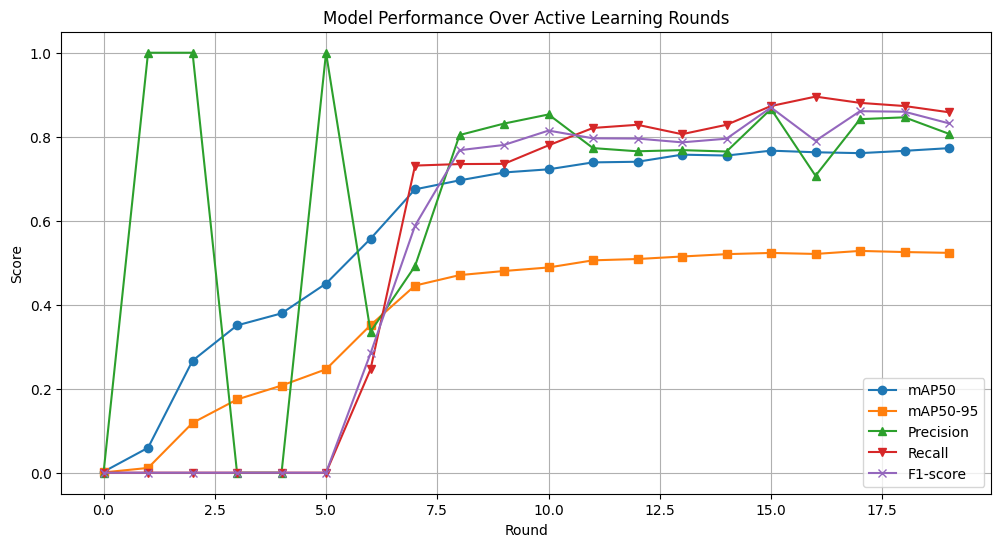

In [4]:
# 6. Active Learning Loop
train_images_folder = '/content/drive/MyDrive/AL Data/train/images'
train_labels_folder = '/content/drive/MyDrive/AL Data/train/labels'
unlabeled_images_folder = '/content/Laudare_AL/images/unlabeled'
unlabeled_labels_folder = '/content/Laudare_AL/labels/unlabeled'
val_data_yaml = '/content/Laudare_AL/data.yaml'

progress_tracker = []
round_num = 0
k_per_round = 15
patience = 5
no_improve_counter = 0
best_map50 = 0.0

while True:
    print(f"\n🚀 Round {round_num}")

    if round_num == 0:
        model = YOLO('yolov8n.yaml')
        model.train(data=val_data_yaml, imgsz=640, epochs=150, batch=8,
                    project='/content/Laudare_AL/yolo_runs', name='round_0')
    else:
        if len(os.listdir(unlabeled_images_folder)) == 0:
            print("✅ No more unlabeled images. Stopping.")
            break

        latest_model_path = f'/content/Laudare_AL/yolo_runs/round_{round_num-1}/weights/best.pt'


        selected_images = select_uncertain_images(model, unlabeled_images_folder, k=k_per_round)
        if not selected_images:
            print("✅ No uncertain images left. Stopping.")
            break

        with open(f"/content/Laudare_AL/round_{round_num}_selected_images.txt", 'w') as f:
            for img in selected_images:
                f.write(f"{img}\n")

        move_selected_images(selected_images, unlabeled_images_folder, train_images_folder,
                             unlabeled_labels_folder, train_labels_folder)

        model = YOLO(latest_model_path)
        model.train(data=val_data_yaml, imgsz=640, epochs=150, batch=8,
                    project='/content/Laudare_AL/yolo_runs', name=f'round_{round_num}')

    # Evaluate
    final_model_path = f'/content/Laudare_AL/yolo_runs/round_{round_num}/weights/best.pt'
    eval_model = YOLO(final_model_path)
    metrics = evaluate_model(eval_model, val_data_yaml)

    num_images = len(os.listdir(train_images_folder))
    progress_tracker.append({
        'Round': round_num,
        '#Images Labeled': num_images,
        'mAP50': round(metrics['mAP50'], 4),
        'mAP50-95': round(metrics['mAP50-95'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1-score': round(metrics['F1'], 4),
    })

    if metrics['mAP50'] > best_map50:
        best_map50 = metrics['mAP50']
        no_improve_counter = 0
        print(f"✅ Improved mAP50: {best_map50:.4f}")
    else:
        no_improve_counter += 1
        print(f"No improvement. Patience count: {no_improve_counter}")

    if no_improve_counter >= patience:
        print("❌ Patience exceeded. Stopping.")
        break

    round_num += 1

# 7. Show results
df_progress = pd.DataFrame(progress_tracker)
print(df_progress)

# 8. Plot metrics
plt.figure(figsize=(12, 6))
plt.plot(df_progress['Round'], df_progress['mAP50'], label='mAP50', marker='o')
plt.plot(df_progress['Round'], df_progress['mAP50-95'], label='mAP50-95', marker='s')
plt.plot(df_progress['Round'], df_progress['Precision'], label='Precision', marker='^')
plt.plot(df_progress['Round'], df_progress['Recall'], label='Recall', marker='v')
plt.plot(df_progress['Round'], df_progress['F1-score'], label='F1-score', marker='x')
plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Model Performance Over Active Learning Rounds")
plt.grid(True)
plt.legend()
plt.show()


In [5]:
from google.colab import files
import shutil

# Create a ZIP file of the folder
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# Download the ZIP file
files.download('/content/runs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>